In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')


In [29]:
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=677)
loc_df = loc_df.loc[(loc_df['path_to_top_parent'].str.startswith('102,')) & (loc_df['most_detailed'] == 1), 
                    ['location_id', 'location_name']]

est_dfs = []
for i in range(7):
    est_df = pd.read_csv(f'/ihme/covid-19/deaths/dev/2020_05_23_cfrmod_sub{i+8}/model_results.csv')
    est_df['date'] = pd.to_datetime(est_df['date'])
    est_df = est_df.loc[est_df['location_id'].isin(loc_df['location_id'].to_list())]
    est_df['Predicted deaths'] = np.nan
    est_df['Predicted deaths'][1:] = np.diff(est_df[[f'draw_{d}' for d in range(1000)]], axis=0).mean(axis=1)
    est_df = est_df.loc[est_df['date'] > est_df.groupby('location_id')['date'].transform('max') - pd.Timedelta(days=8)]
    est_dfs.append(est_df[['location_id', 'date', 'Predicted deaths']])
    
    
est_df = pd.read_csv(f'/ihme/covid-19/deaths/dev/2020_05_23_cfrmod/model_results.csv')
est_df['date'] = pd.to_datetime(est_df['date'])
est_df = est_df.loc[est_df['location_id'].isin(loc_df['location_id'].to_list())]
est_df['Overall predicted deaths'] = np.nan
est_df['Overall predicted deaths'][1:] = np.diff(est_df[[f'draw_{d}' for d in range(1000)]], axis=0).mean(axis=1)
est_df = est_df[['location_id', 'date', 'Overall predicted deaths']]
    
data_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_05_23_cfrmod/model_data.csv')
data_df['date'] = pd.to_datetime(data_df['Date'])
data_df['Observed deaths'] = np.nan
data_df['Observed deaths'][1:] = np.diff(data_df['Death rate'] * data_df['population'])
data_df = data_df[['location_id', 'date', 'Observed deaths']]

df = data_df.merge(est_df)
df = loc_df.merge(df)


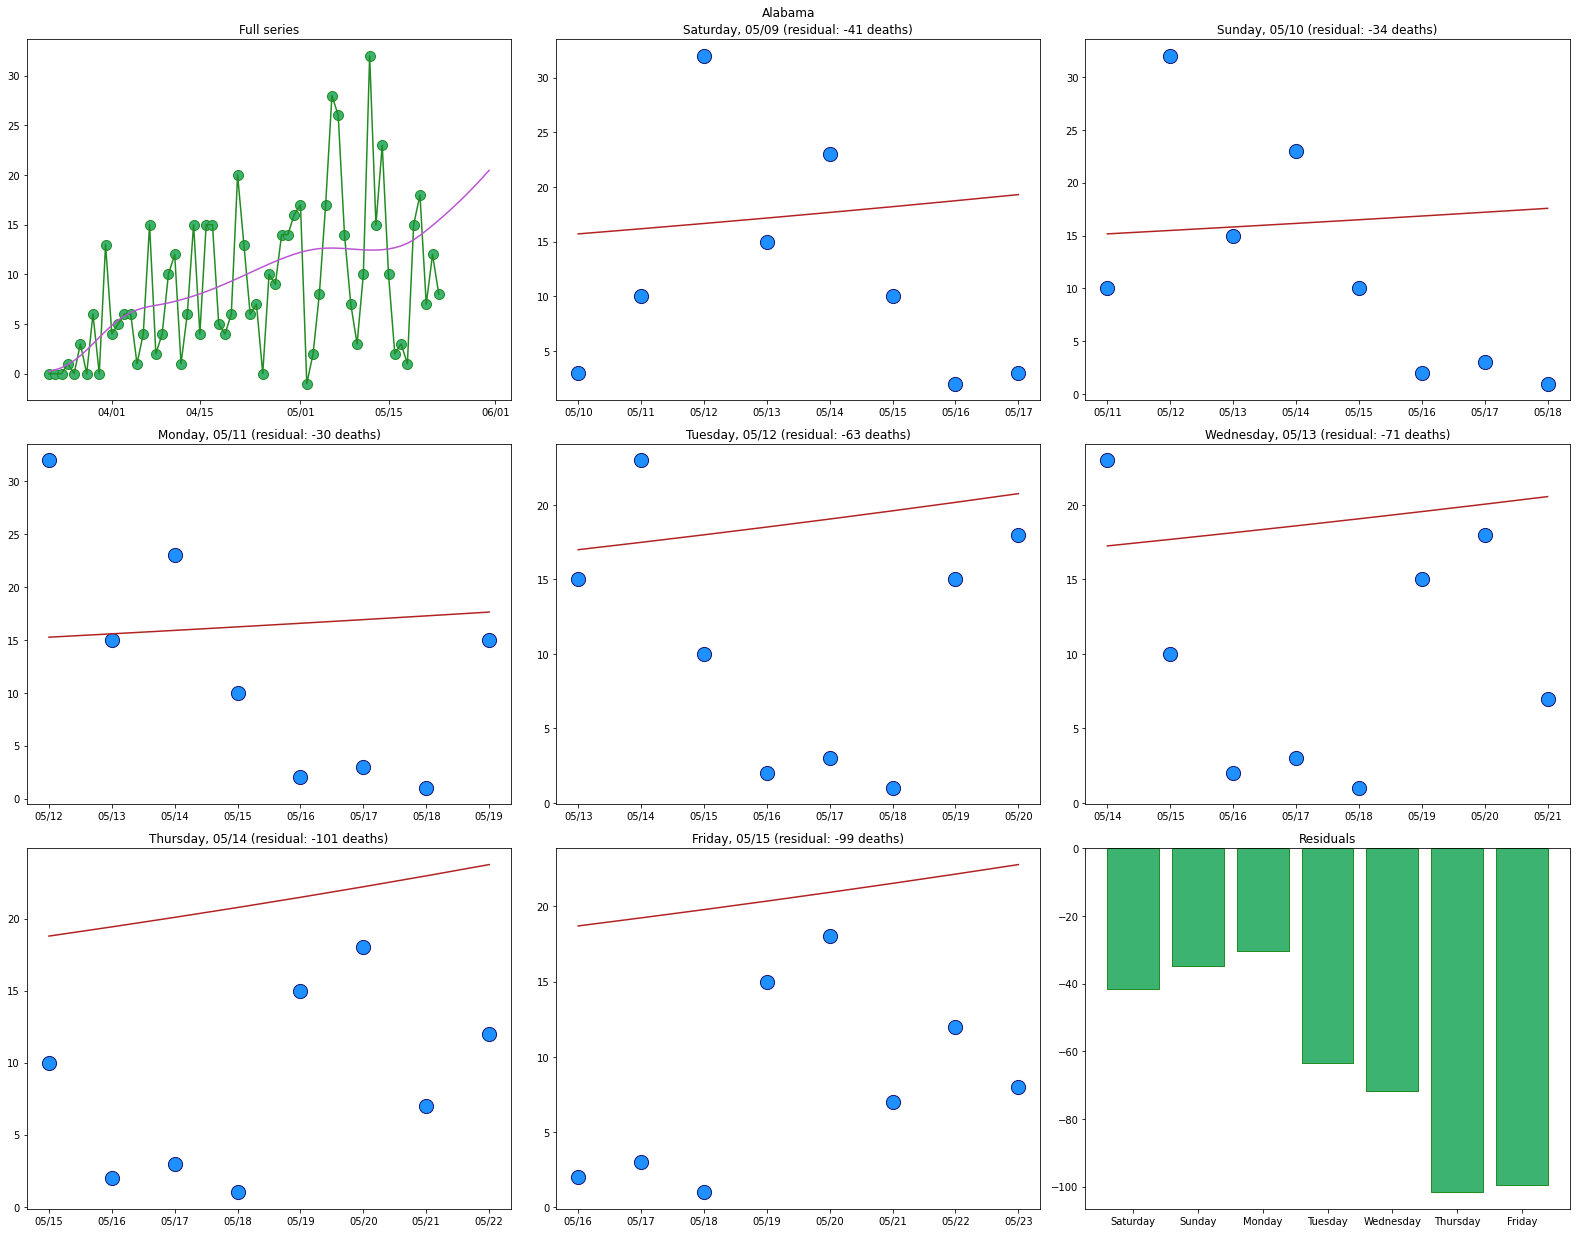

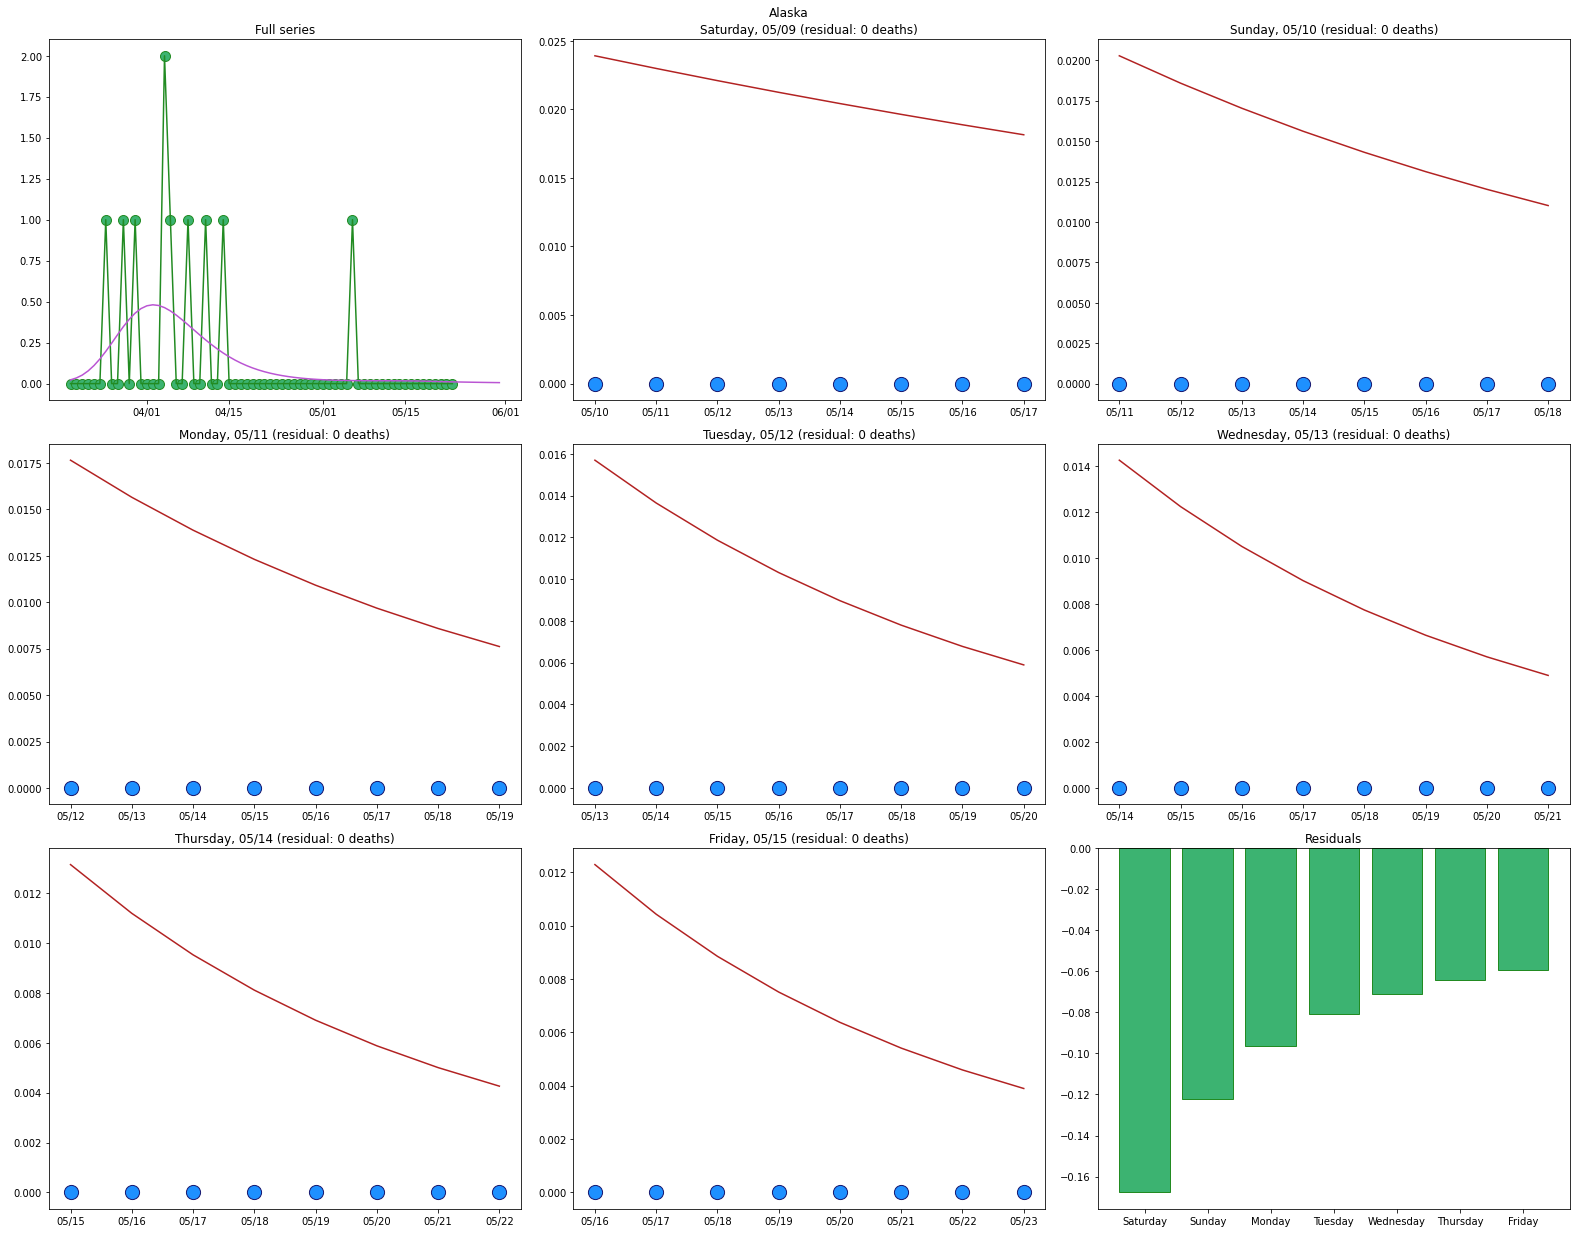

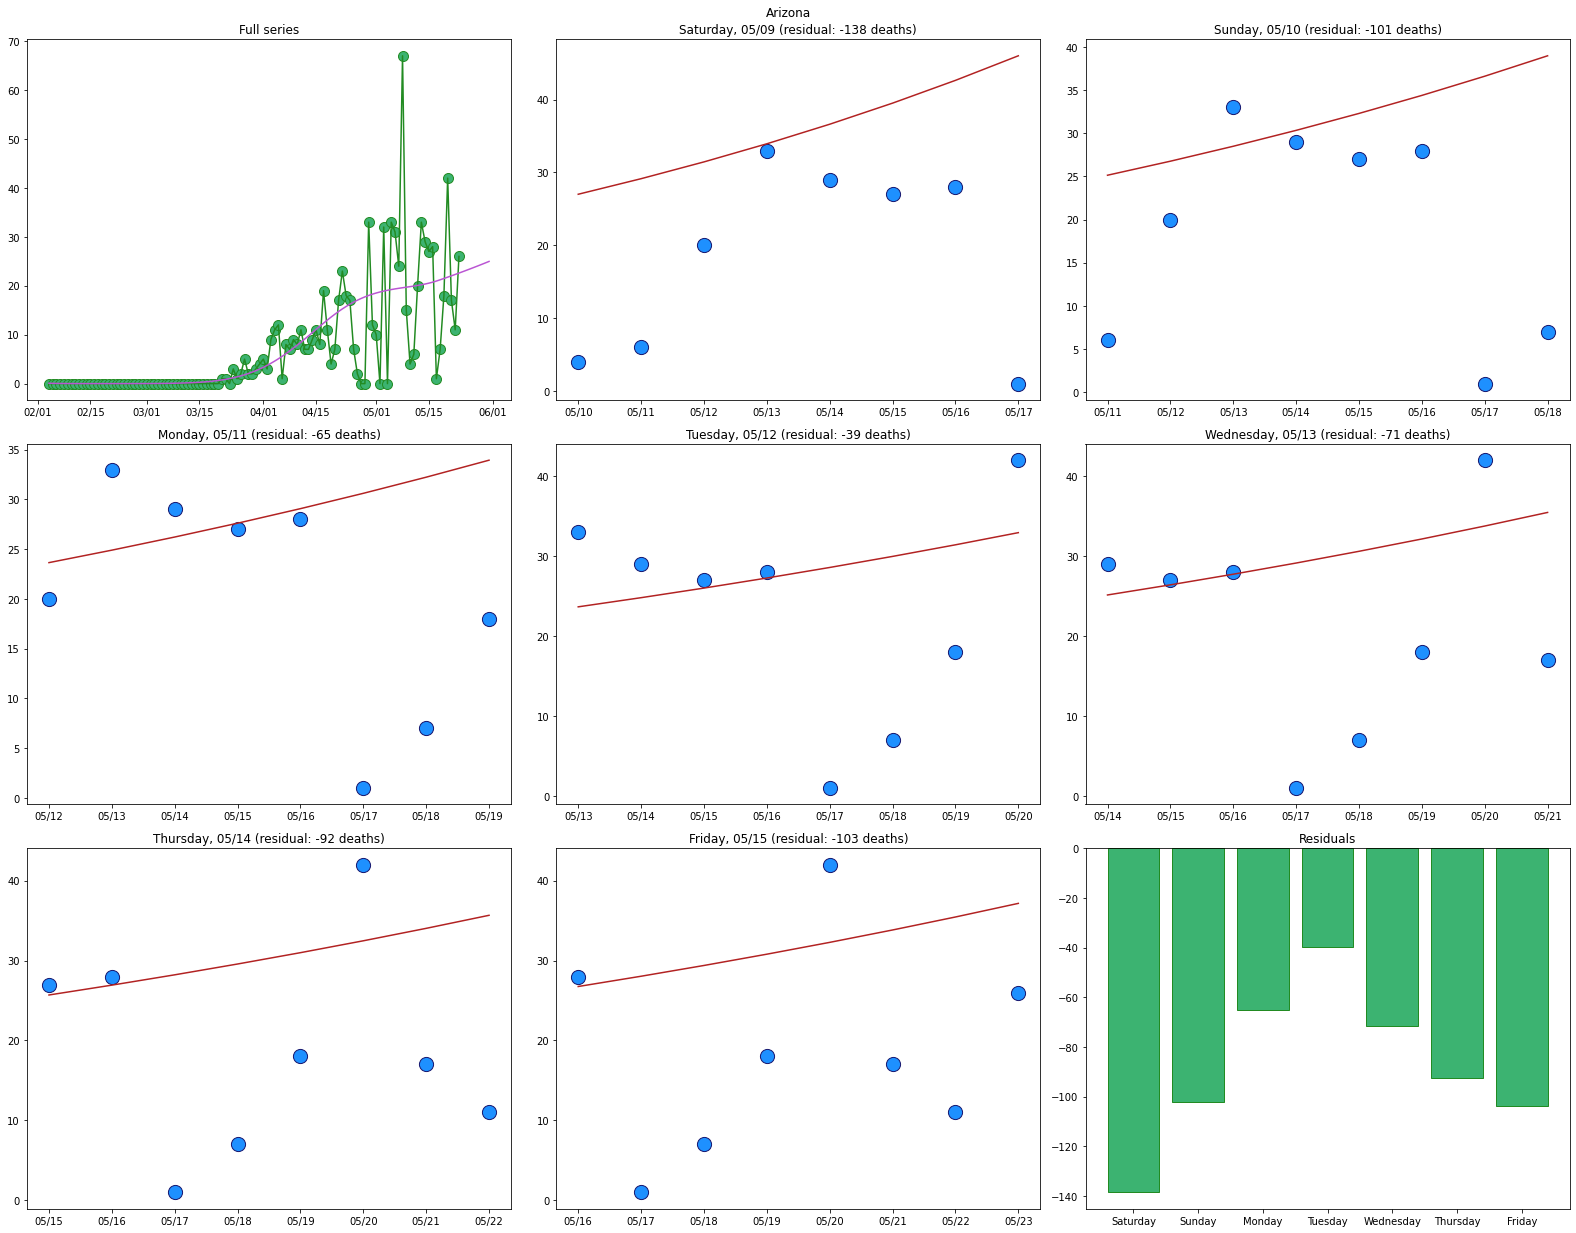

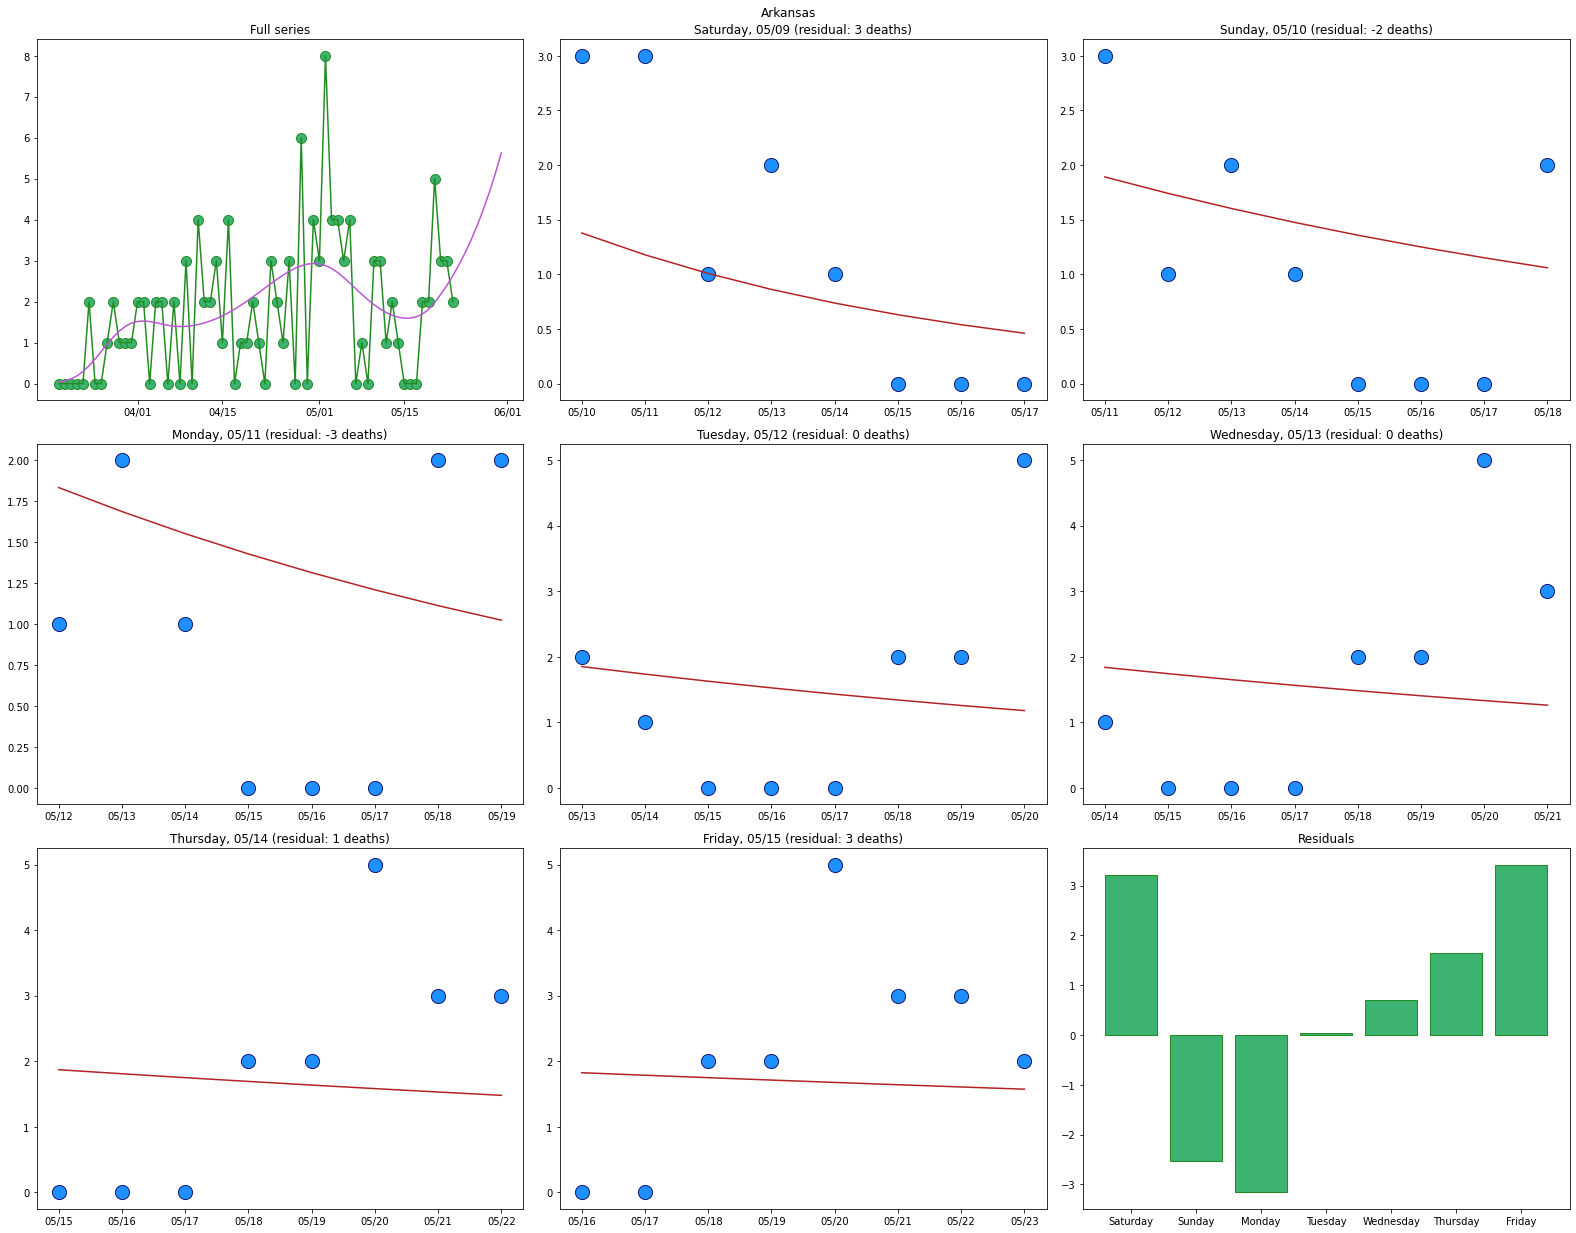

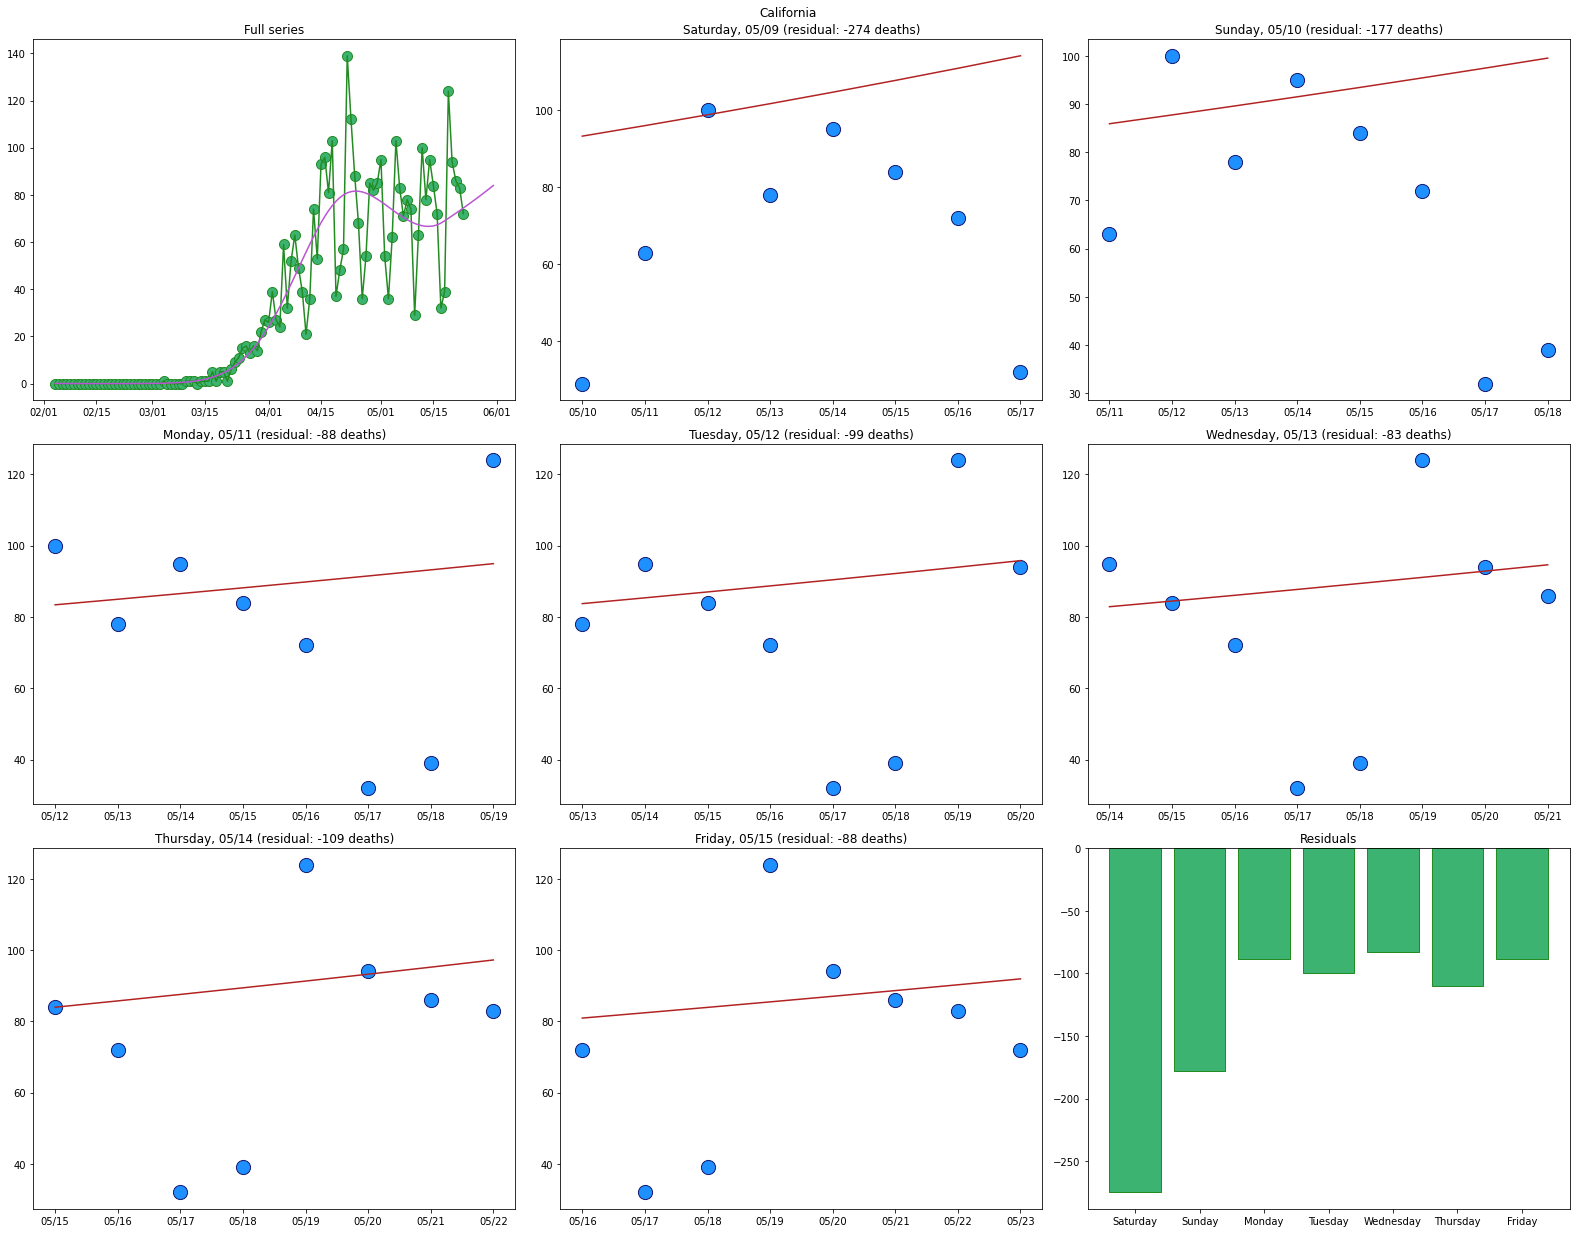

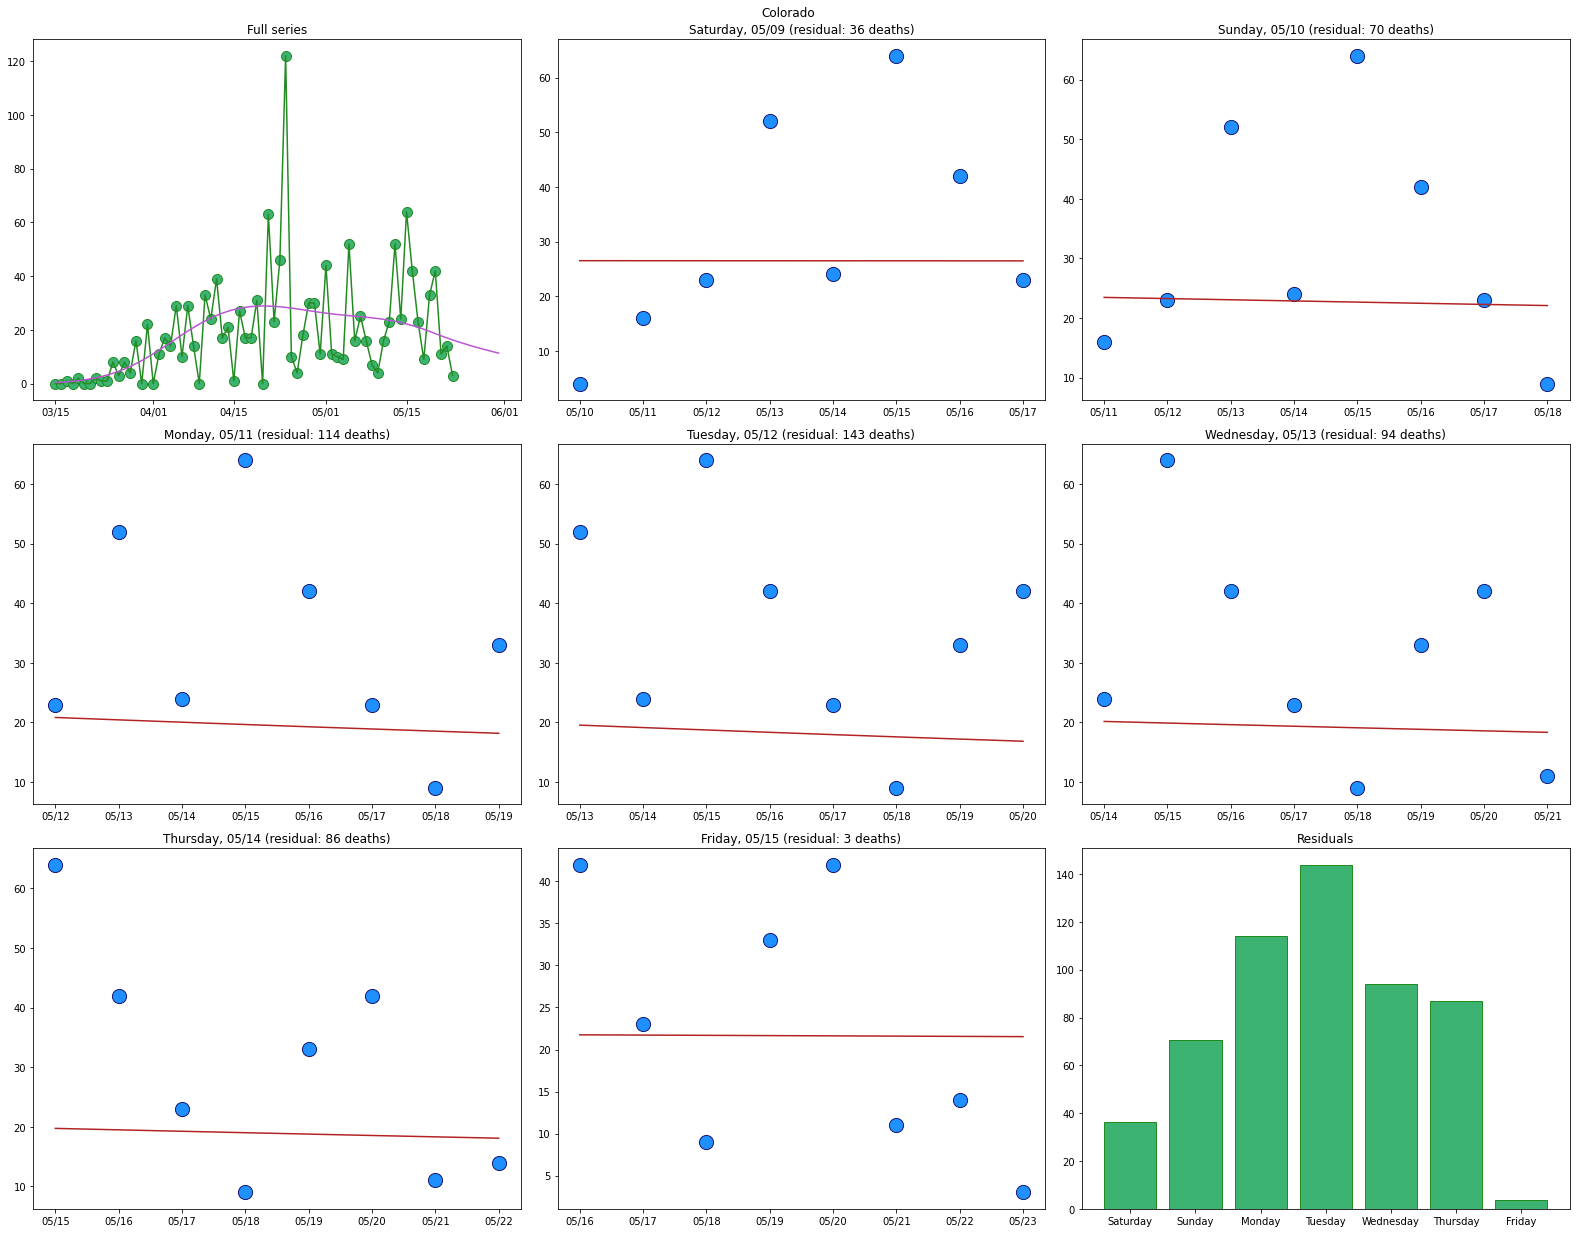

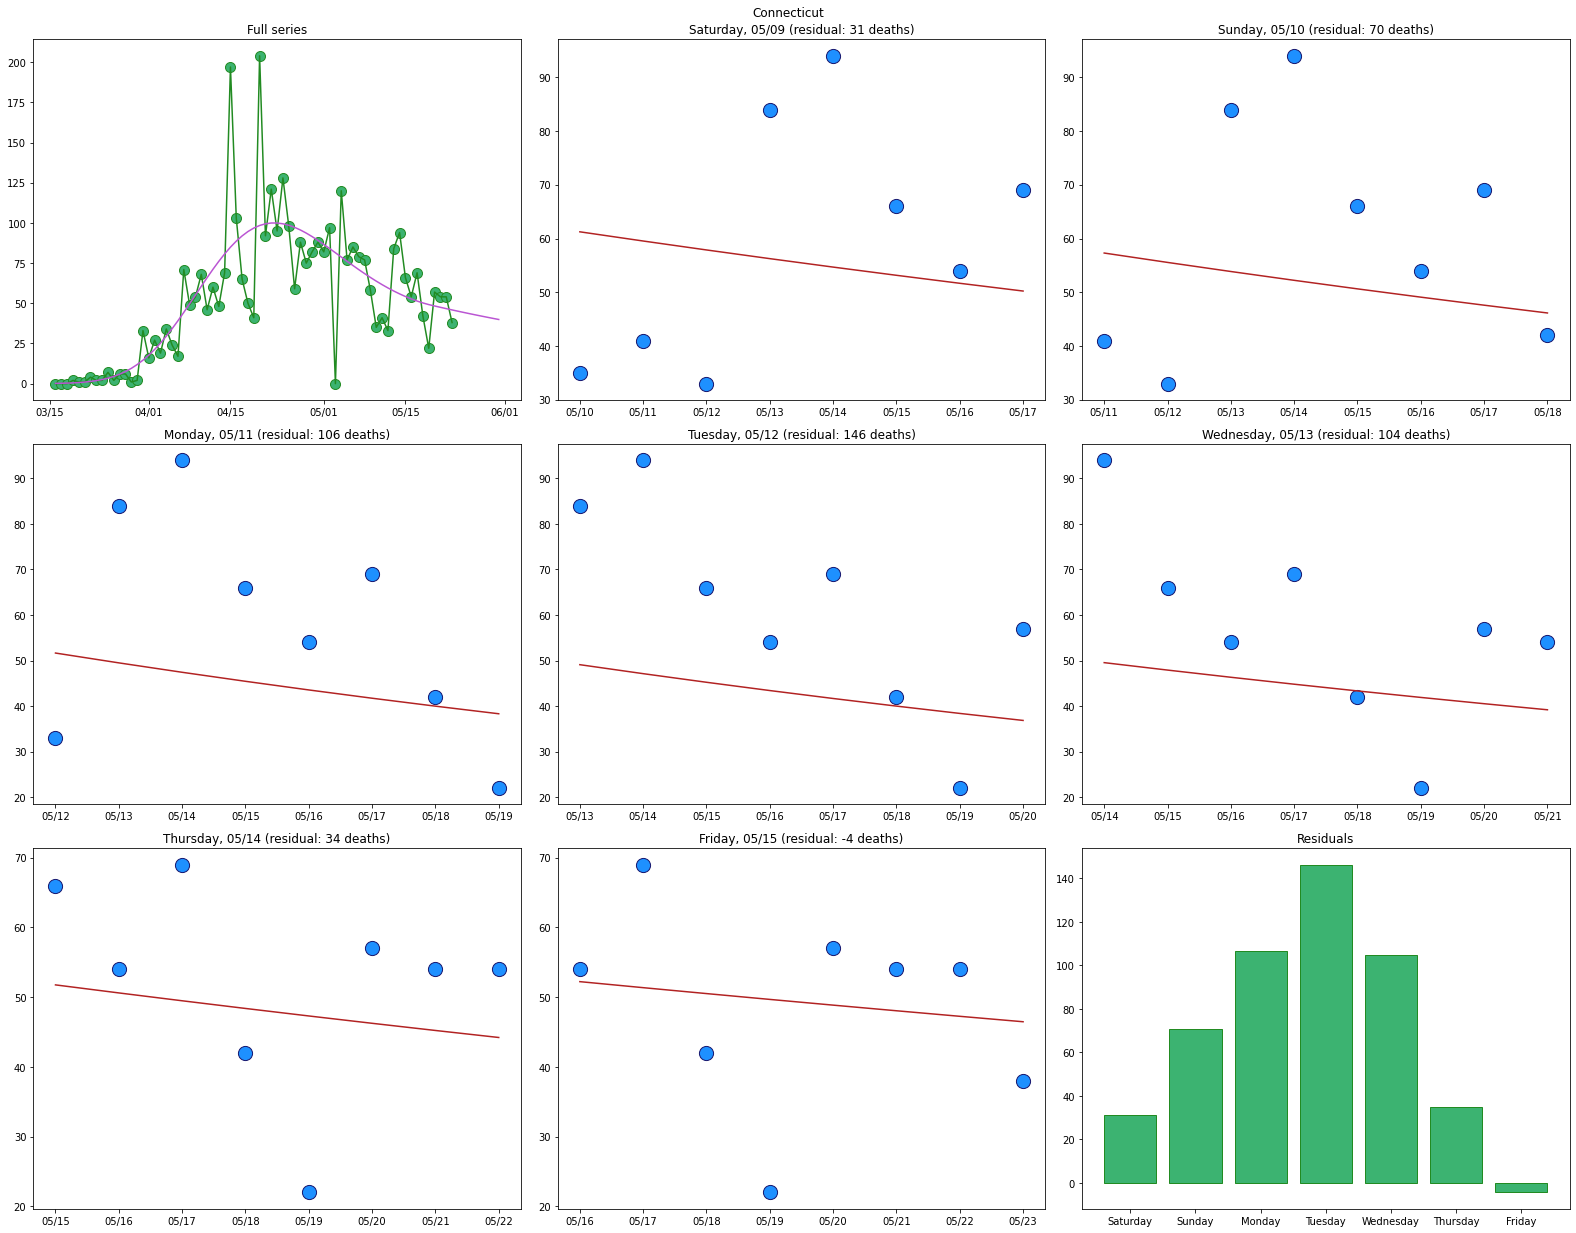

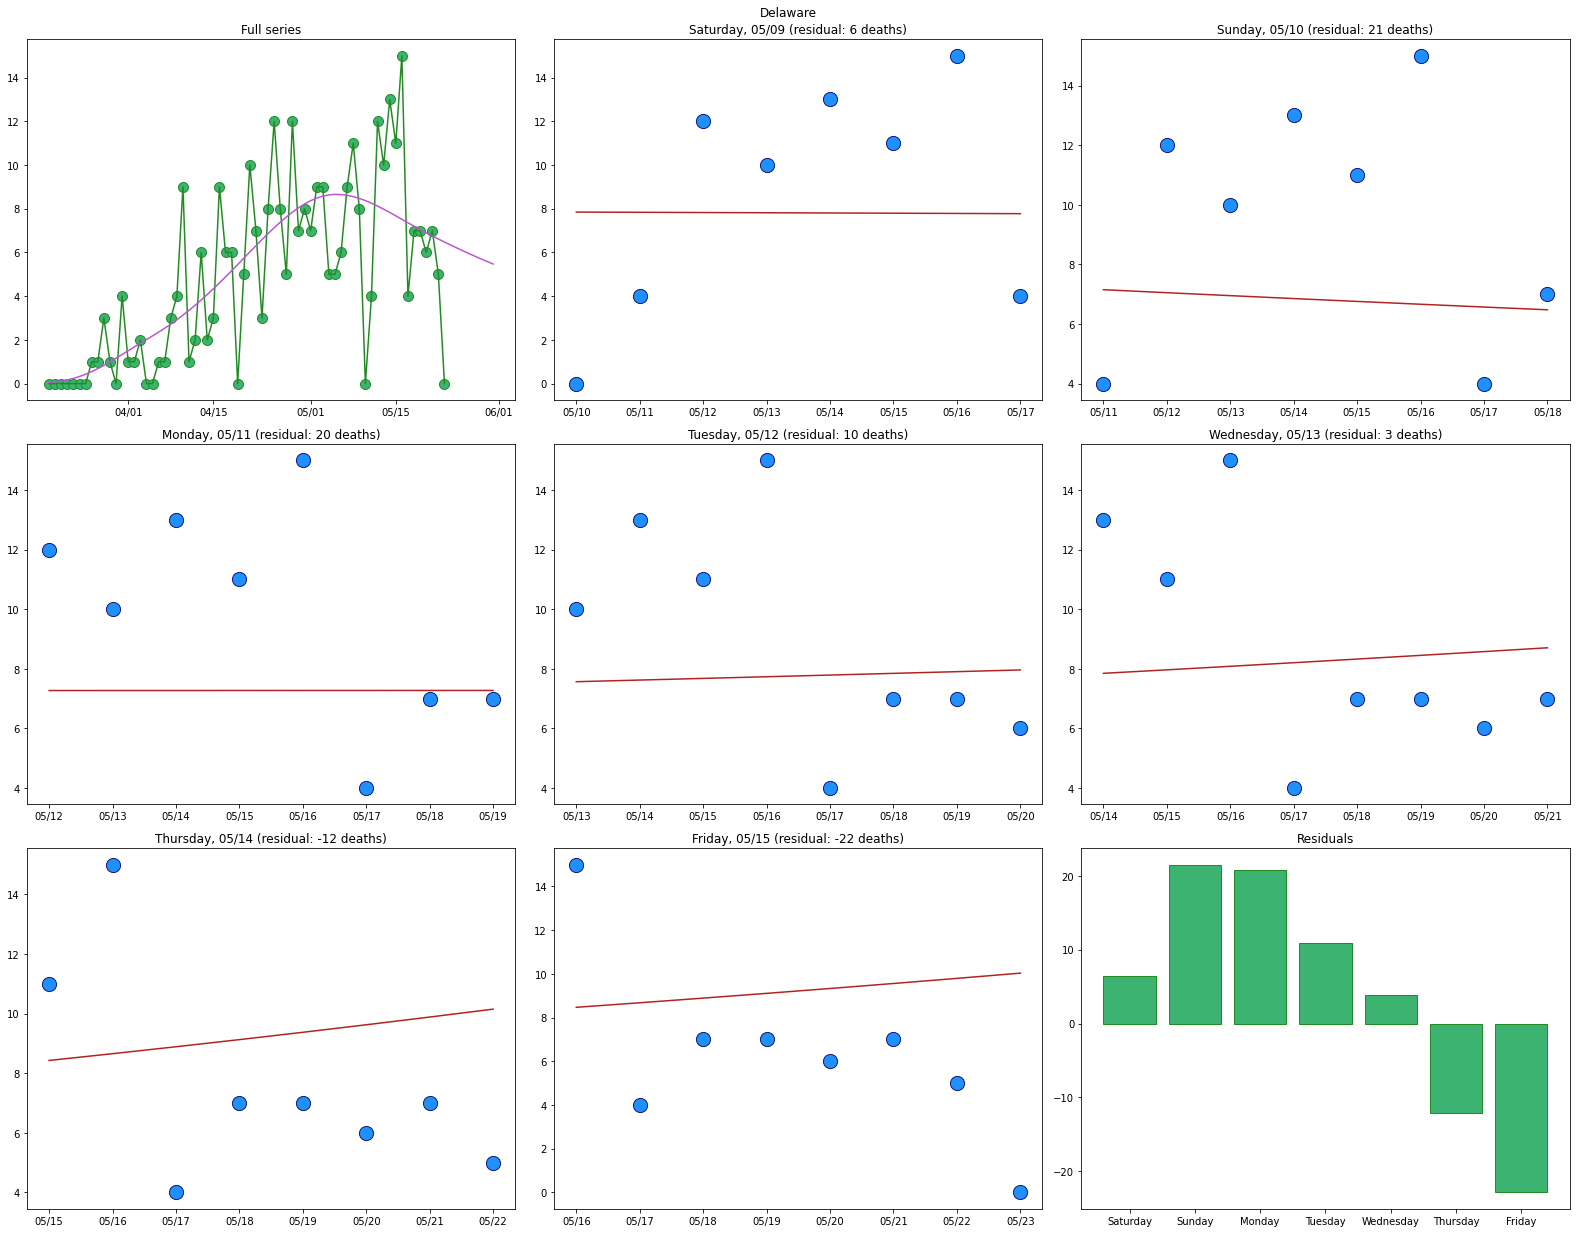

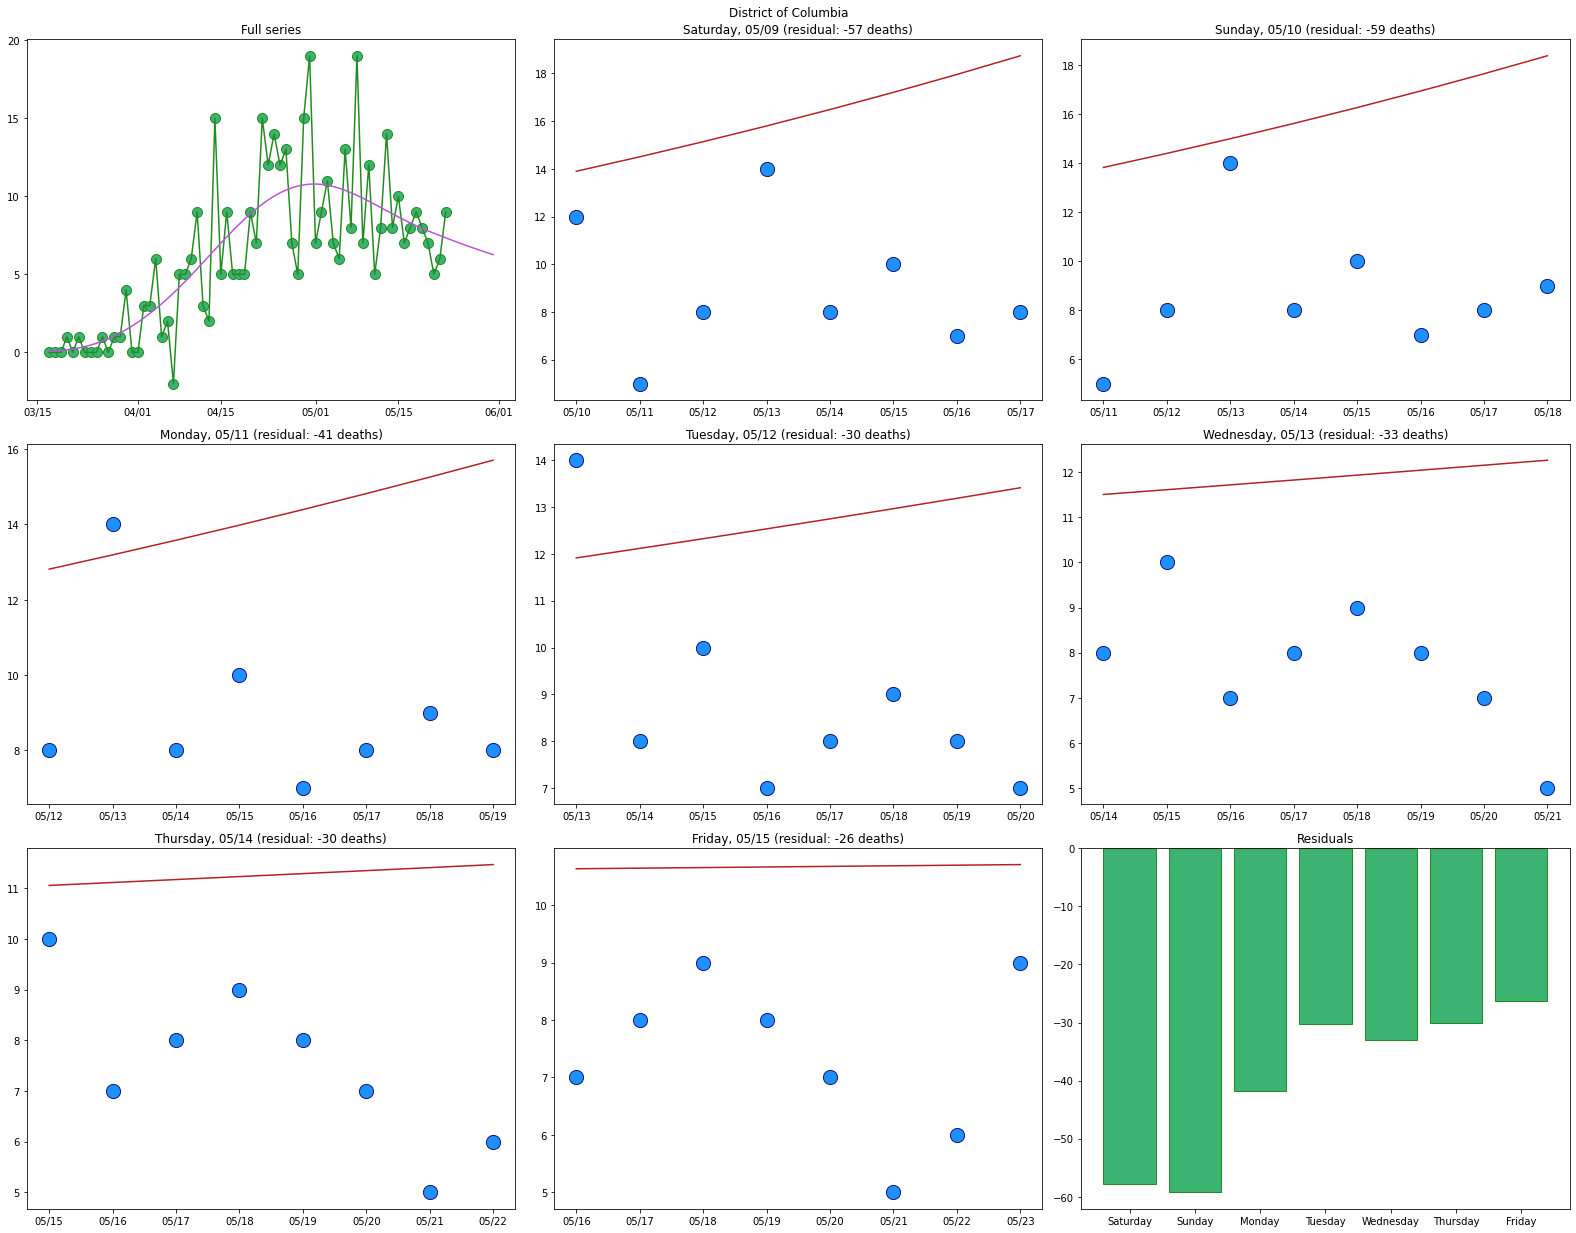

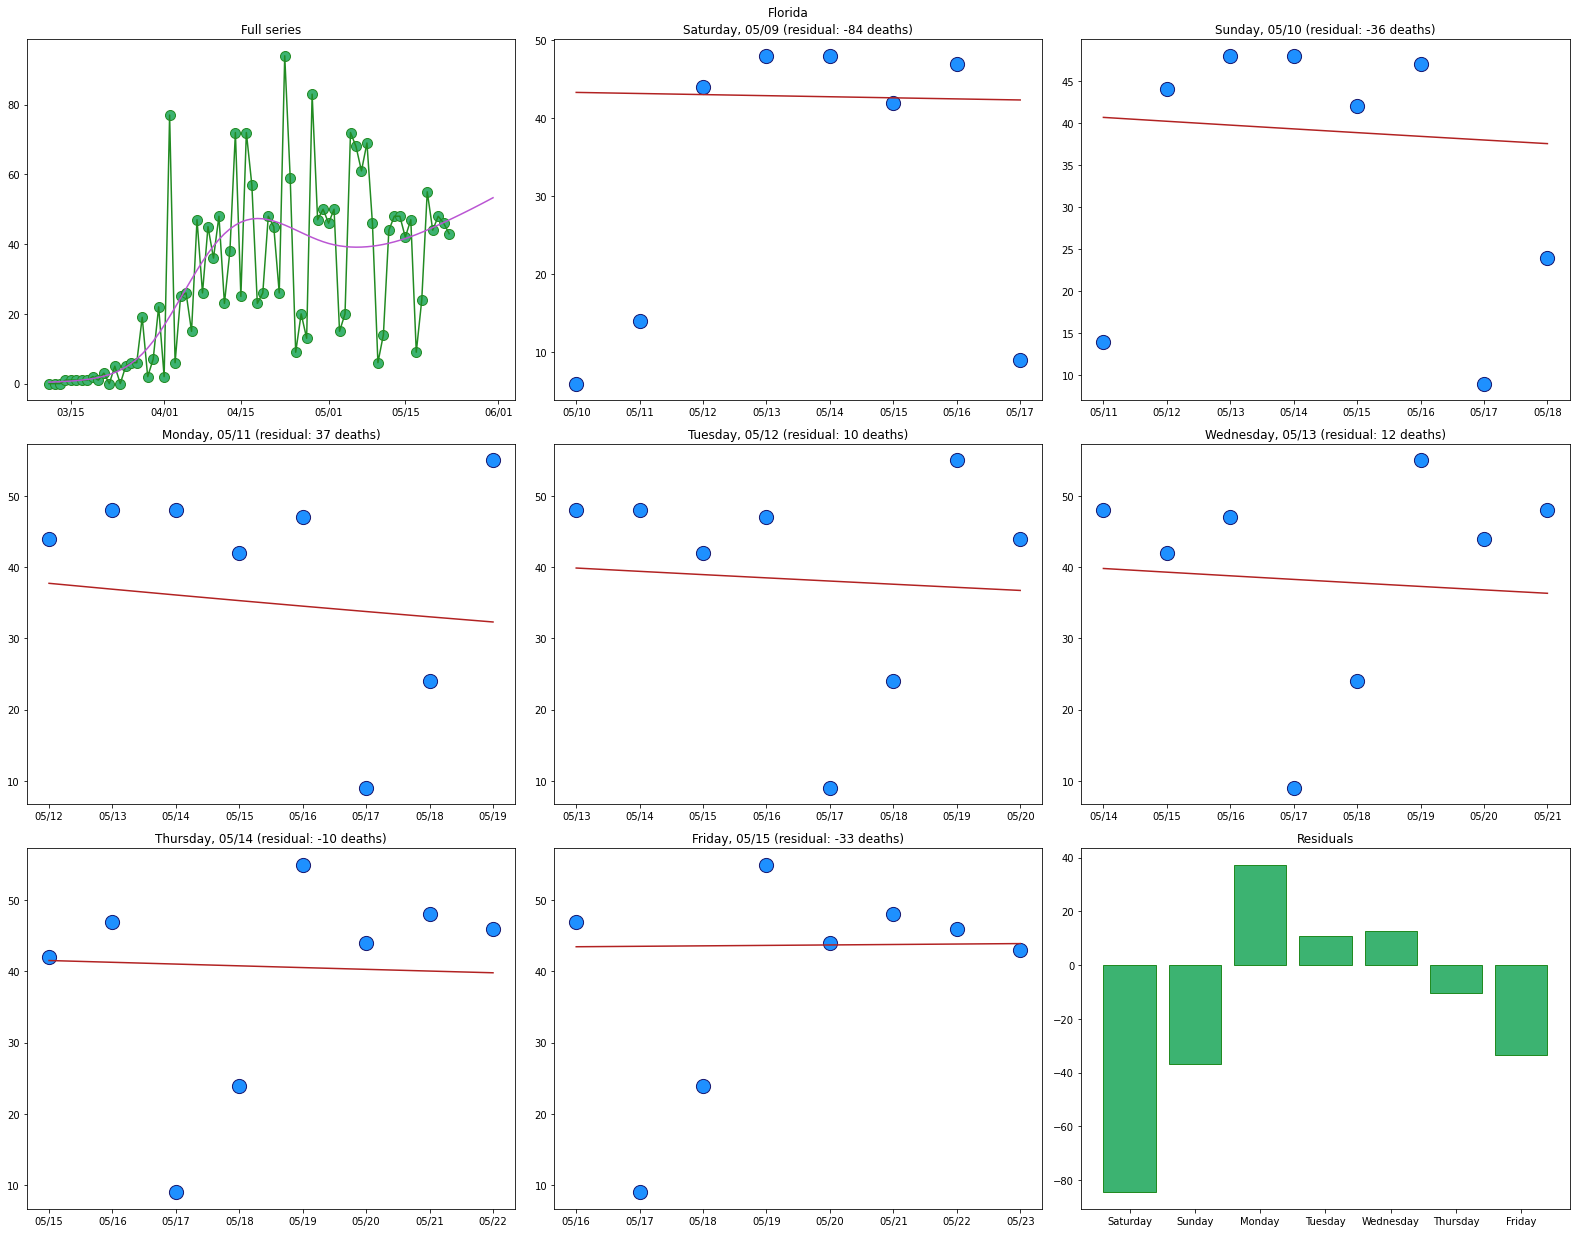

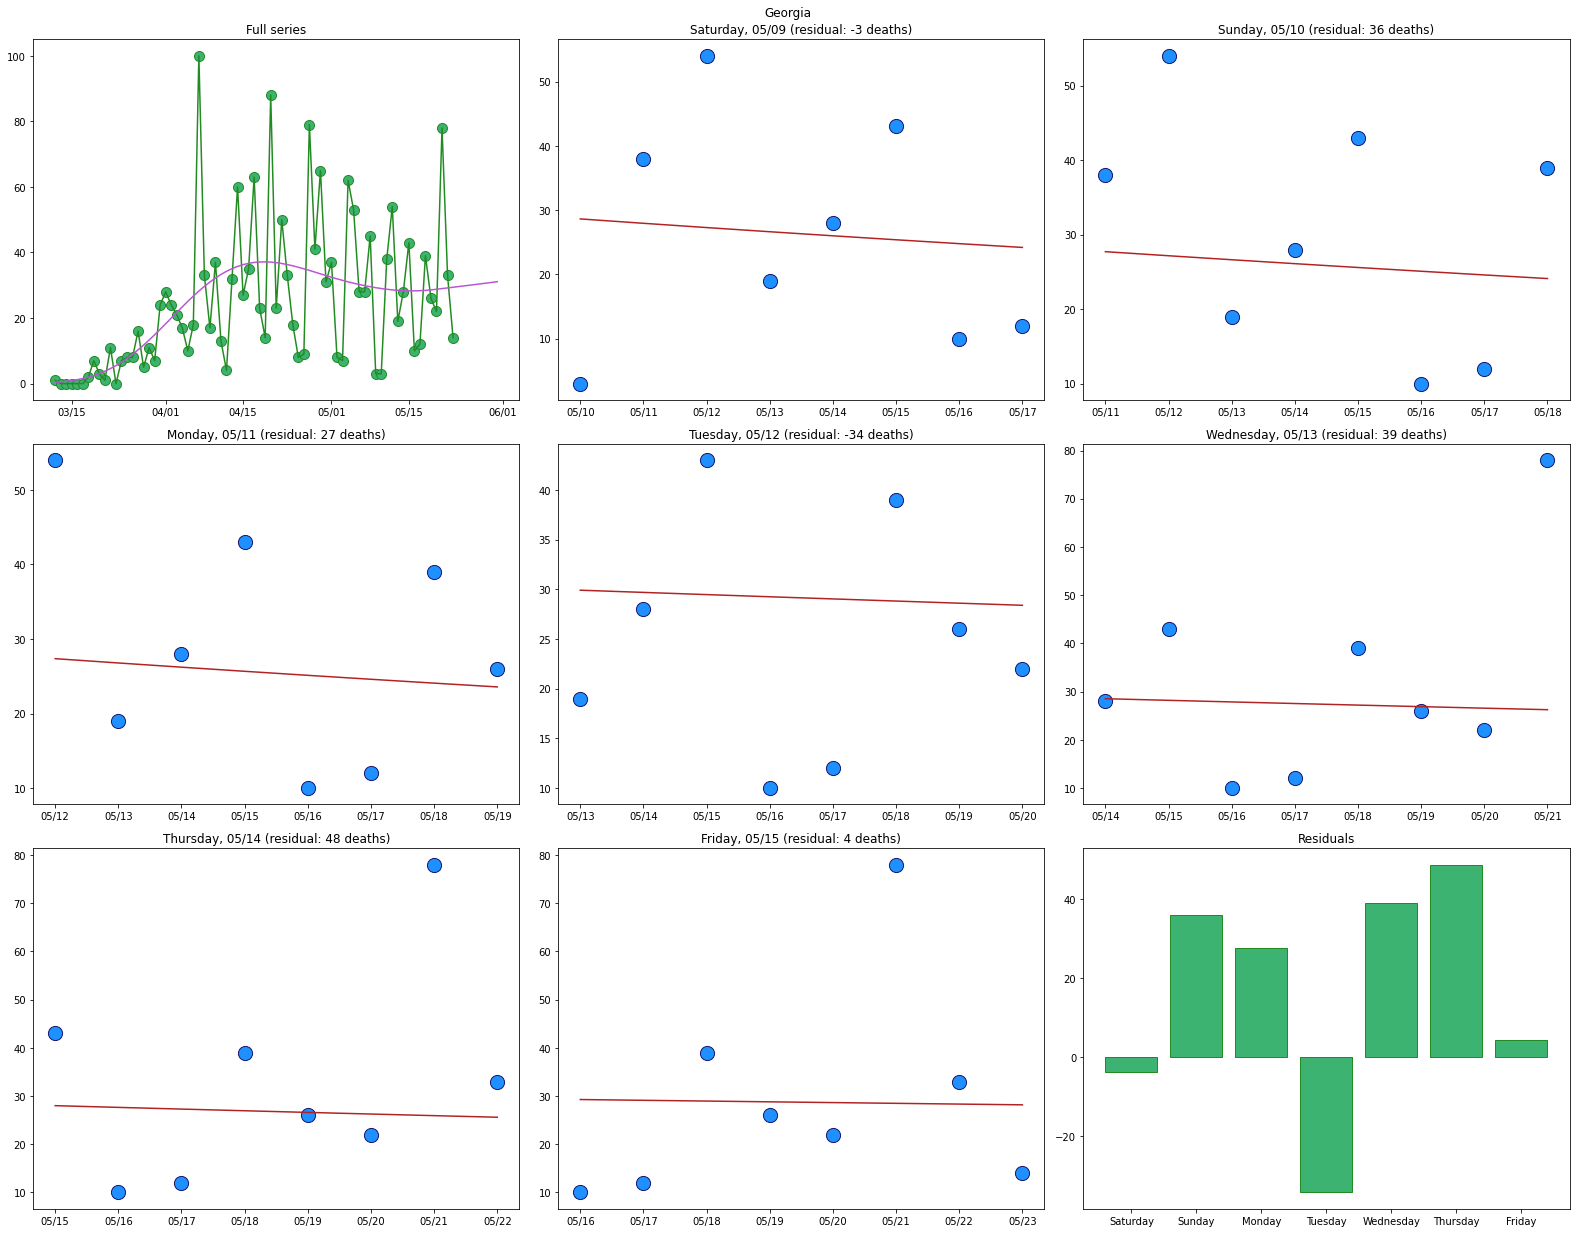

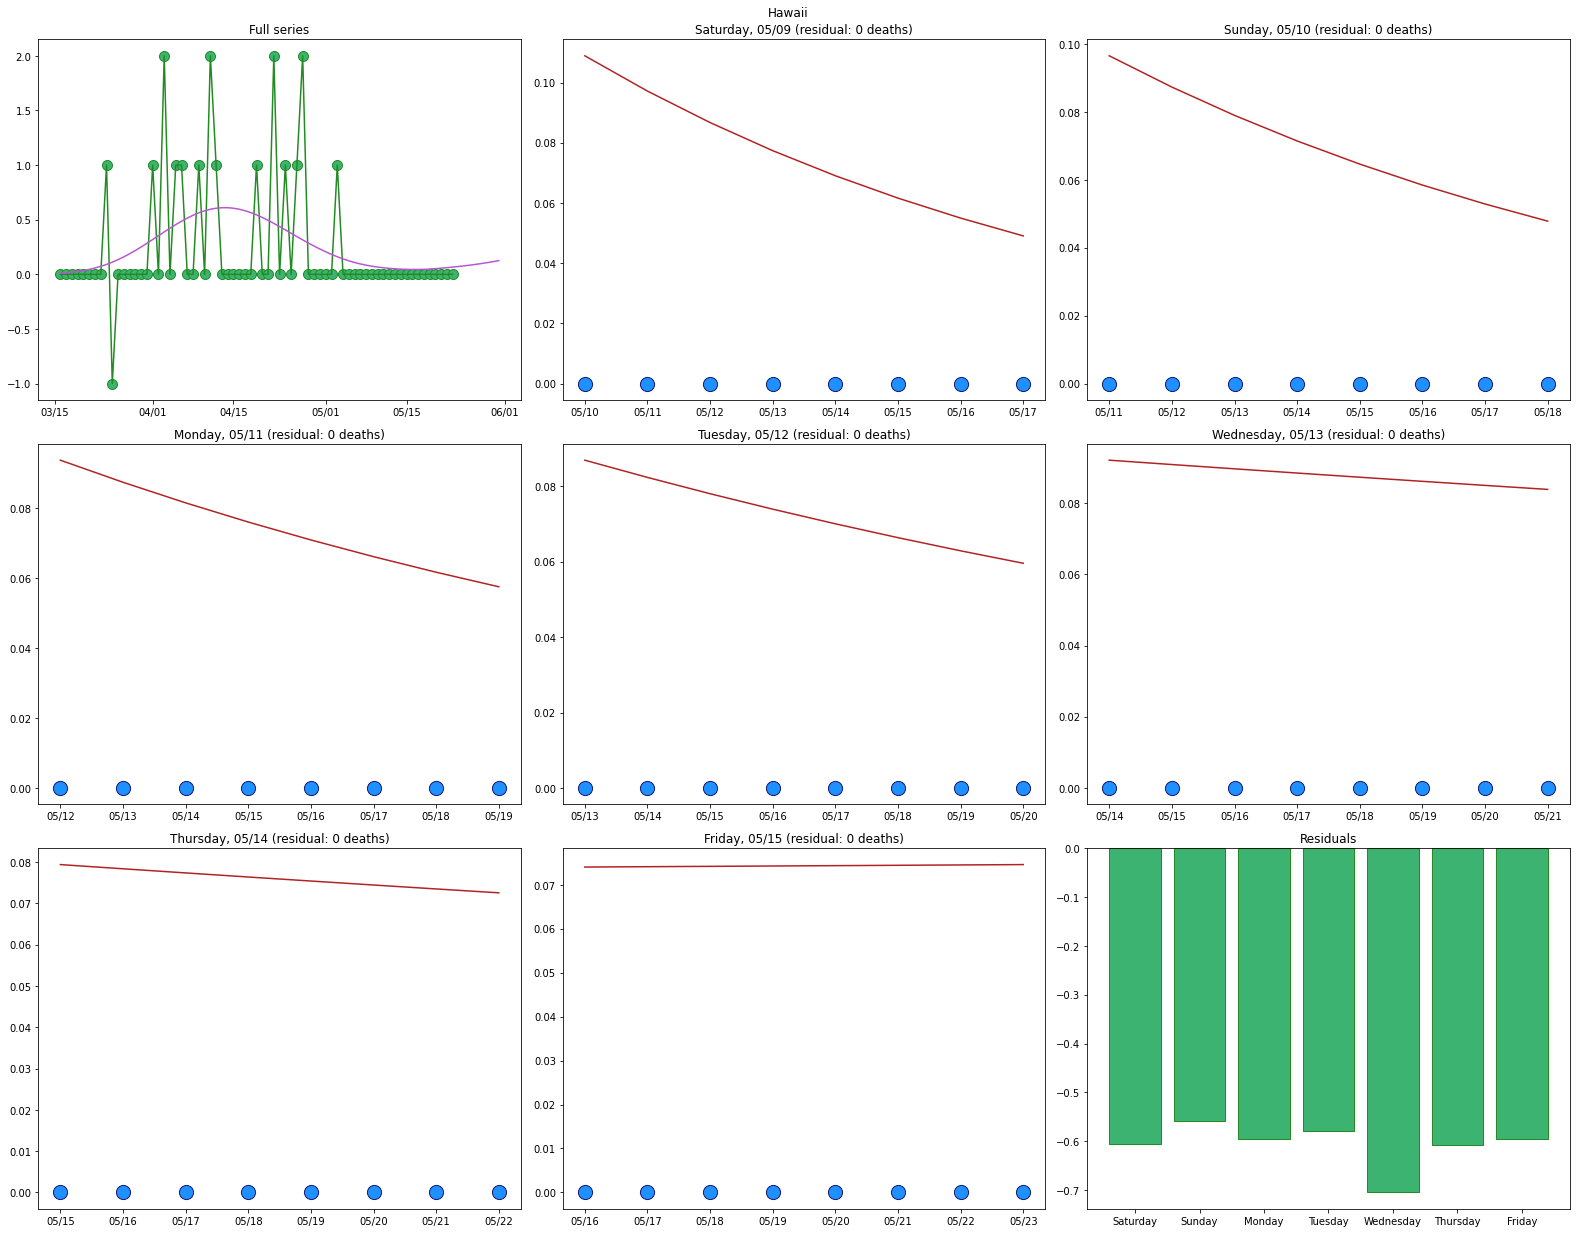

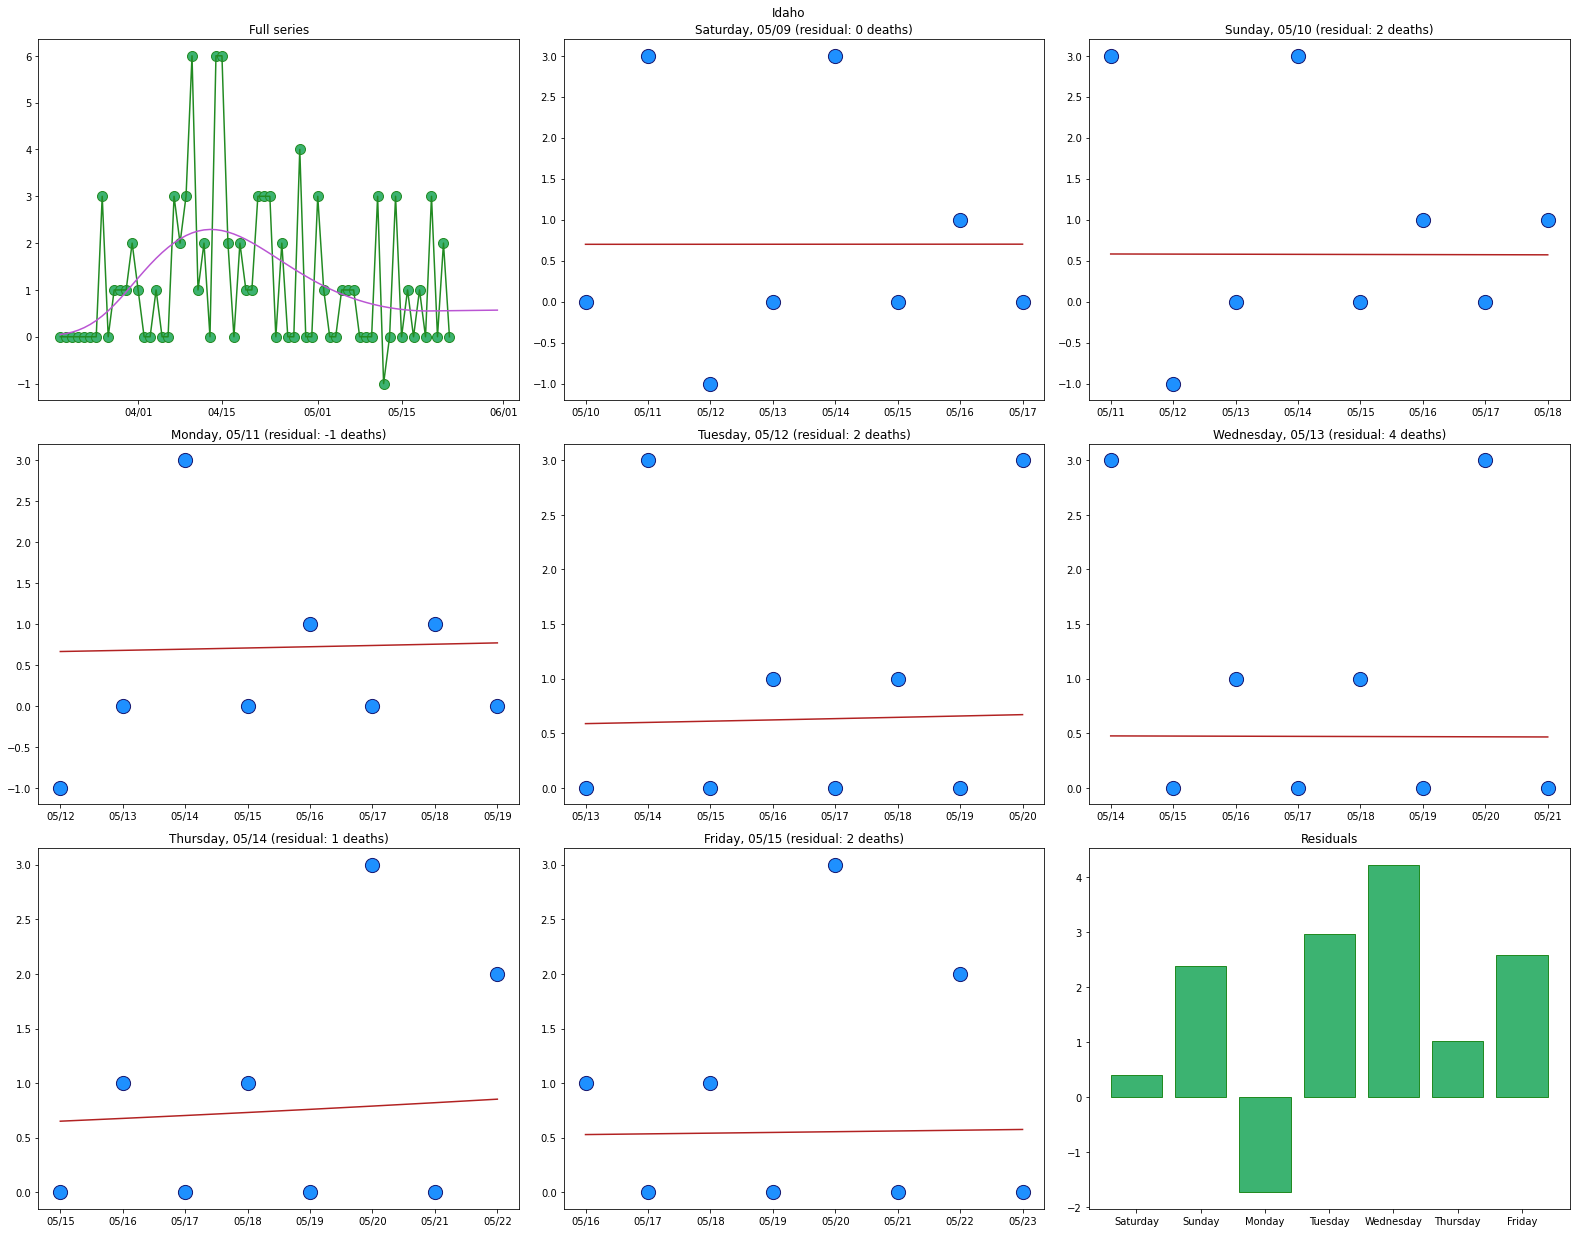

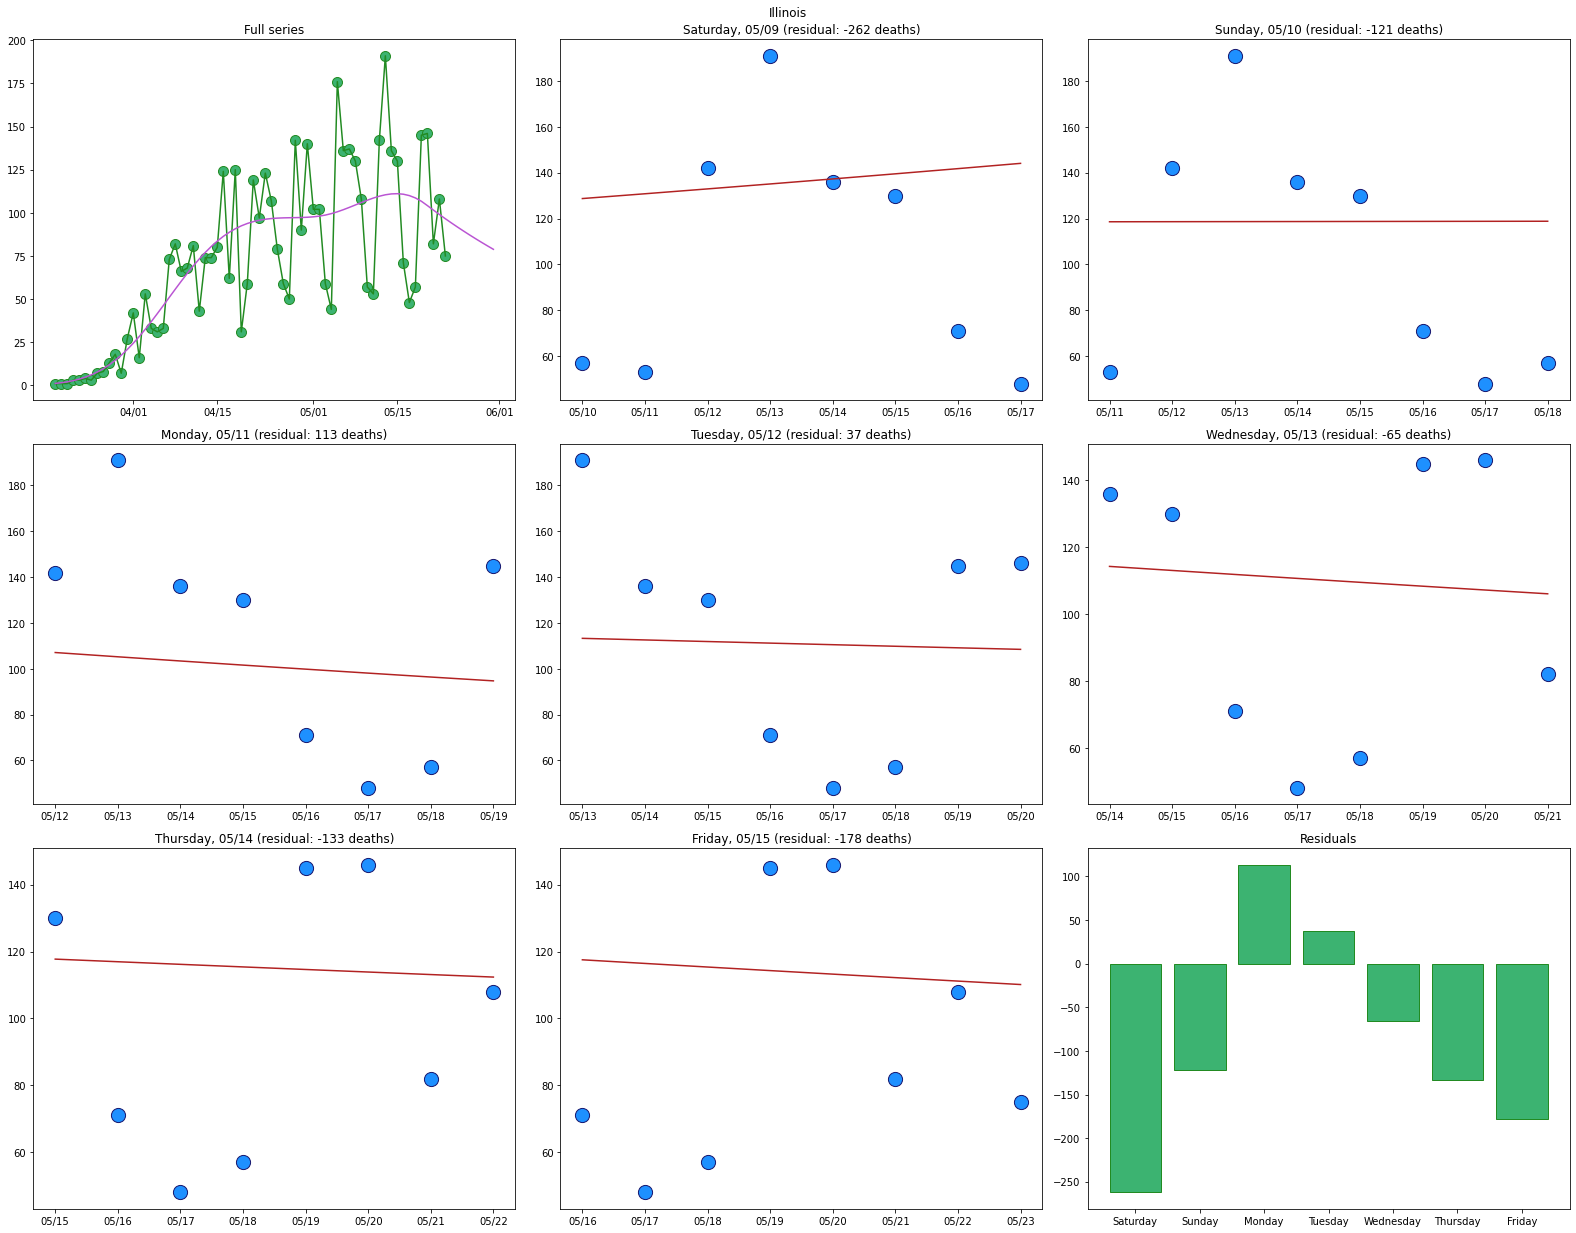

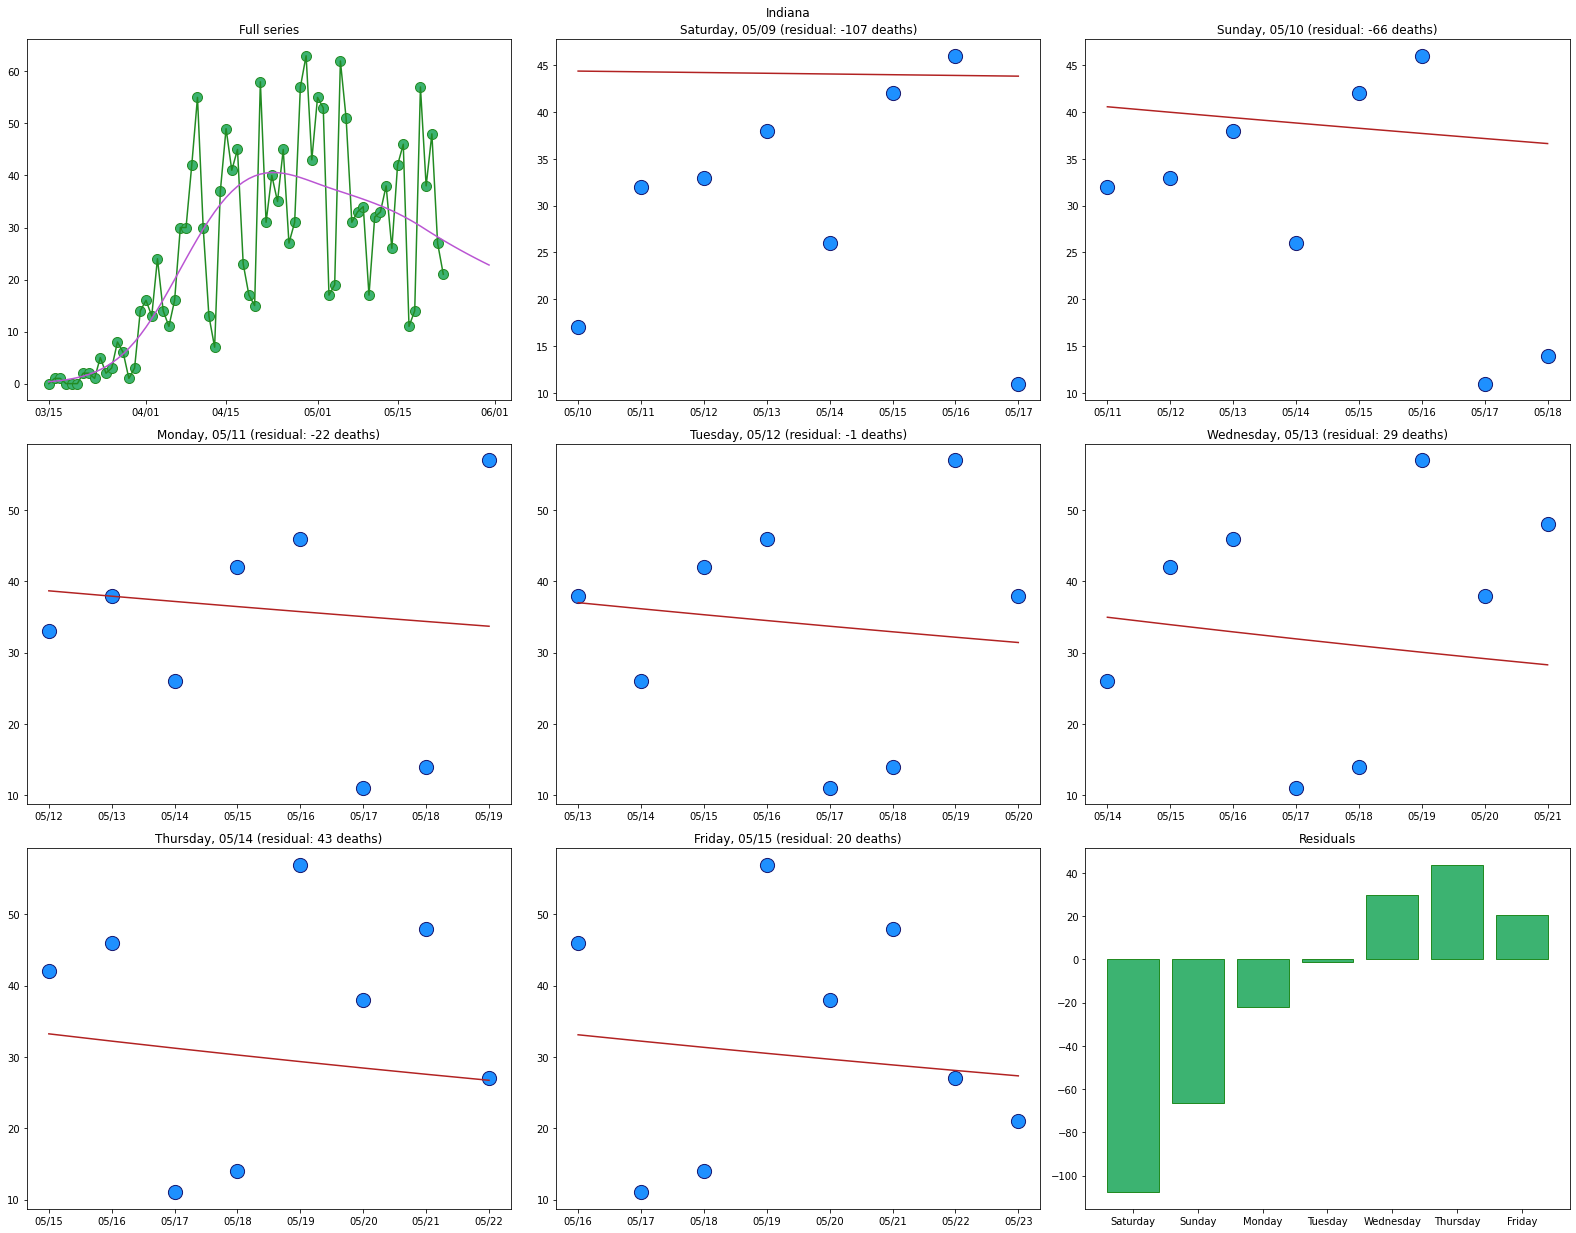

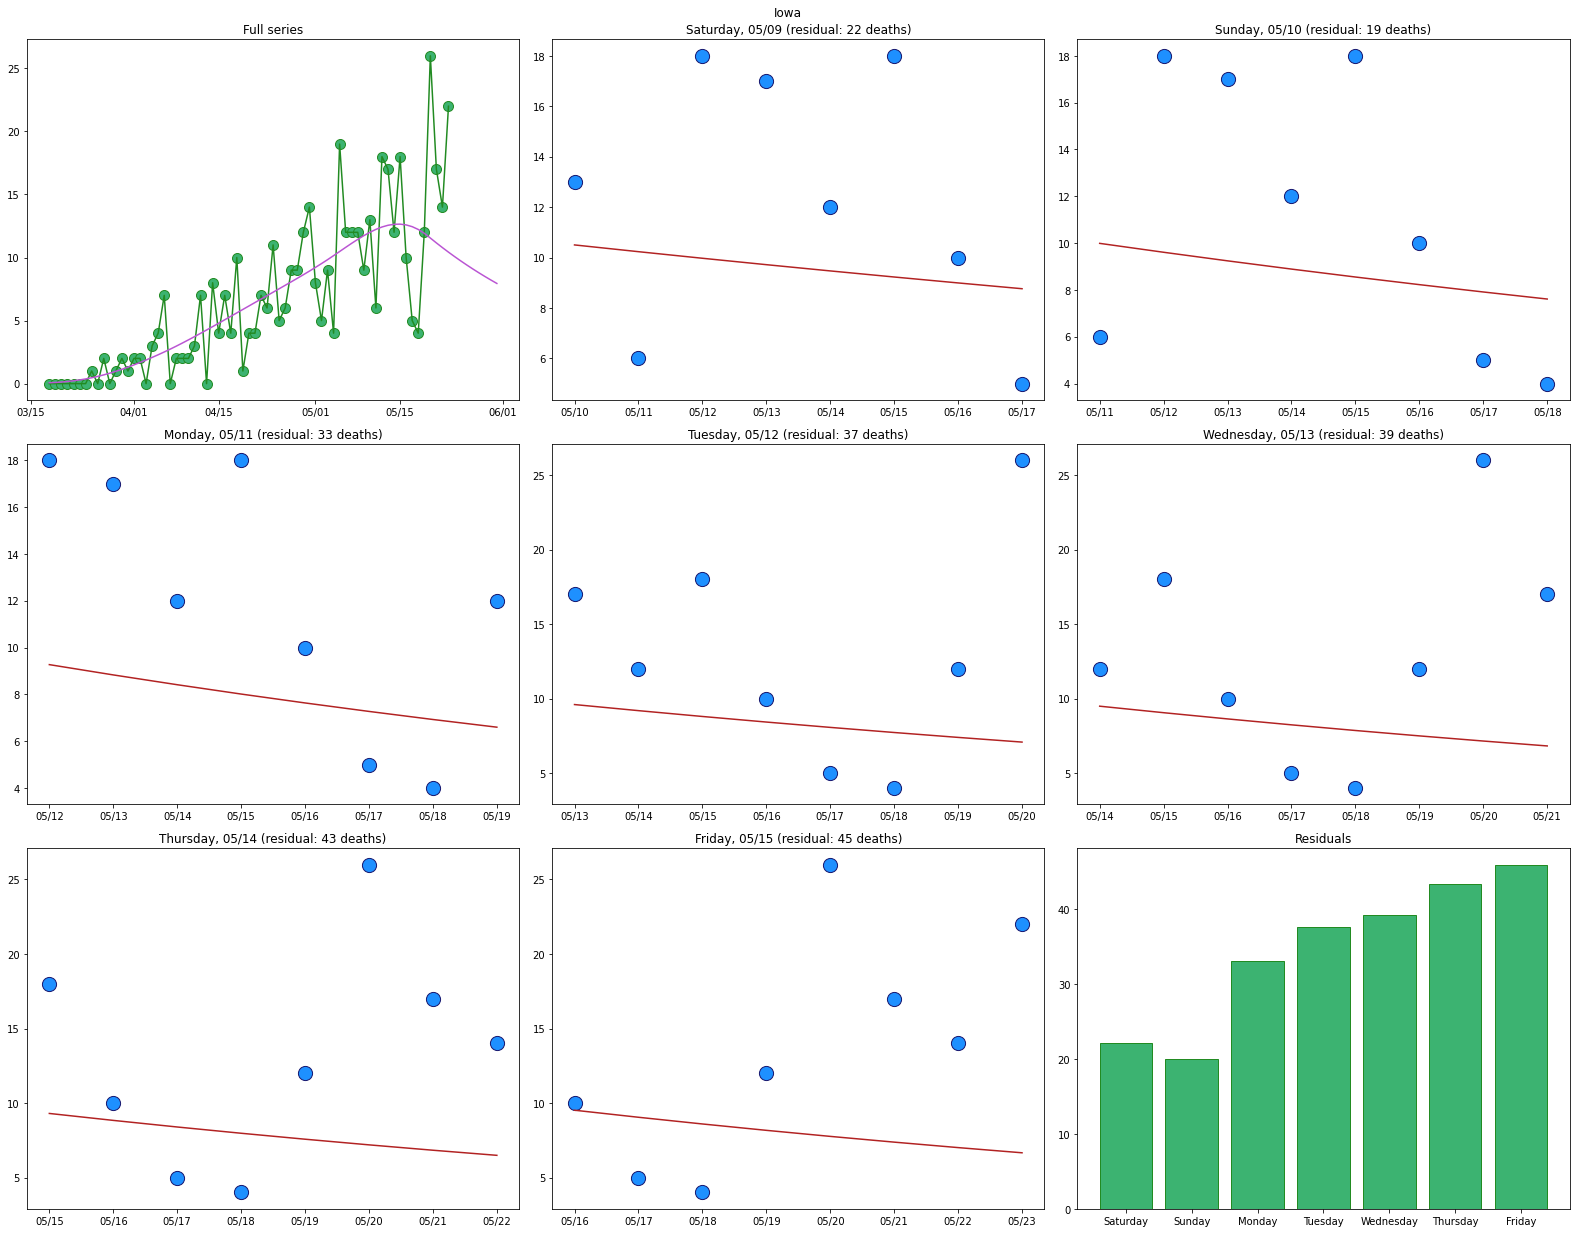

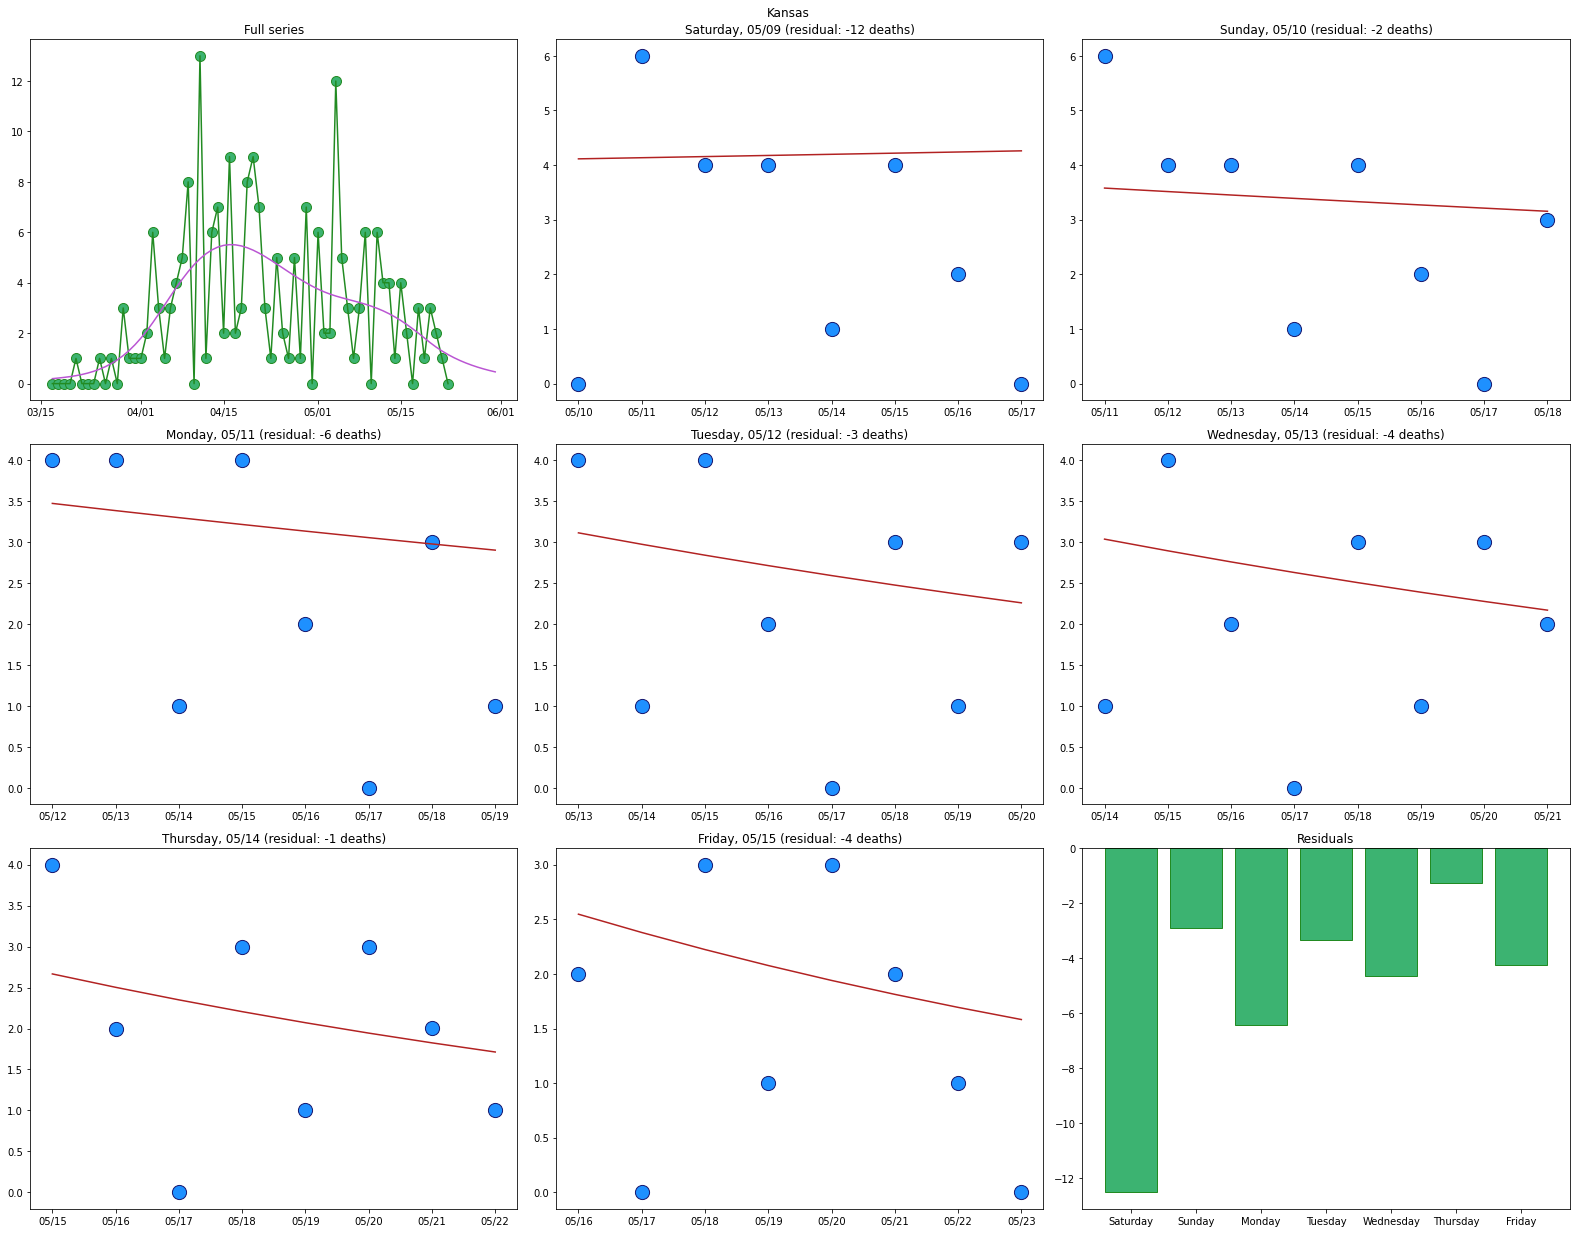

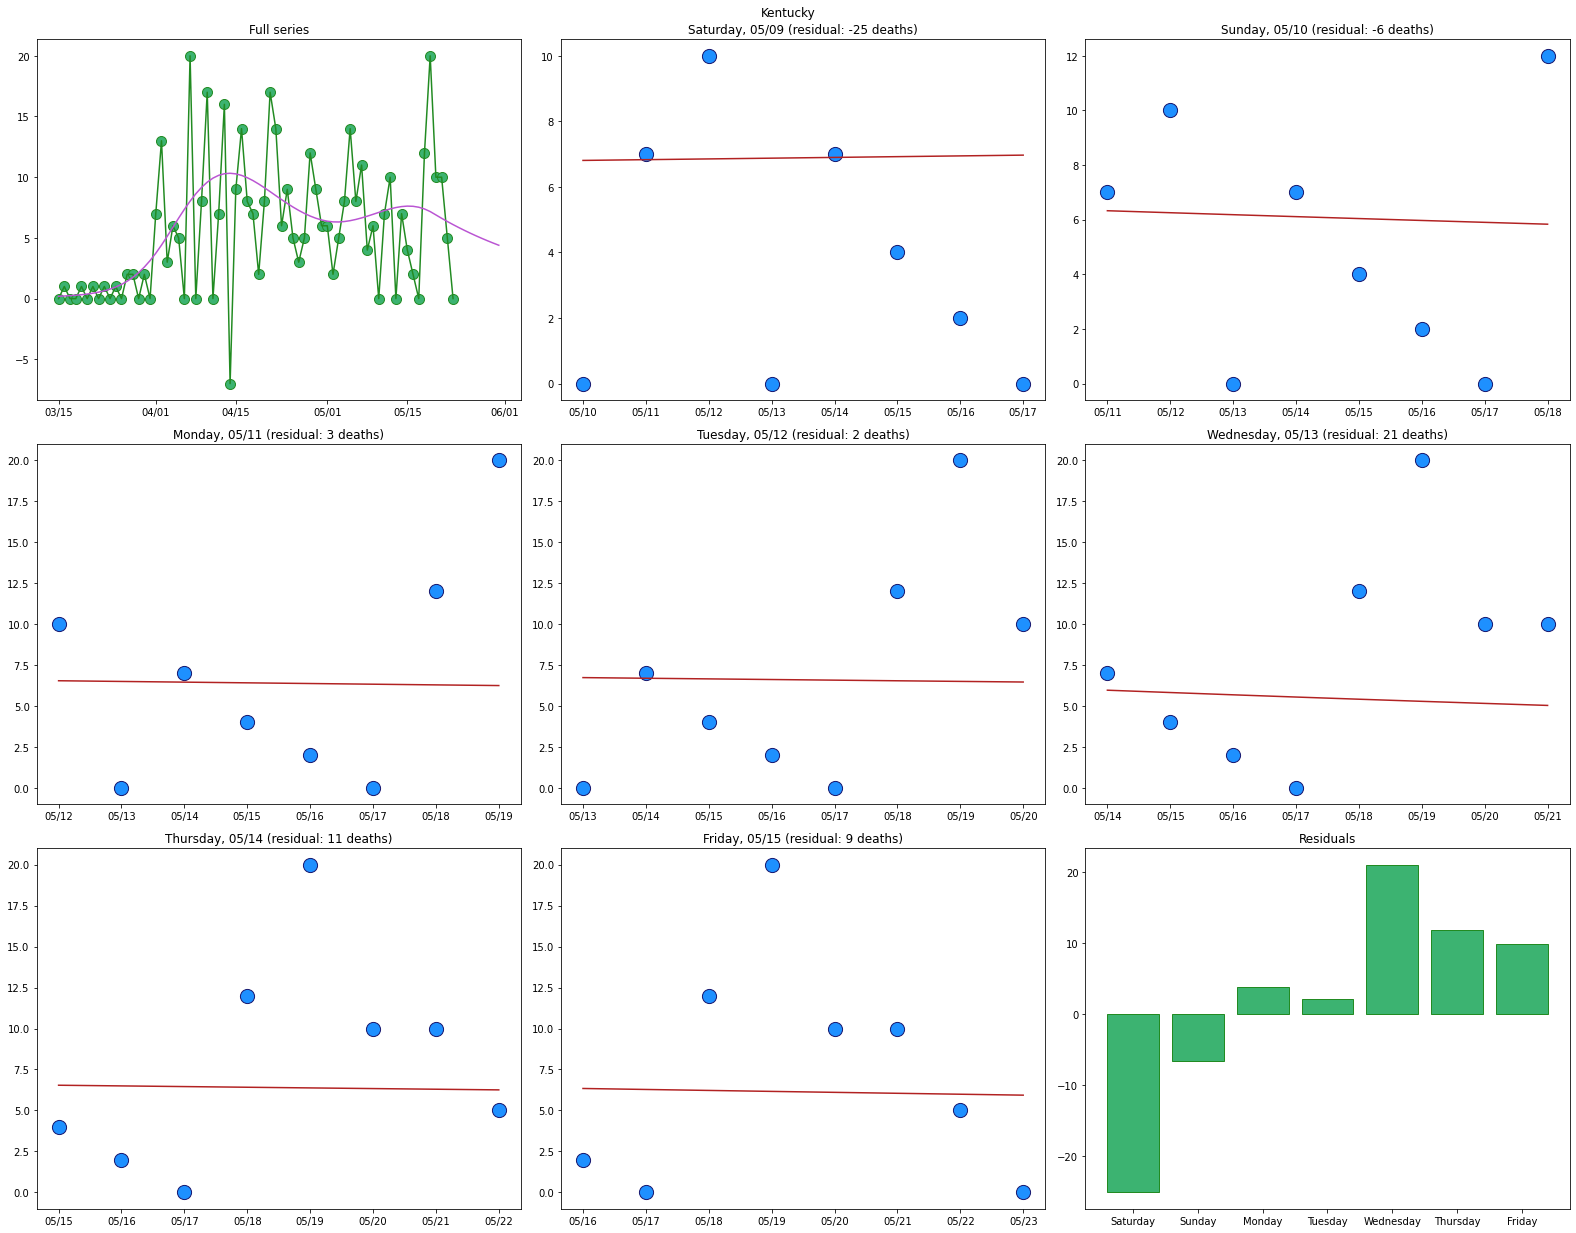

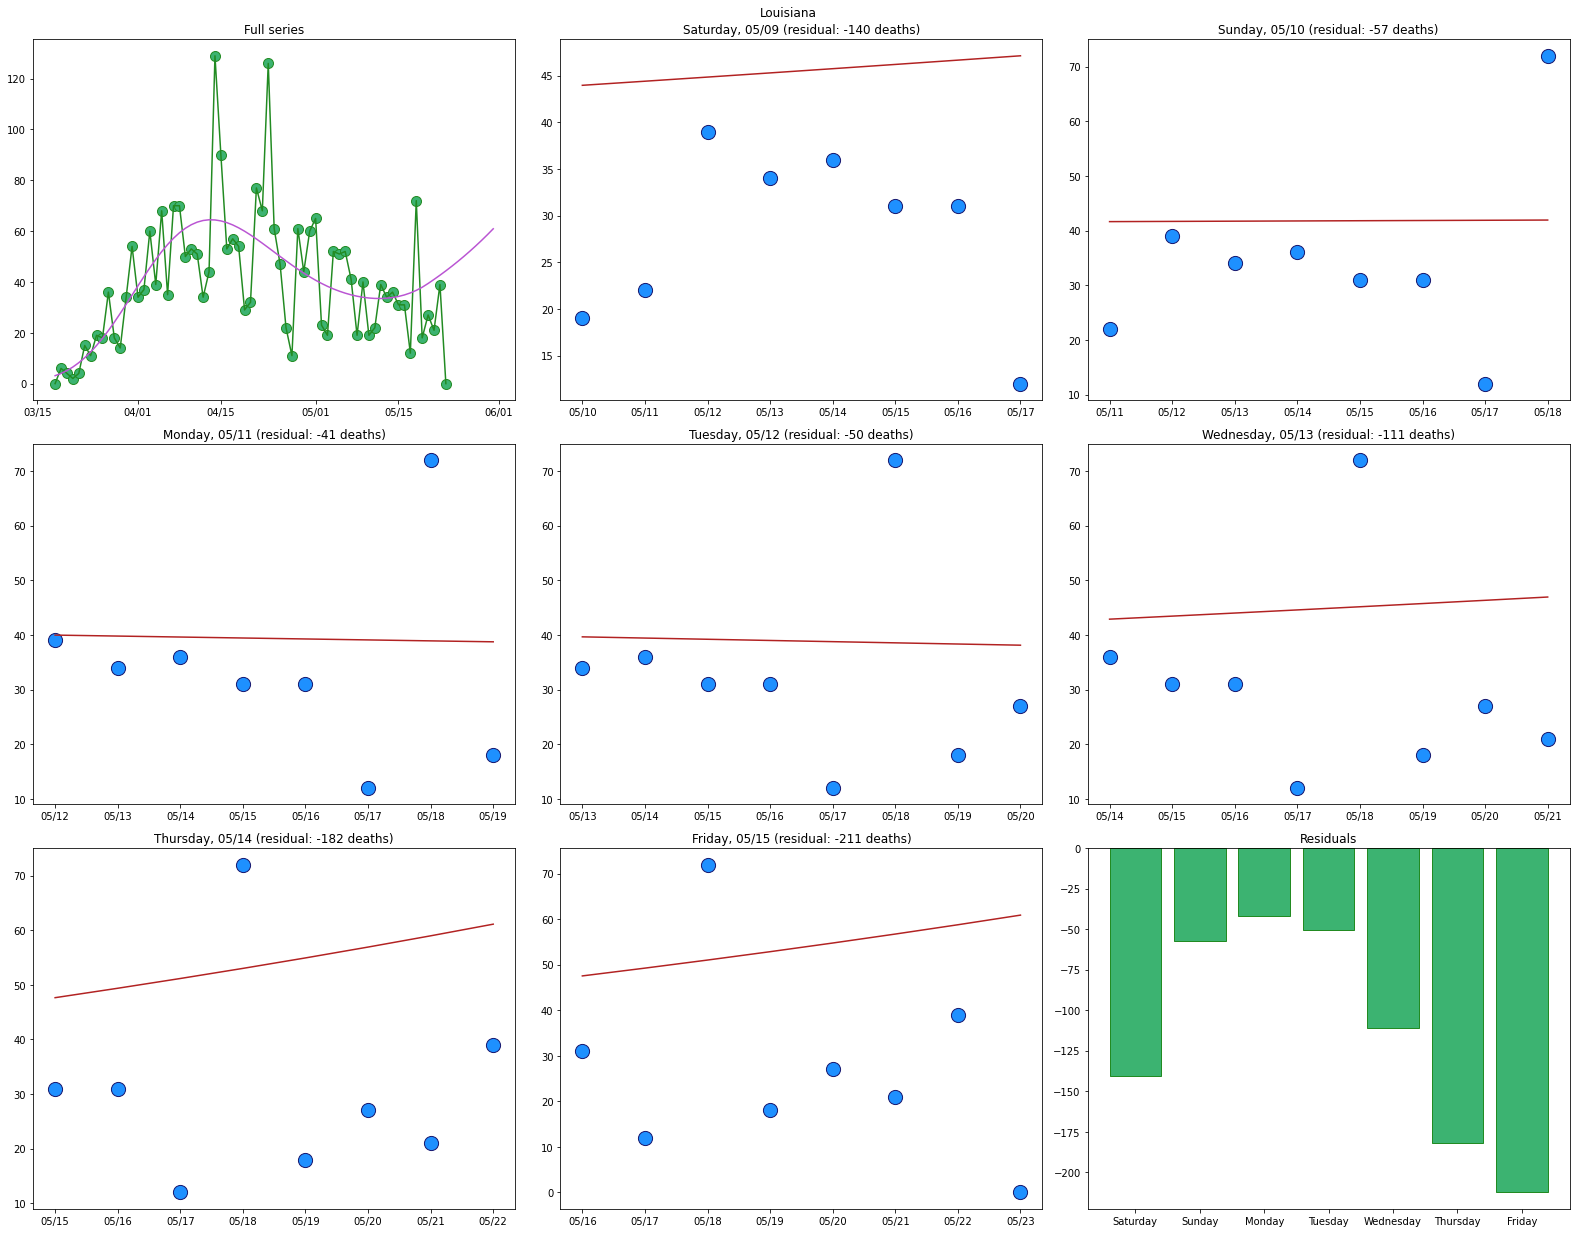

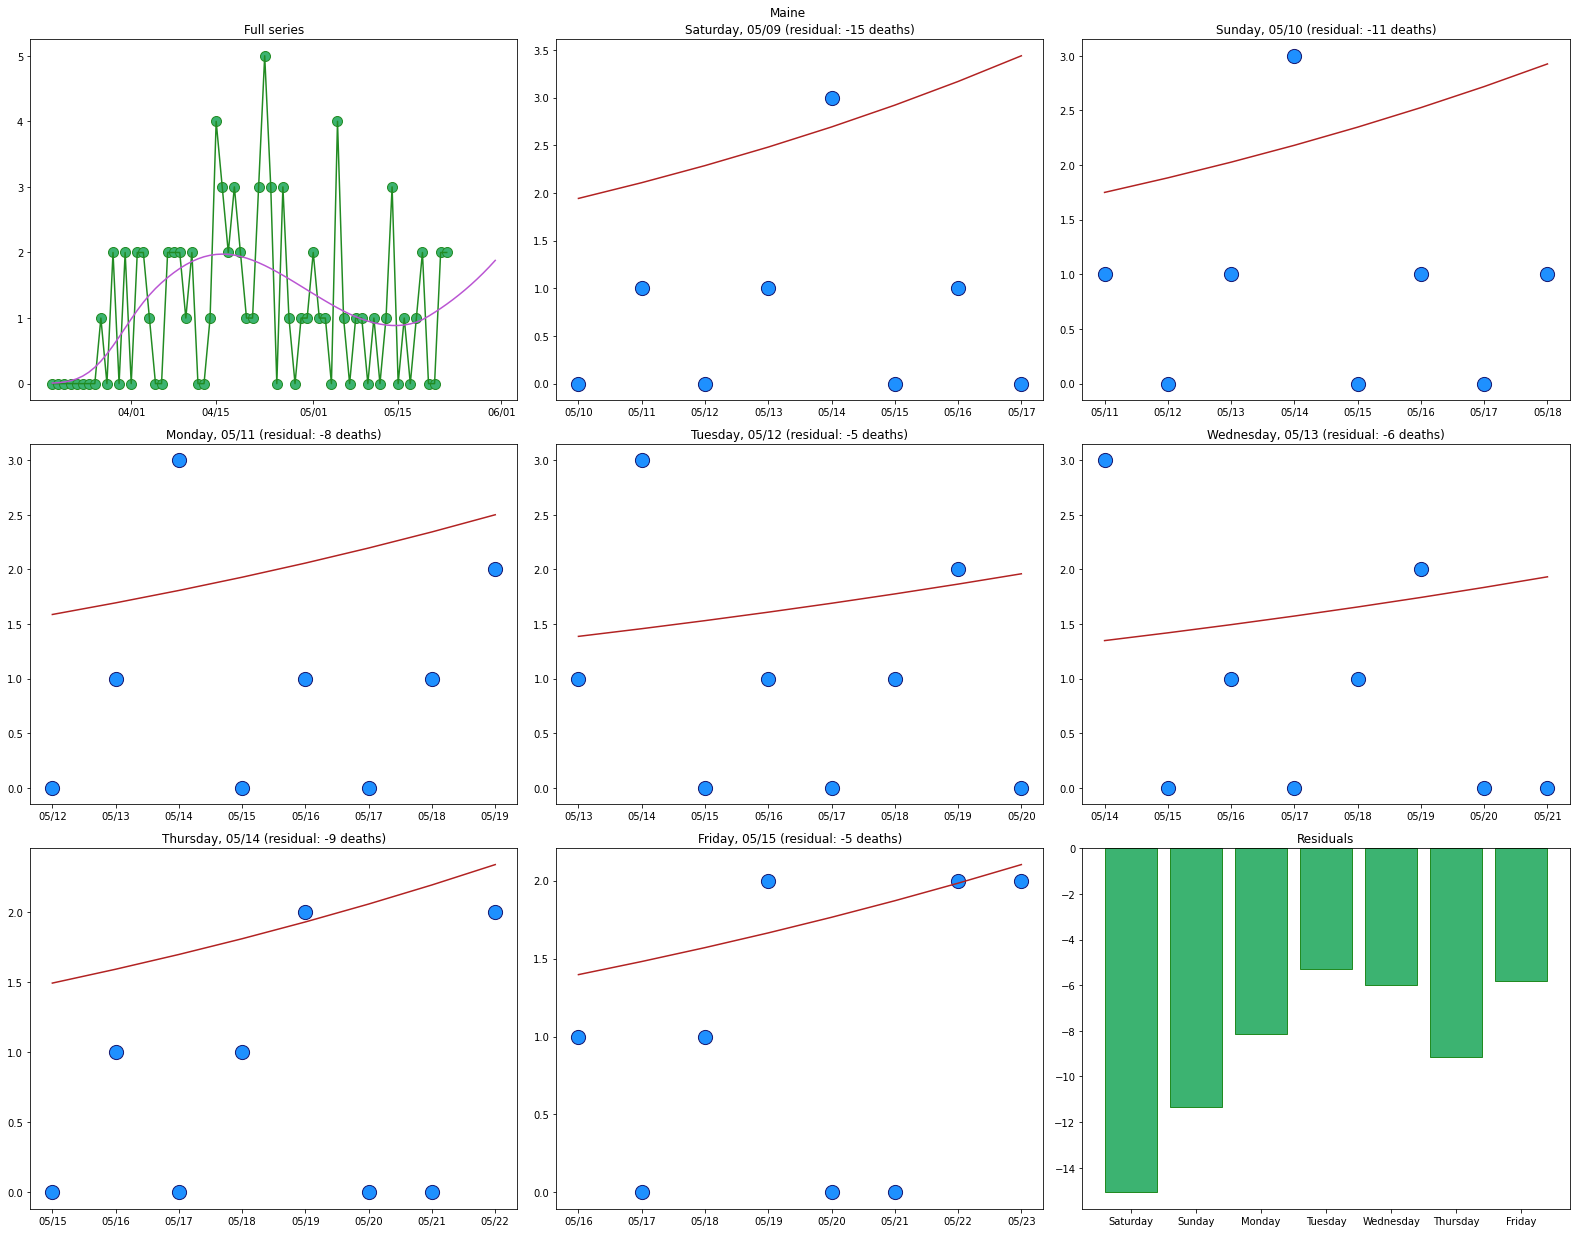

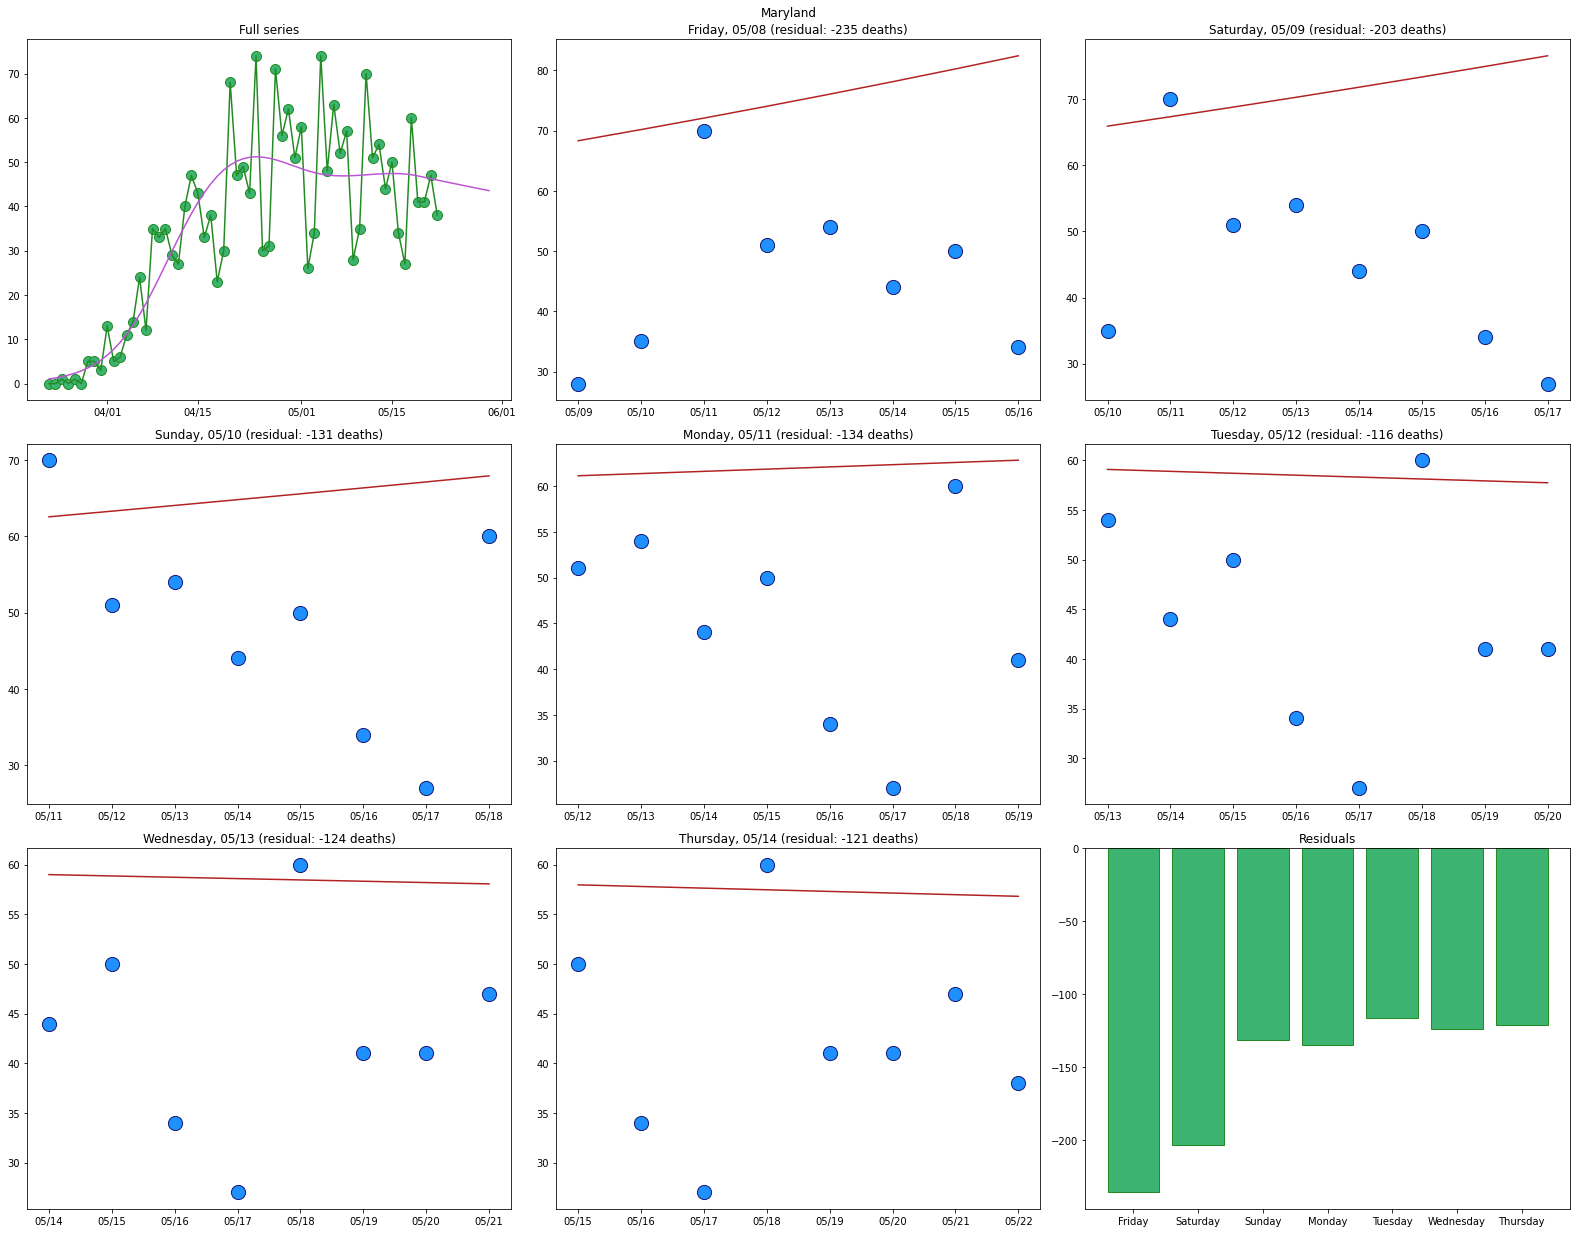

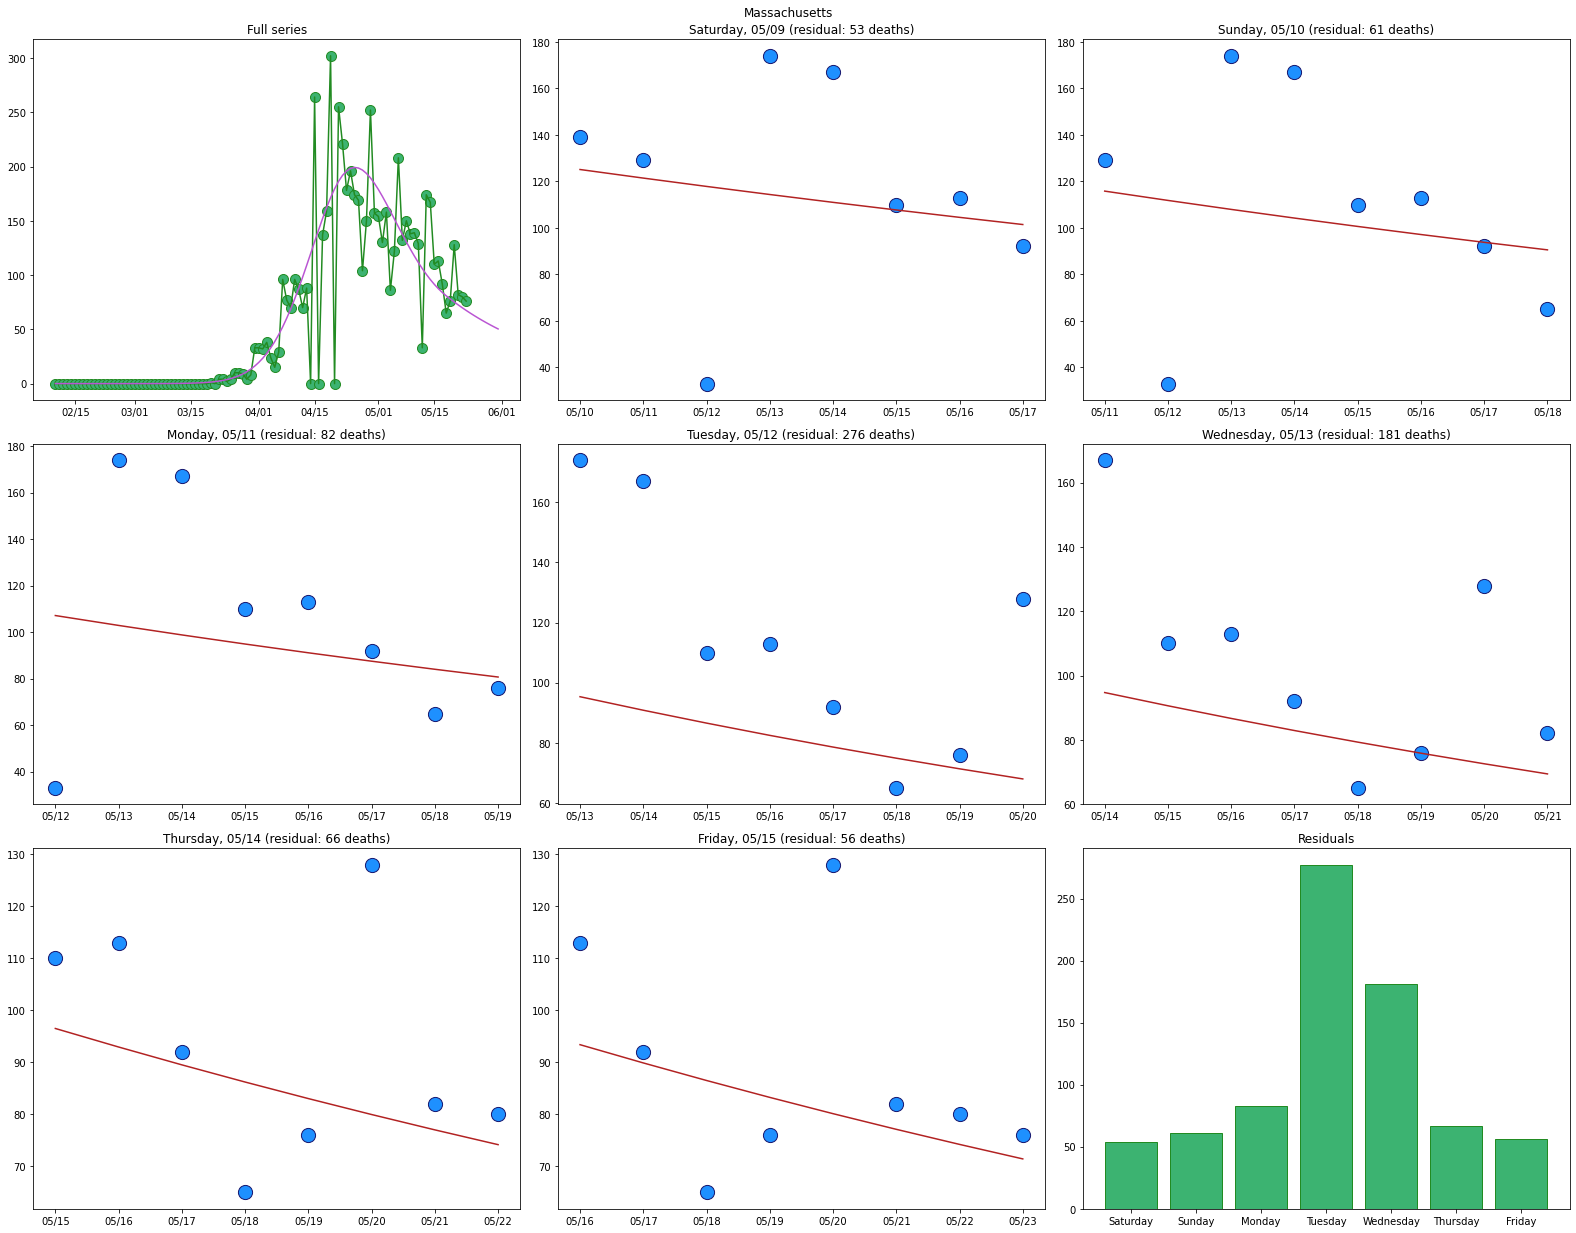

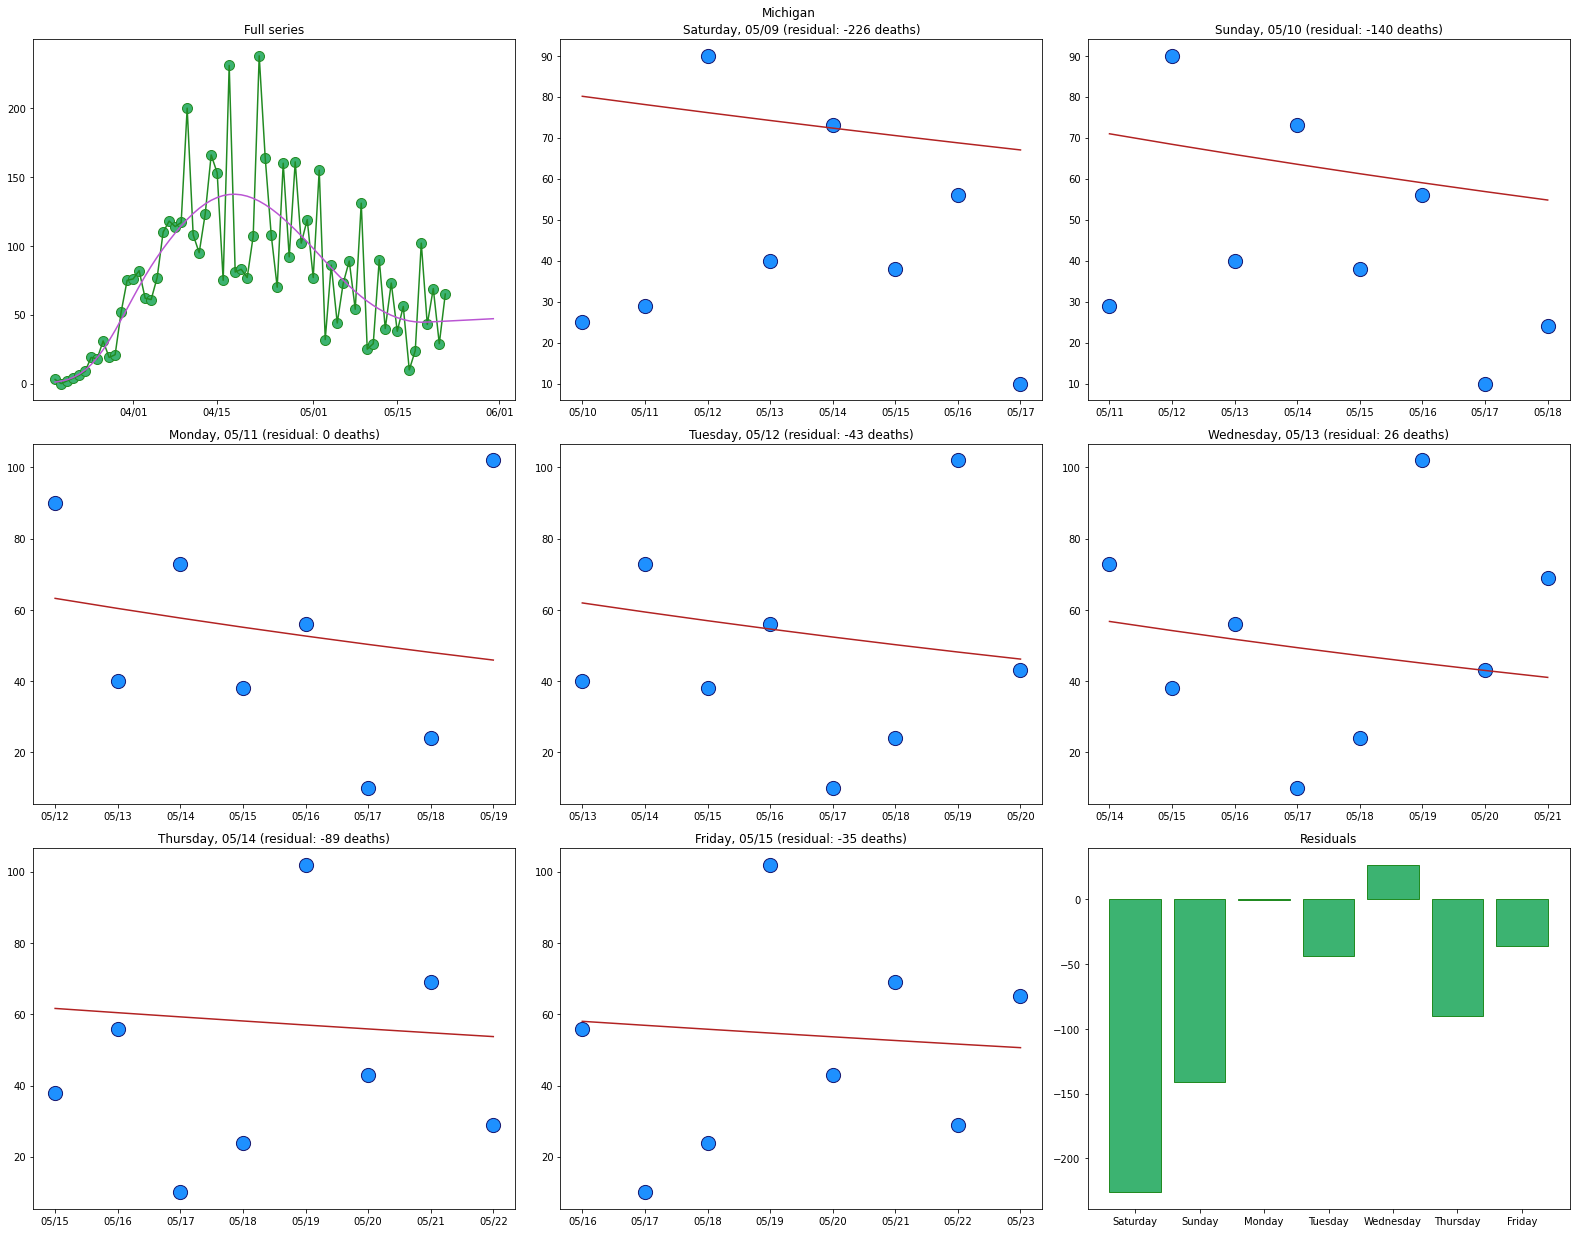

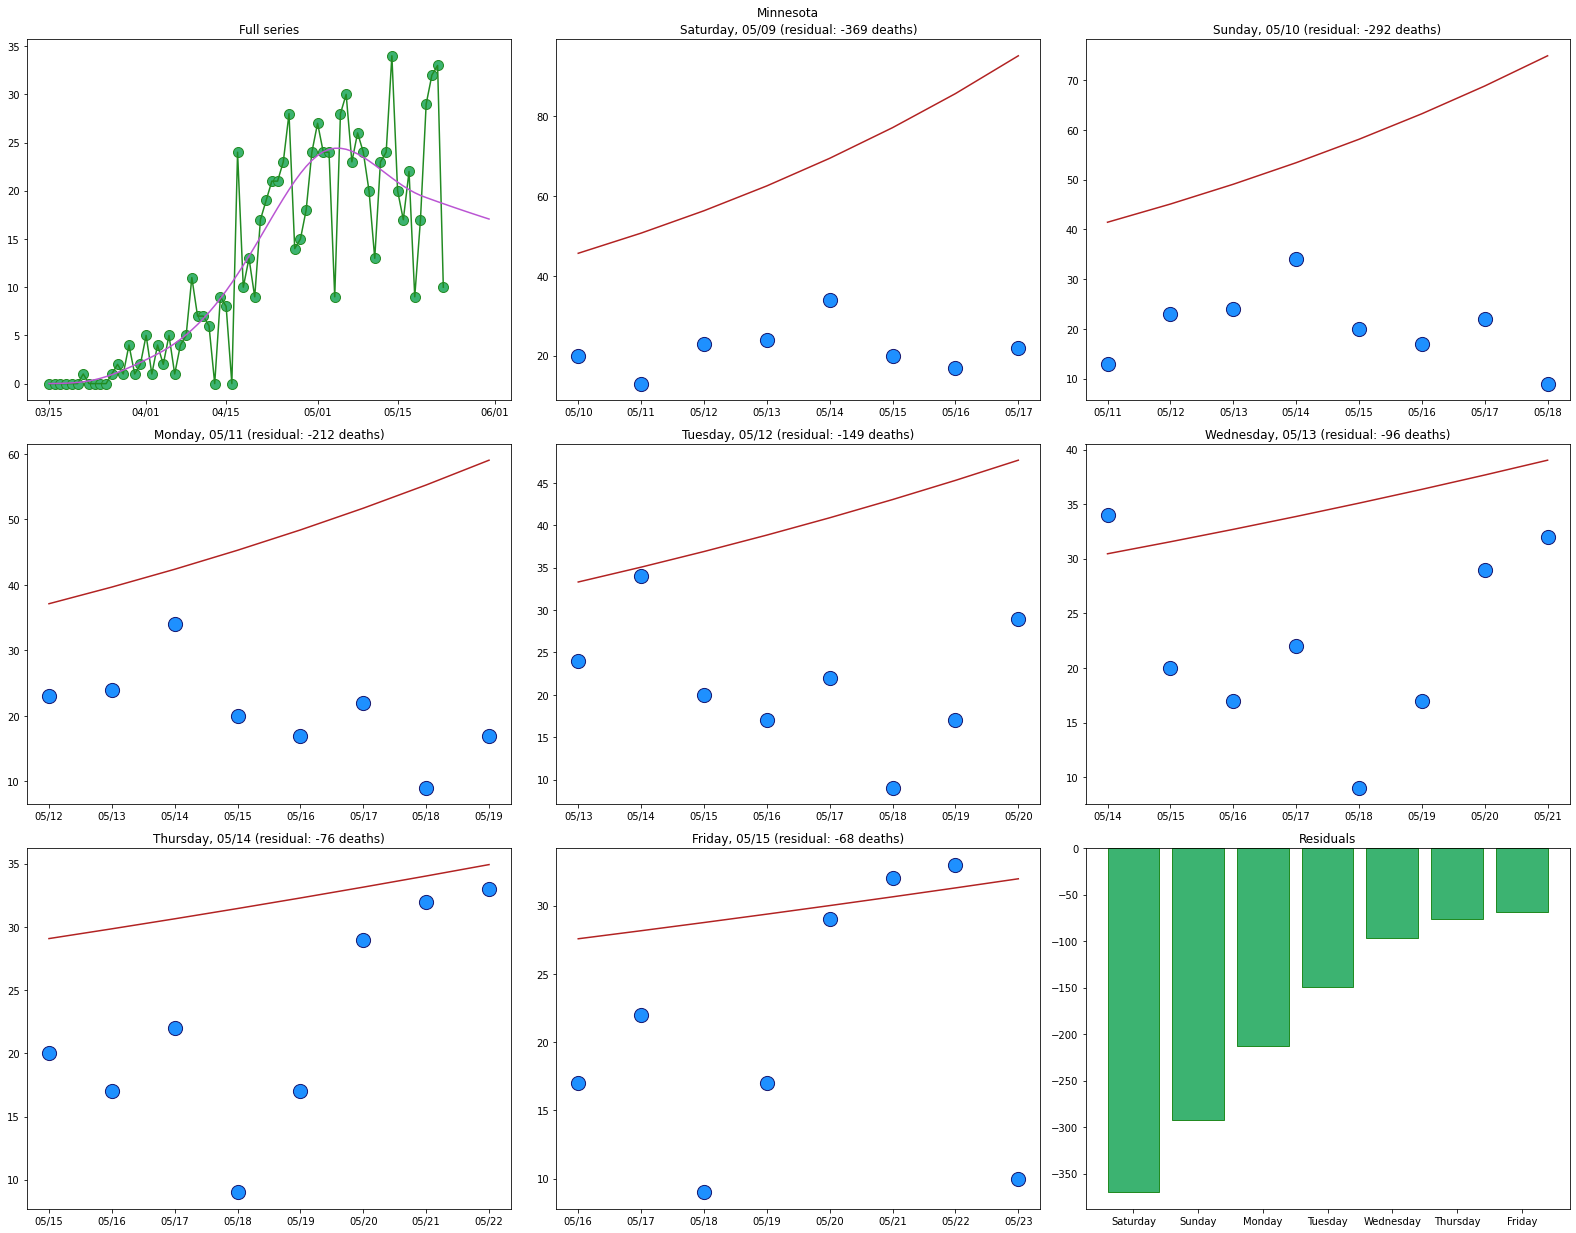

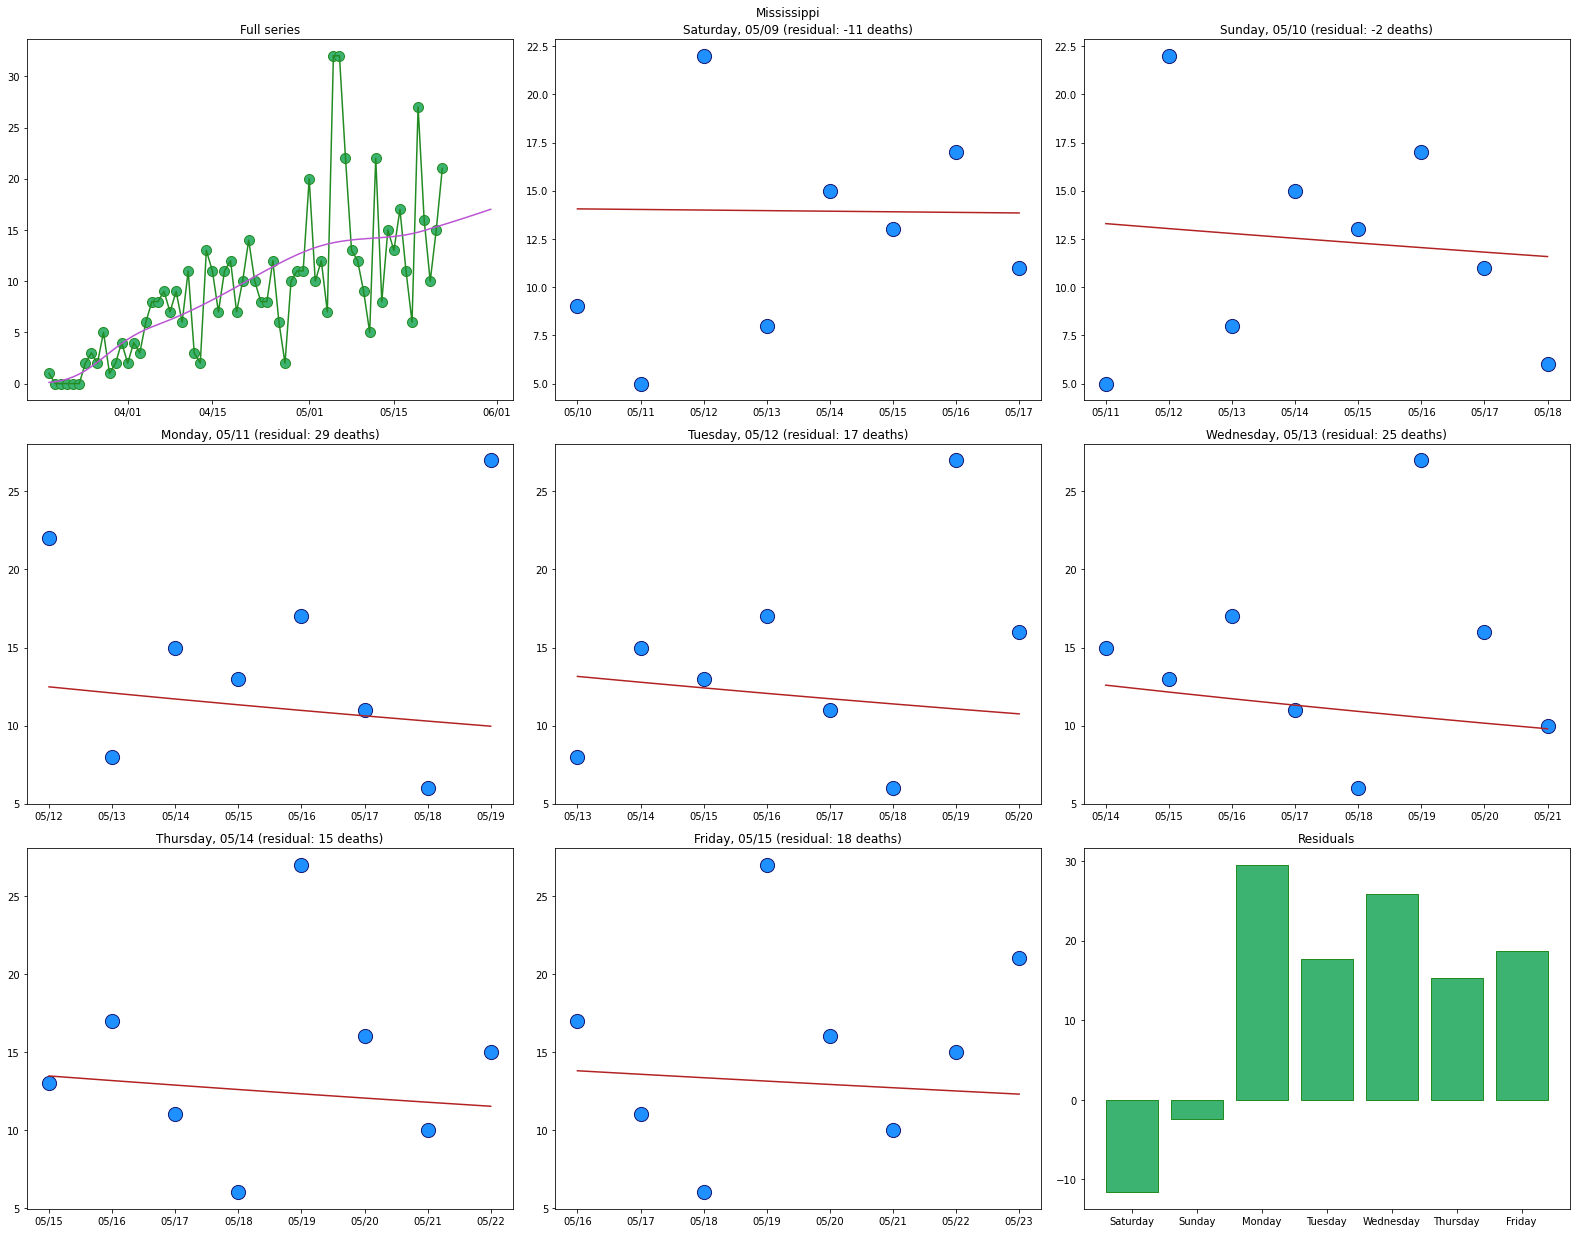

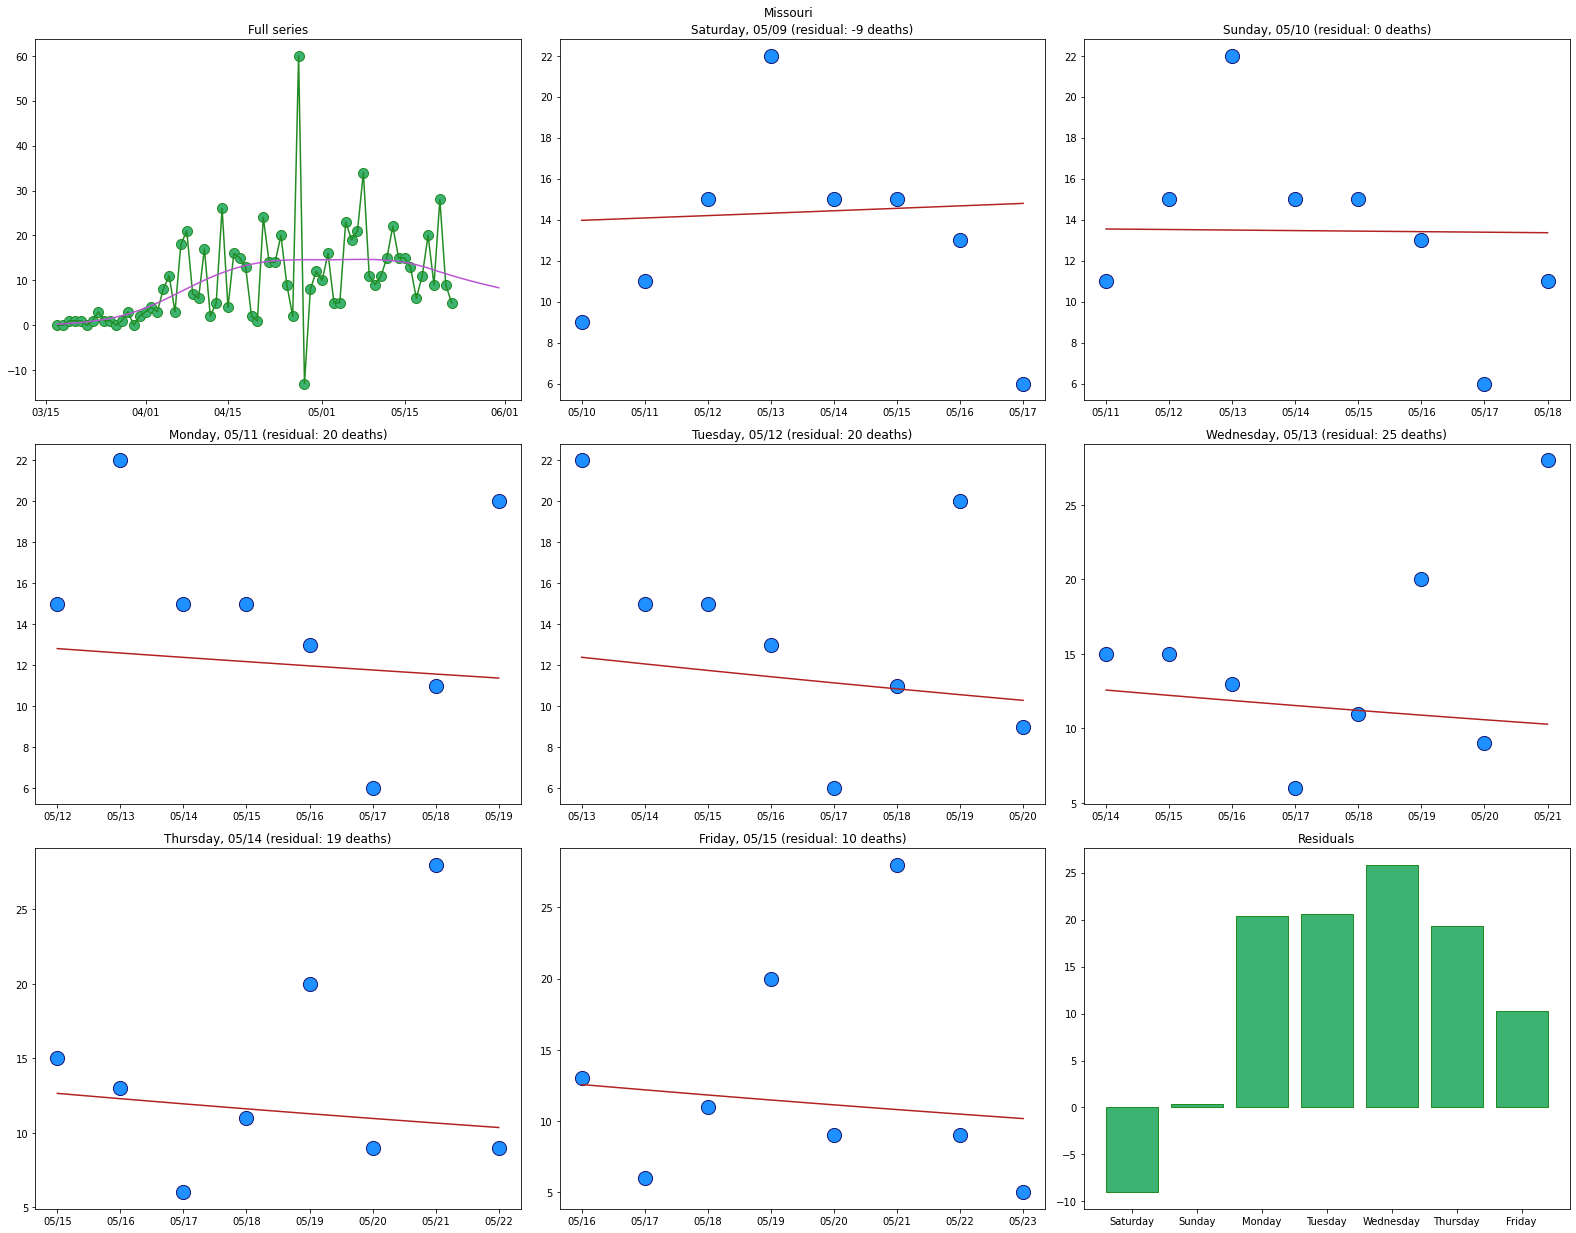

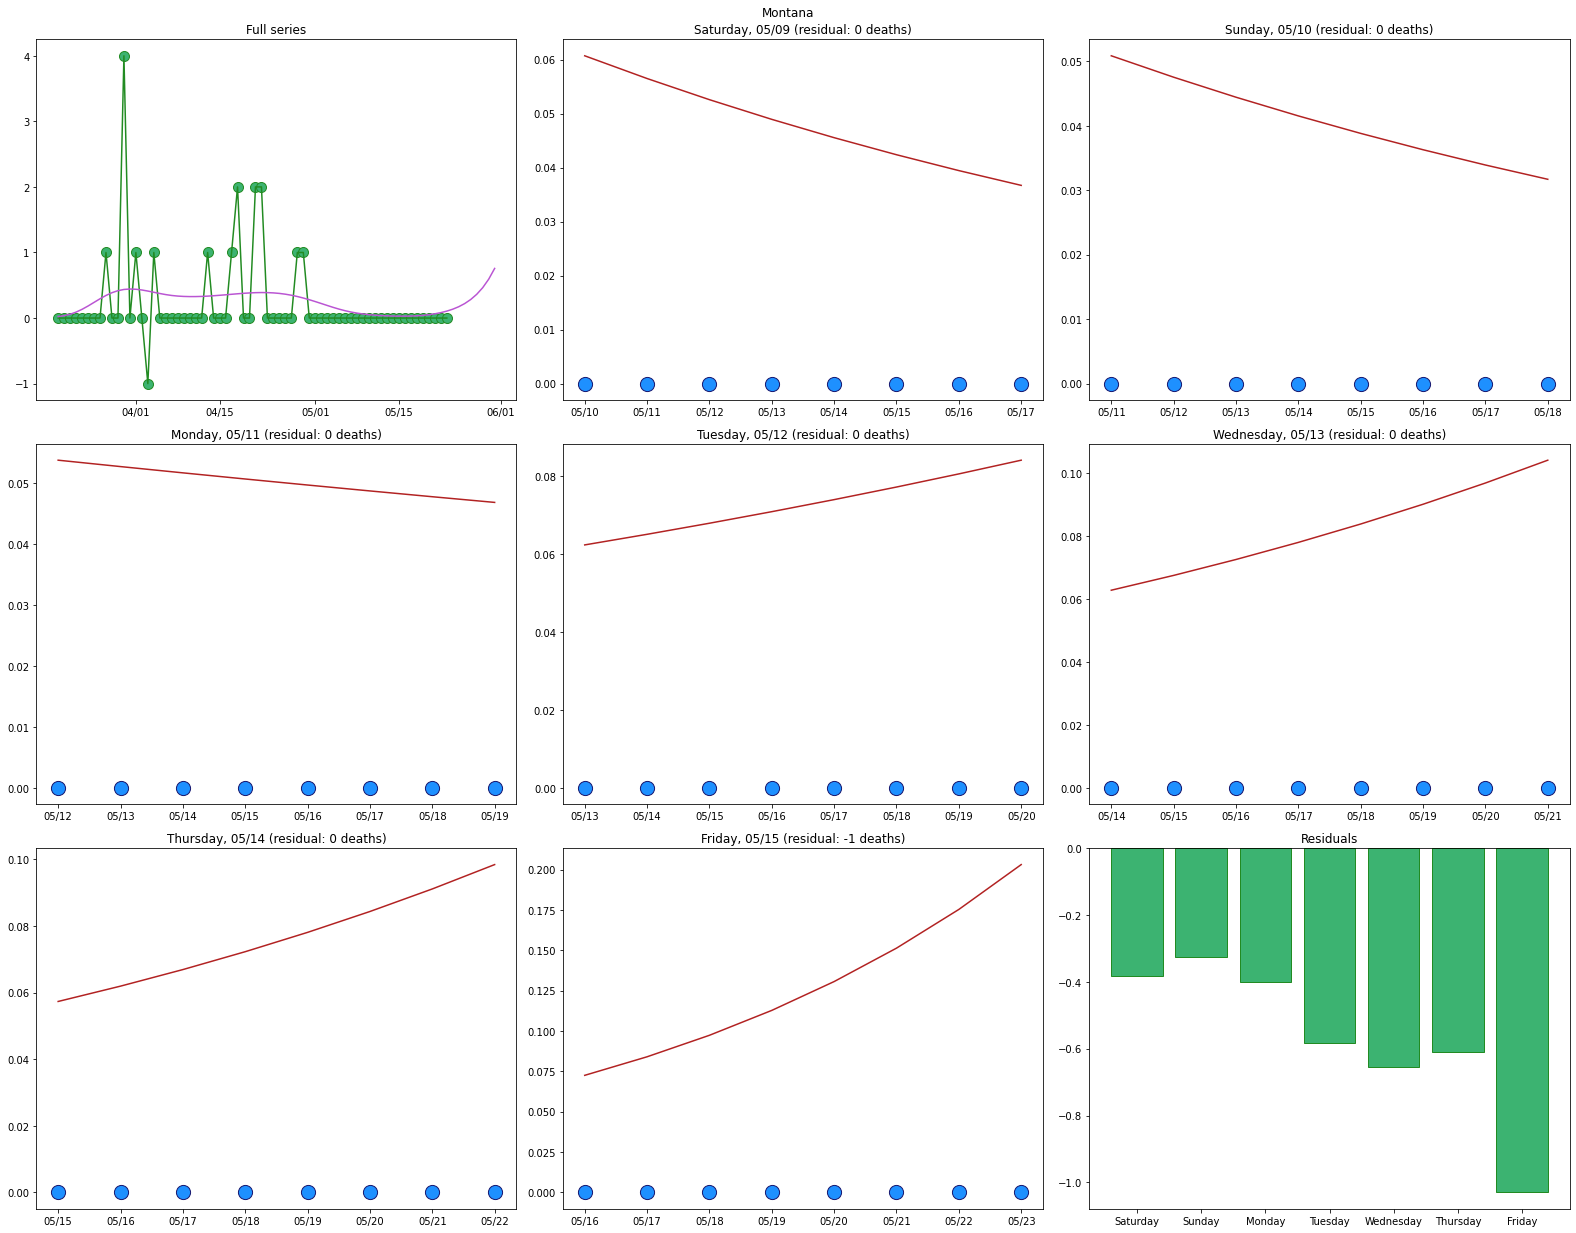

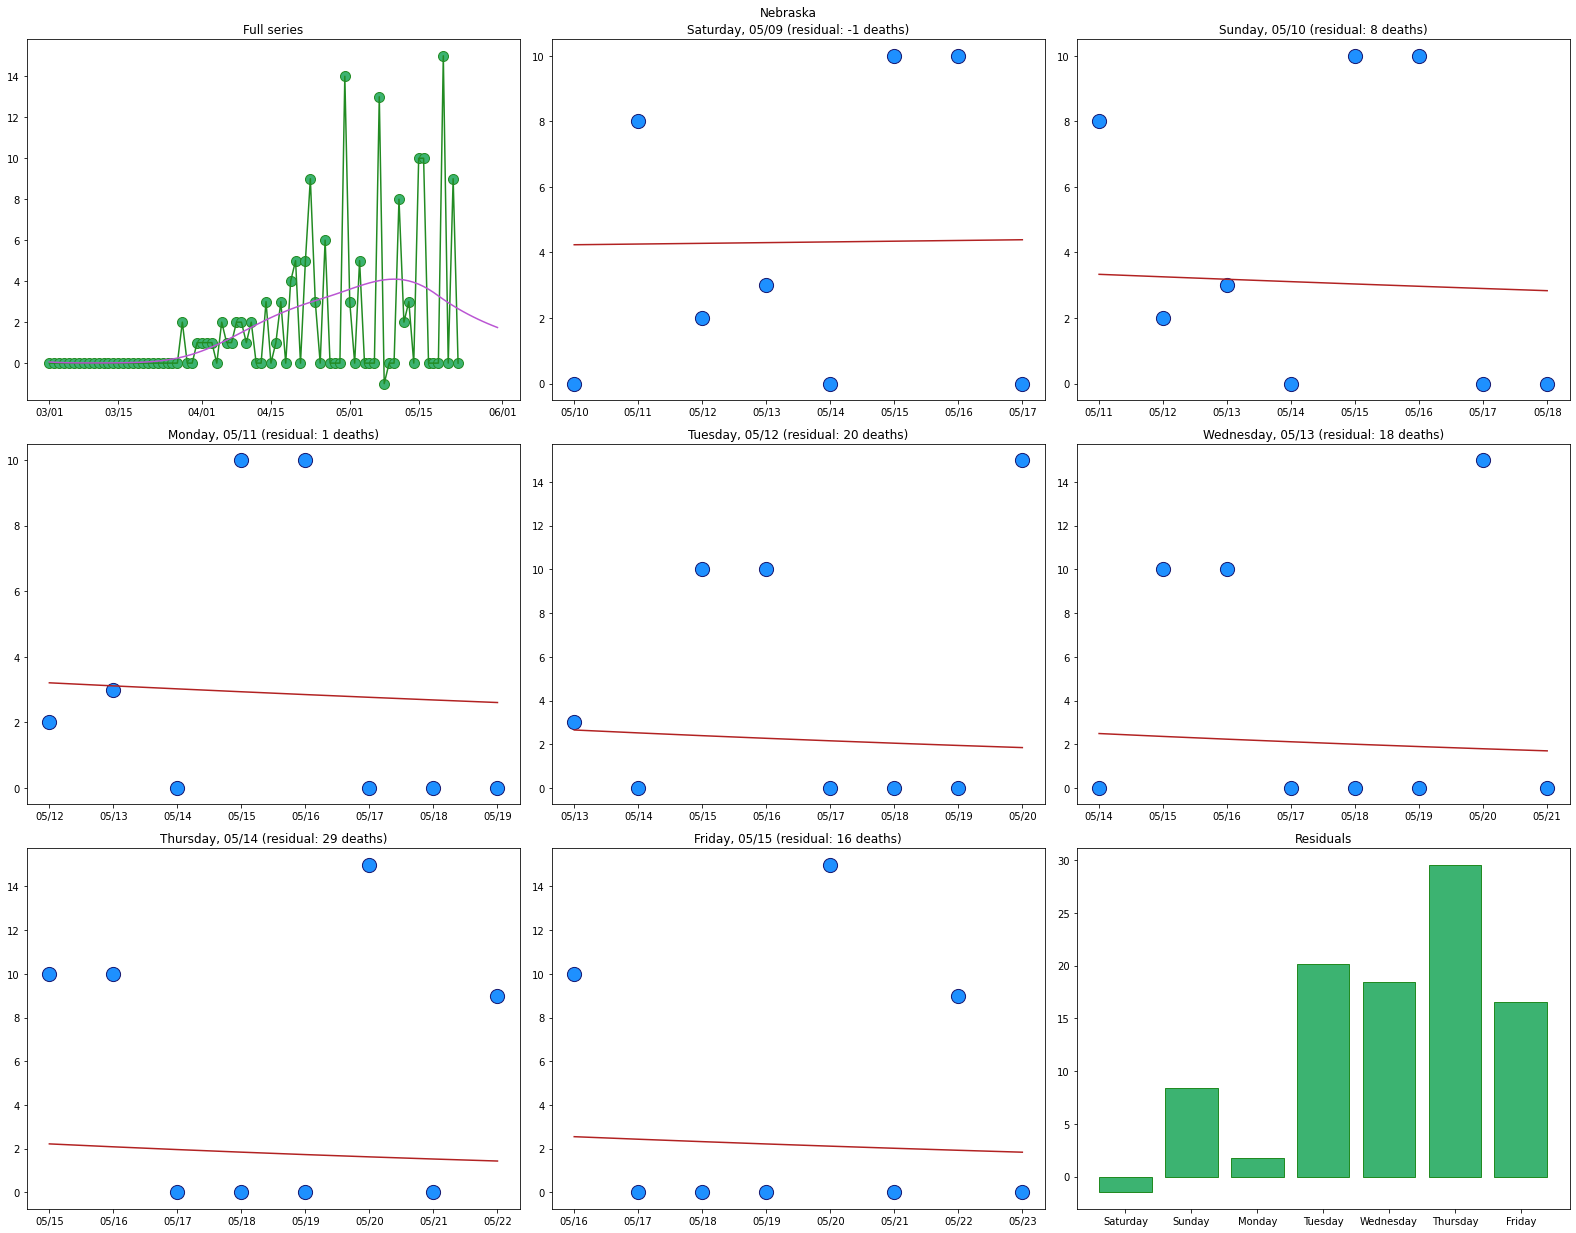

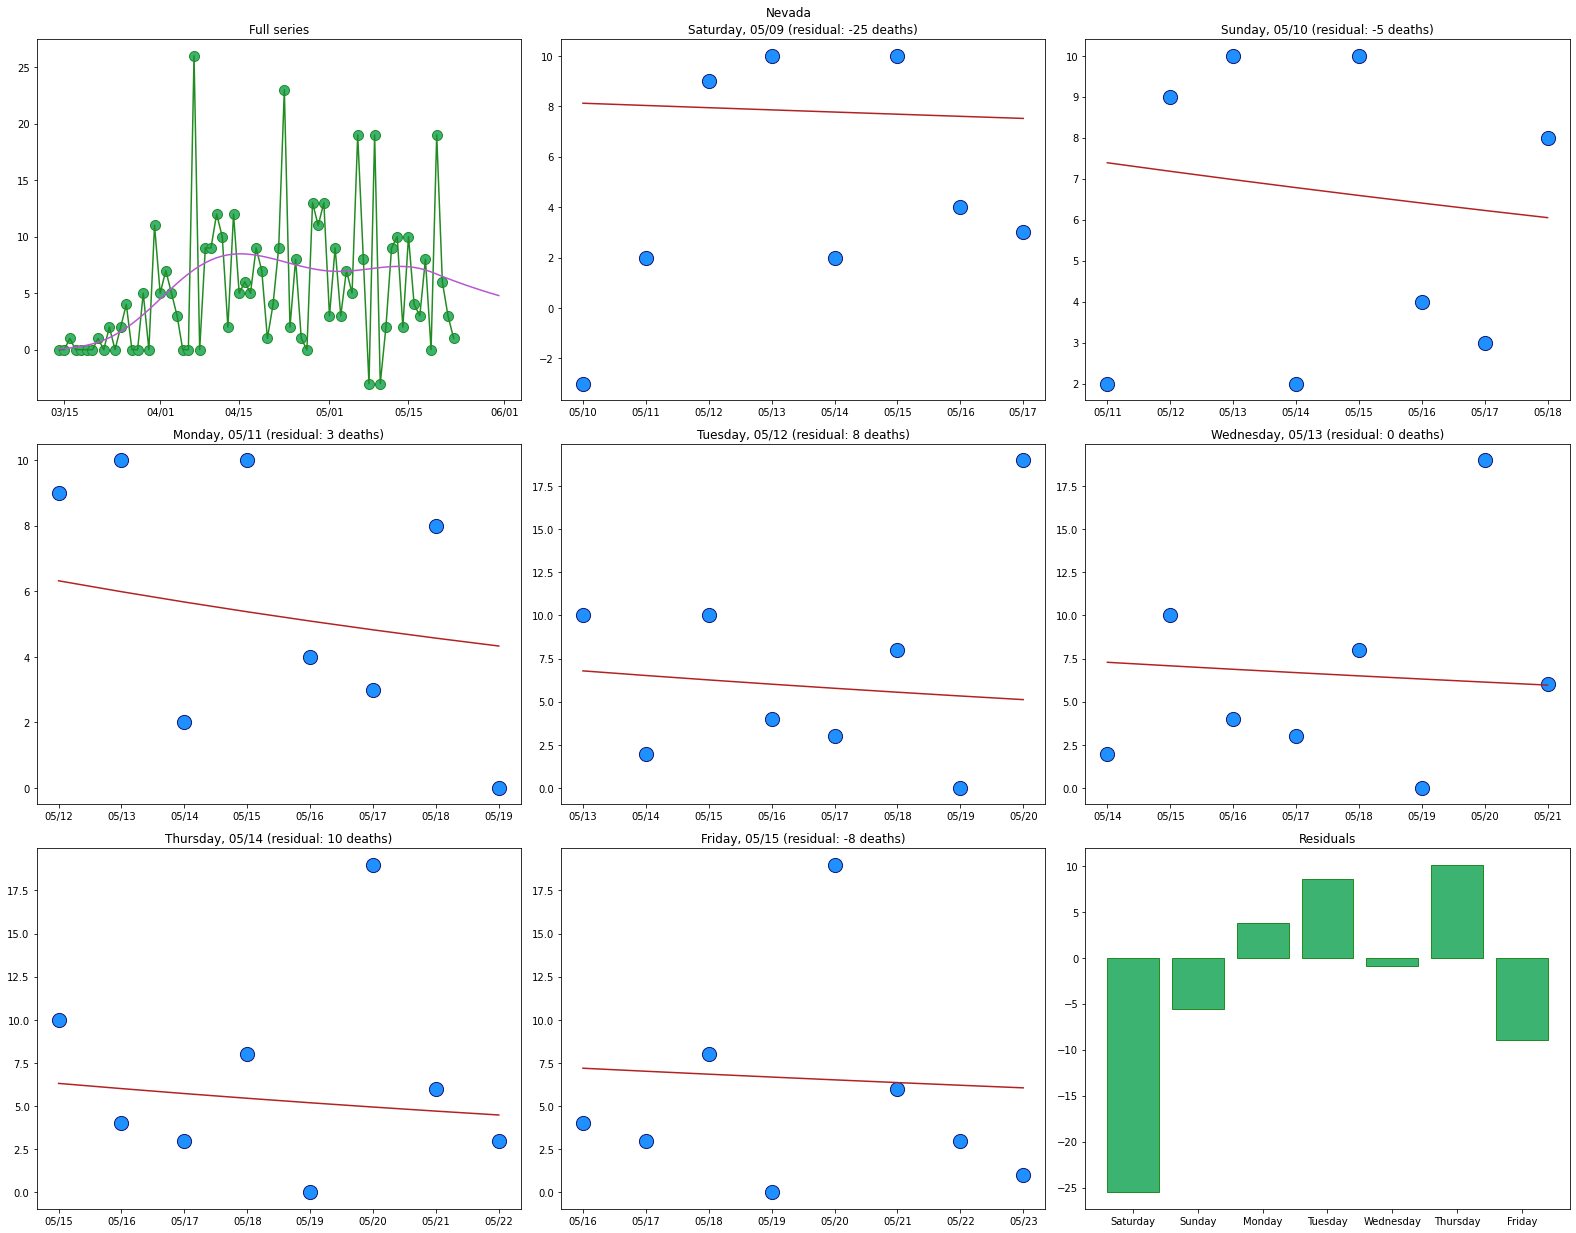

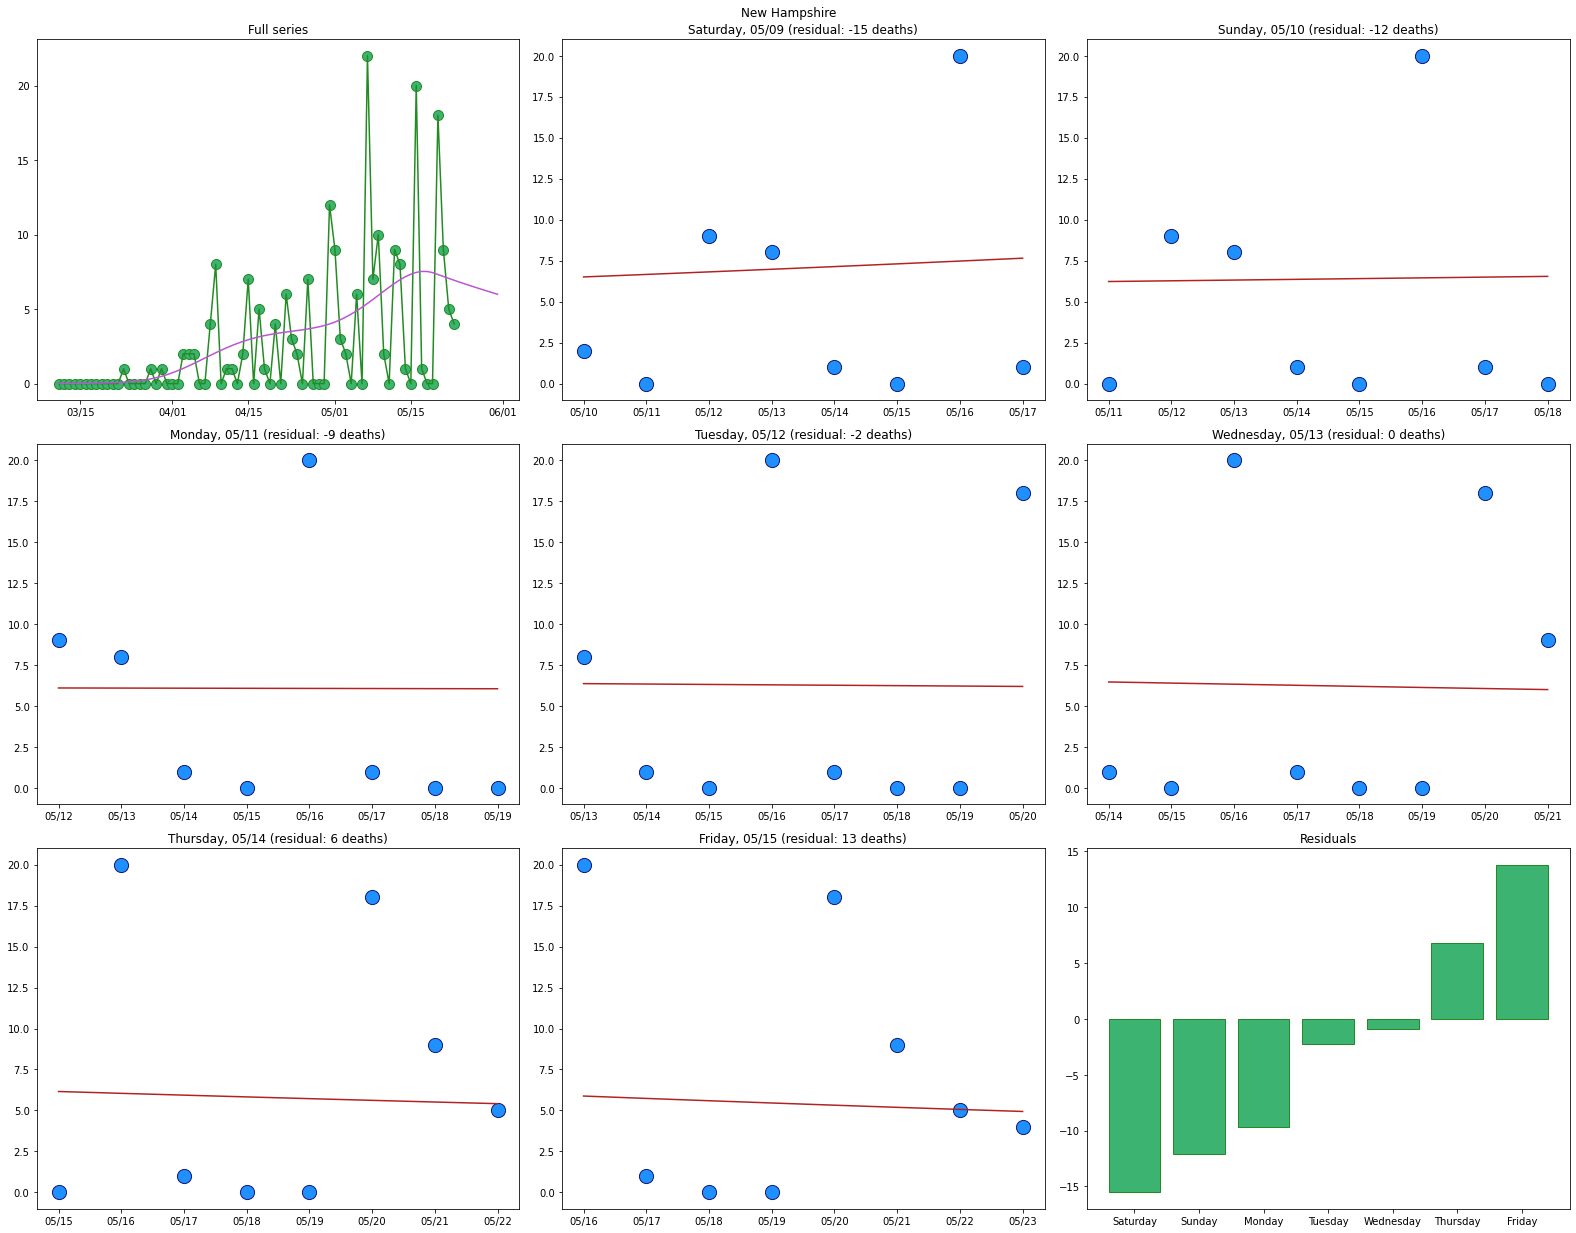

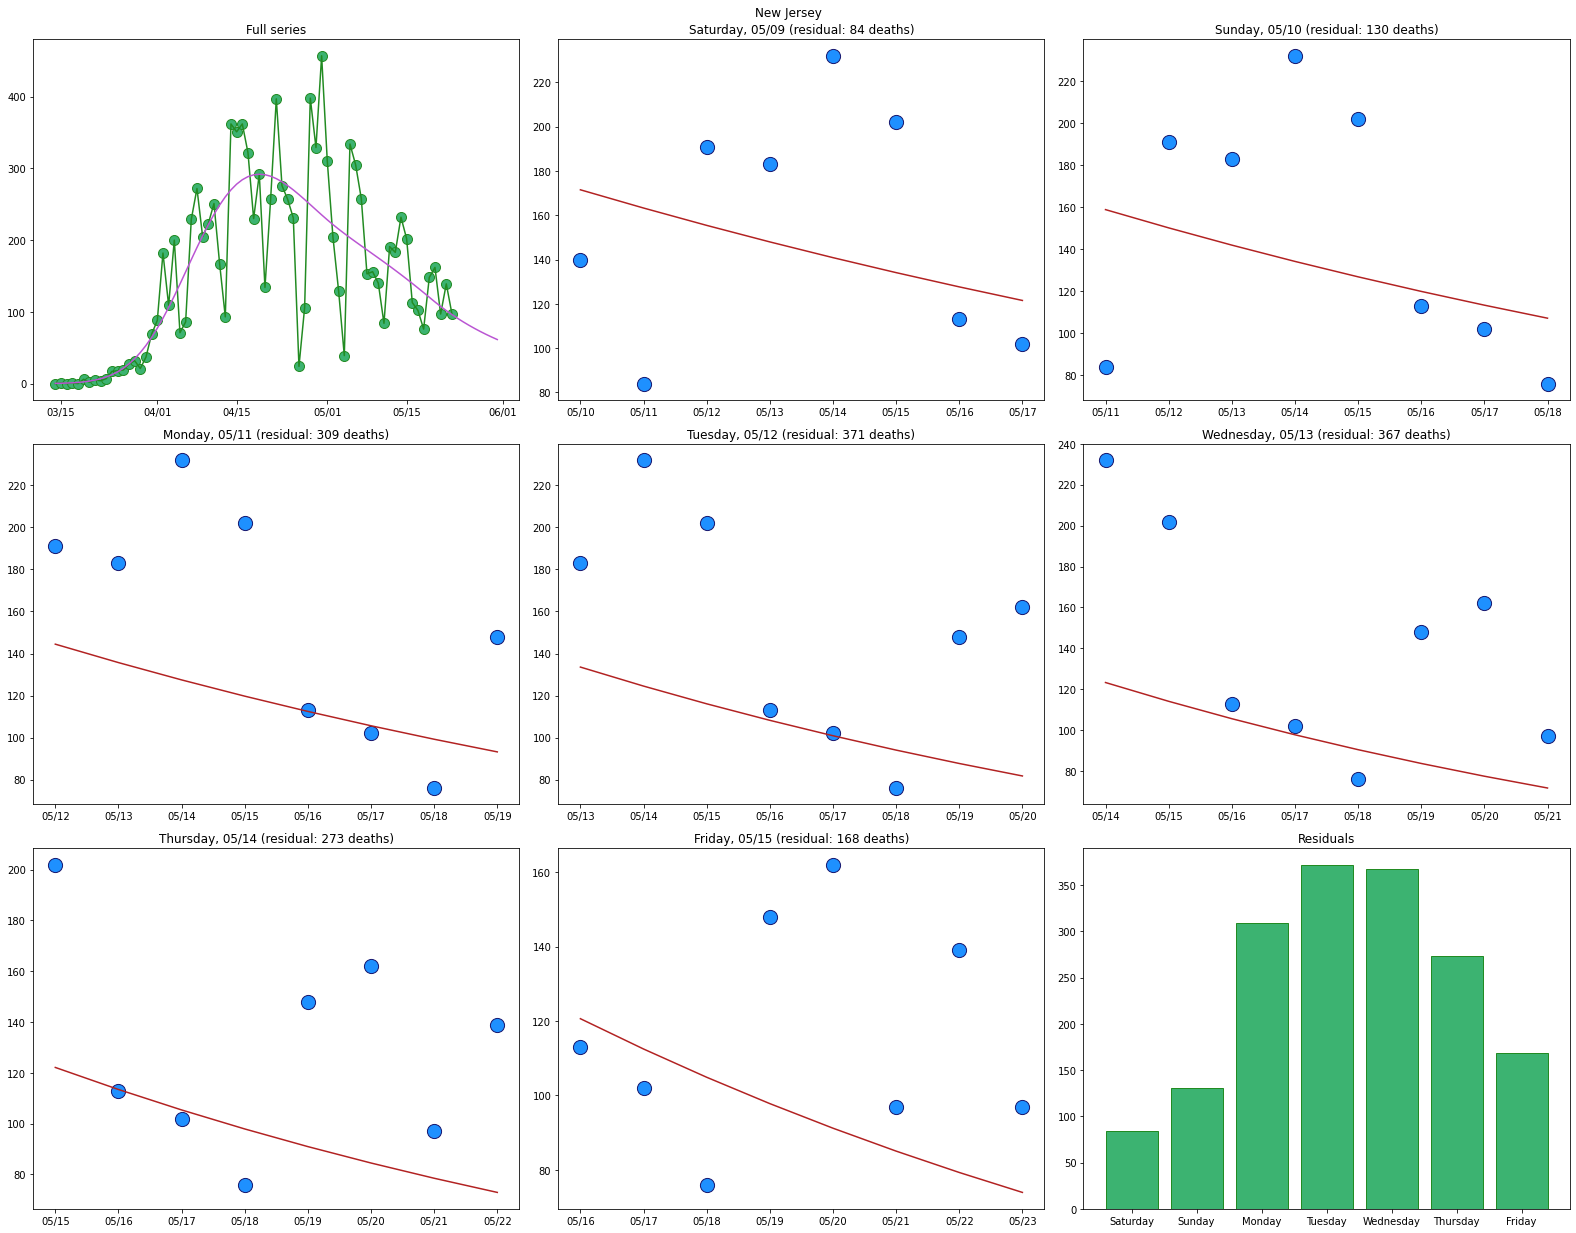

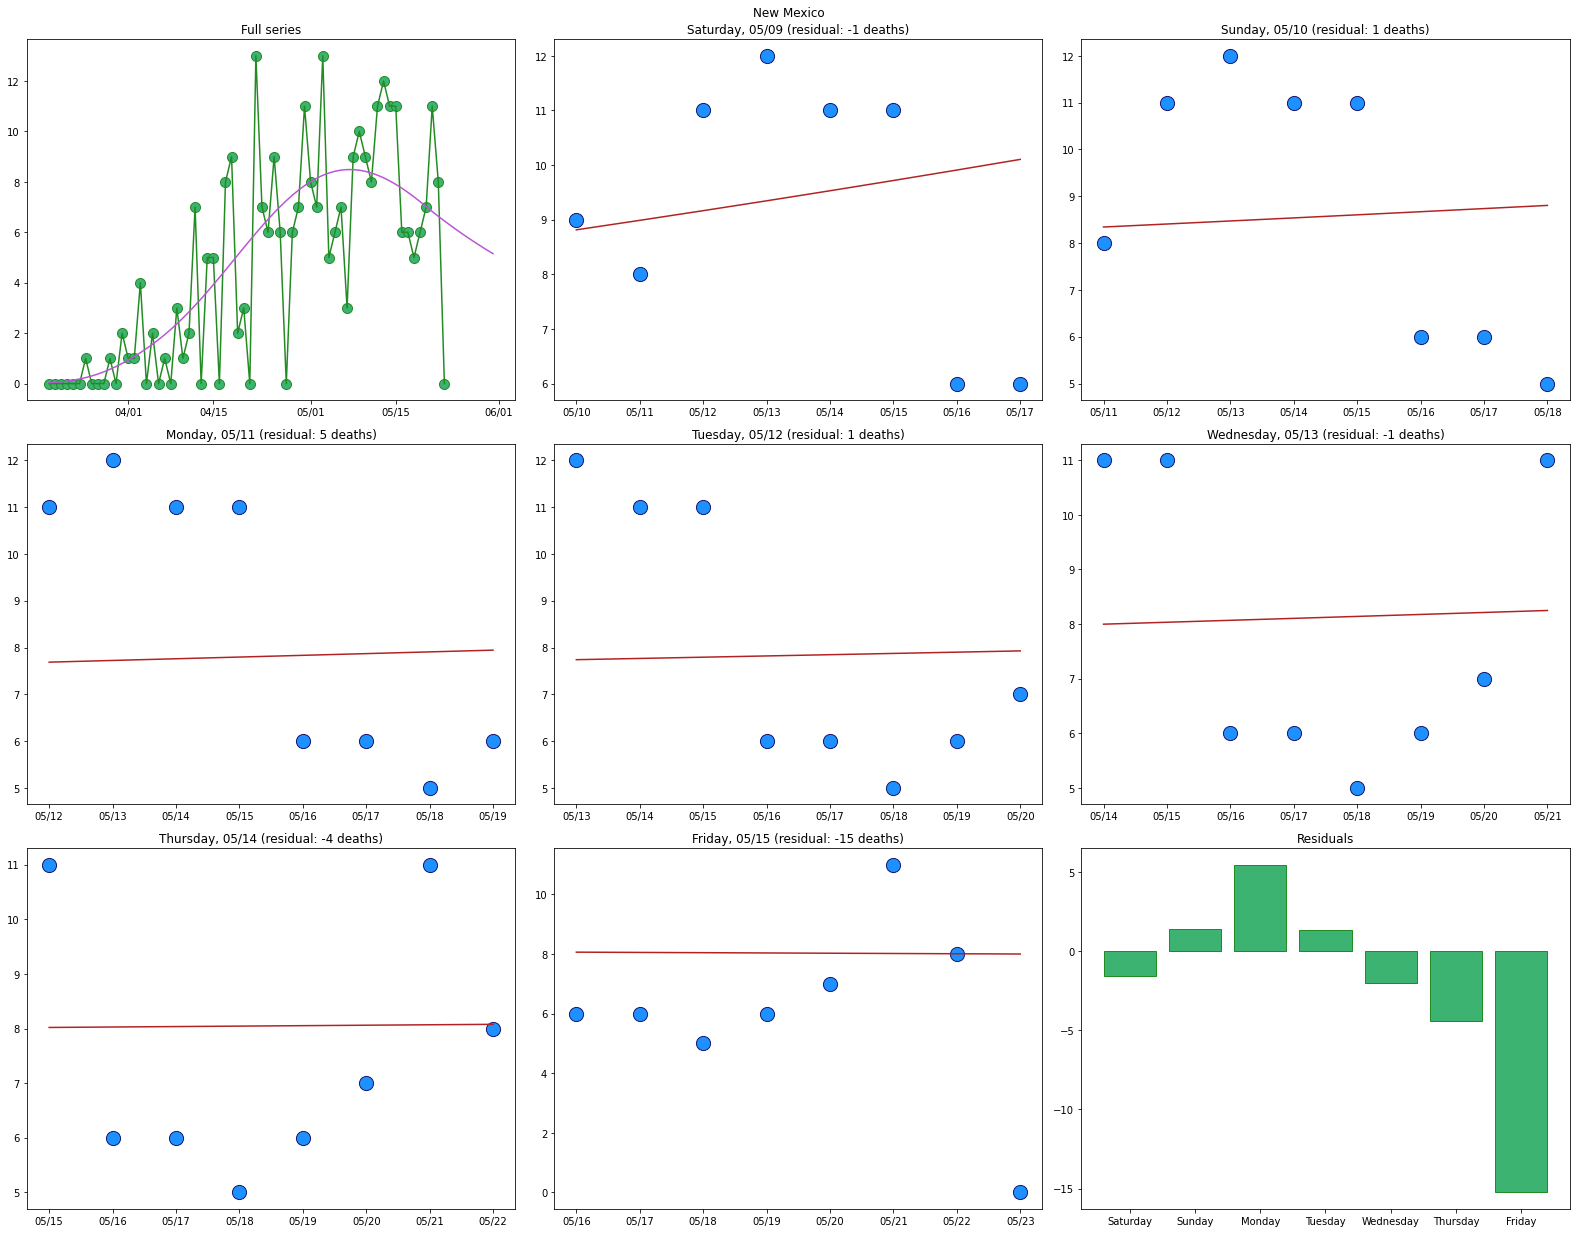

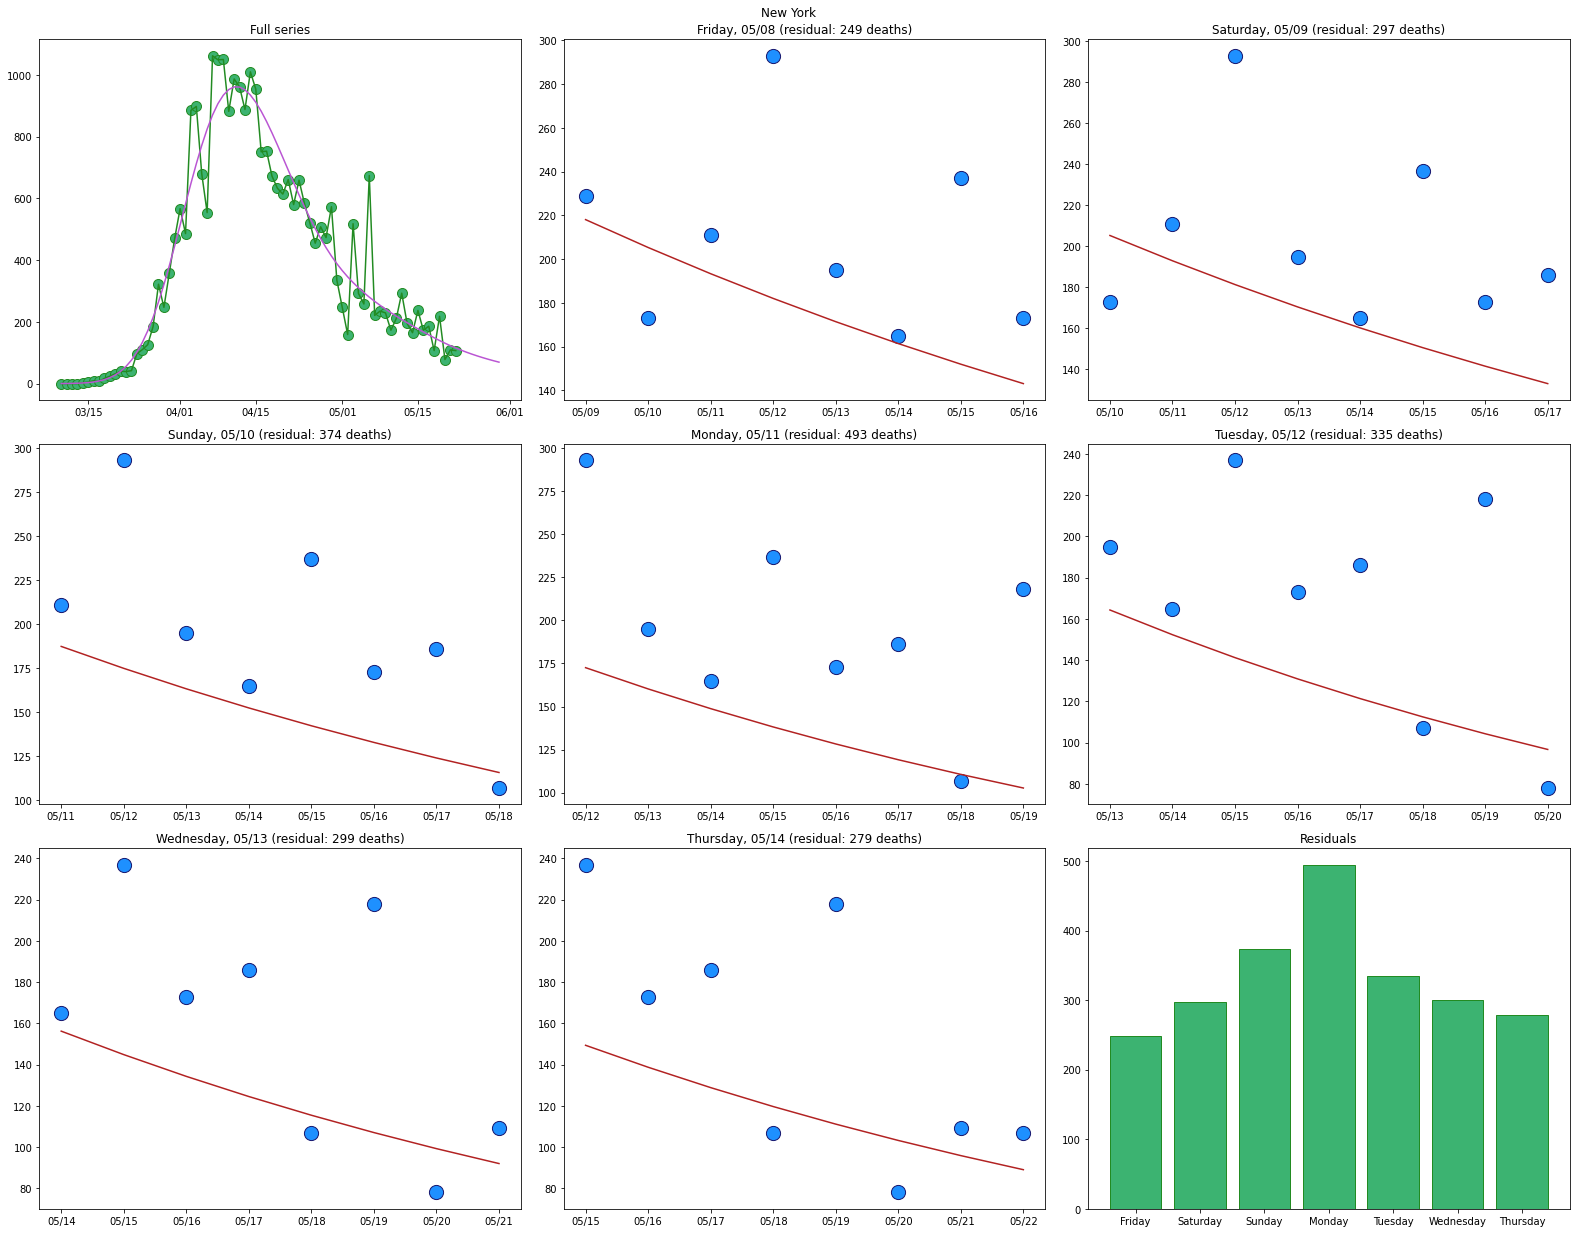

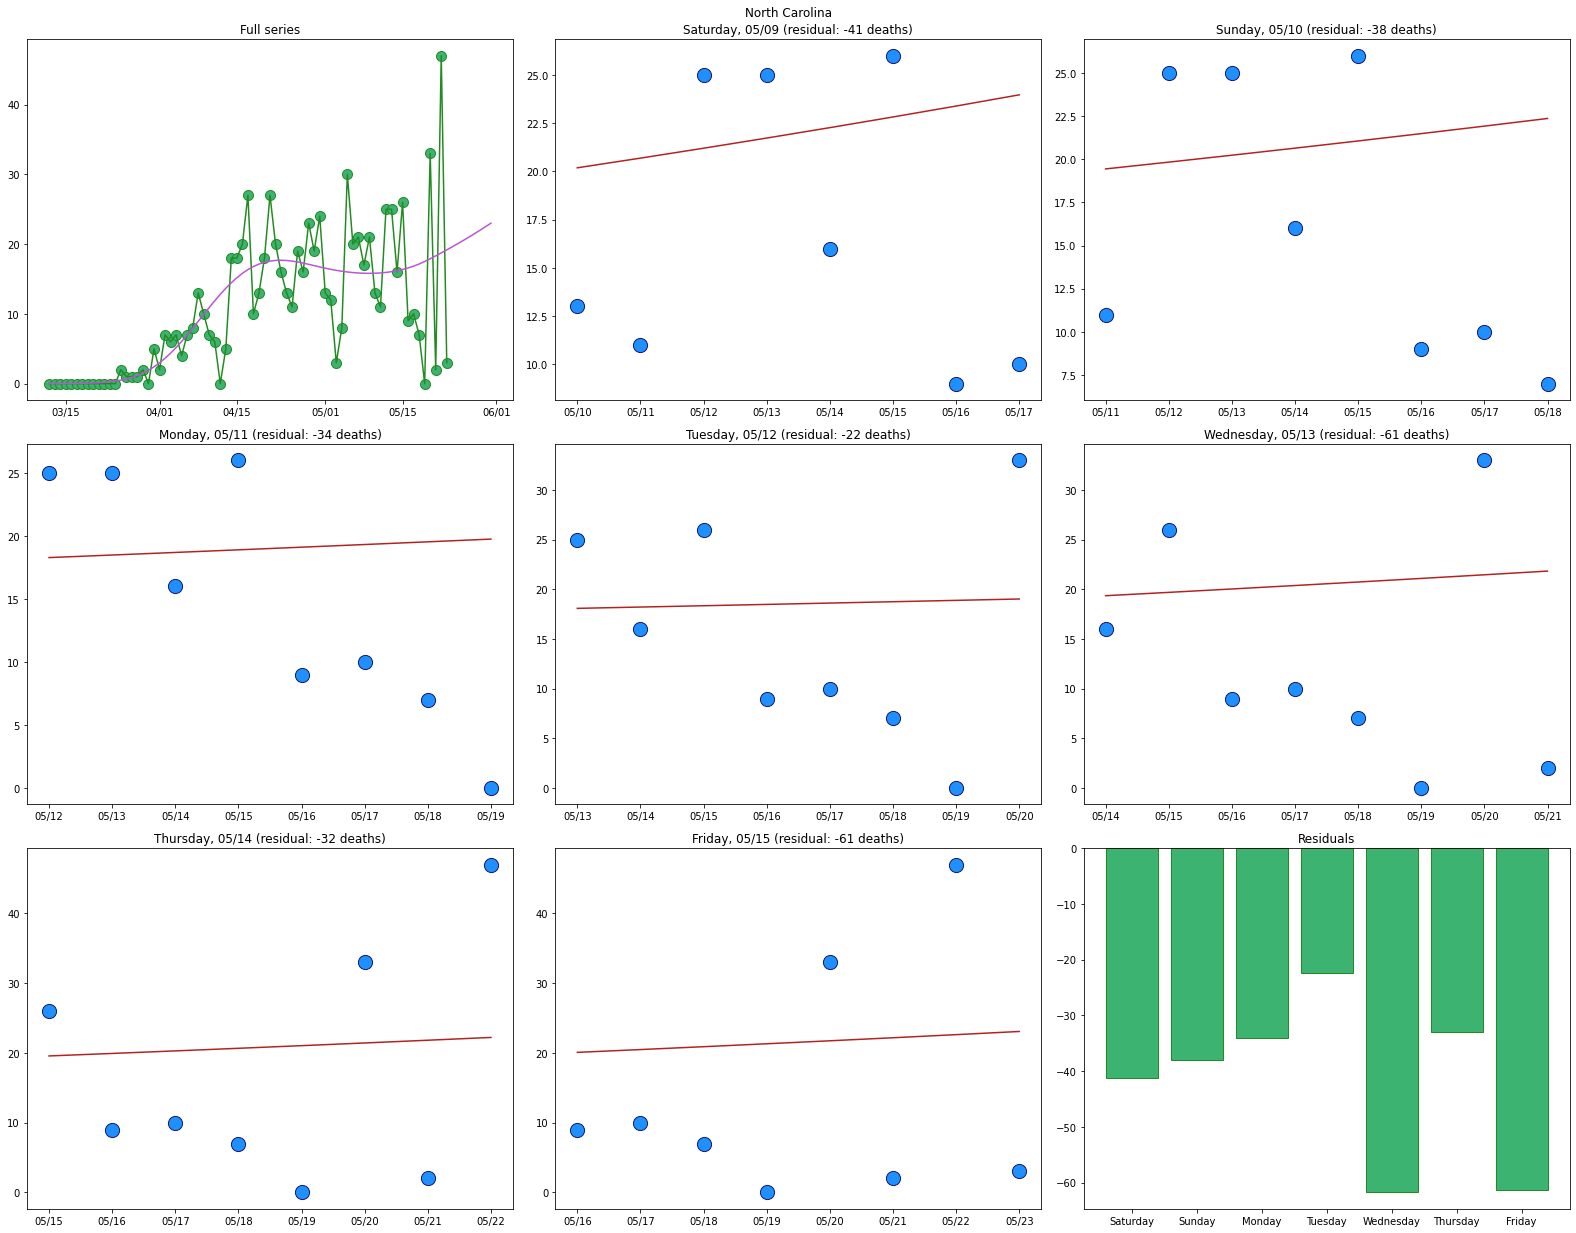

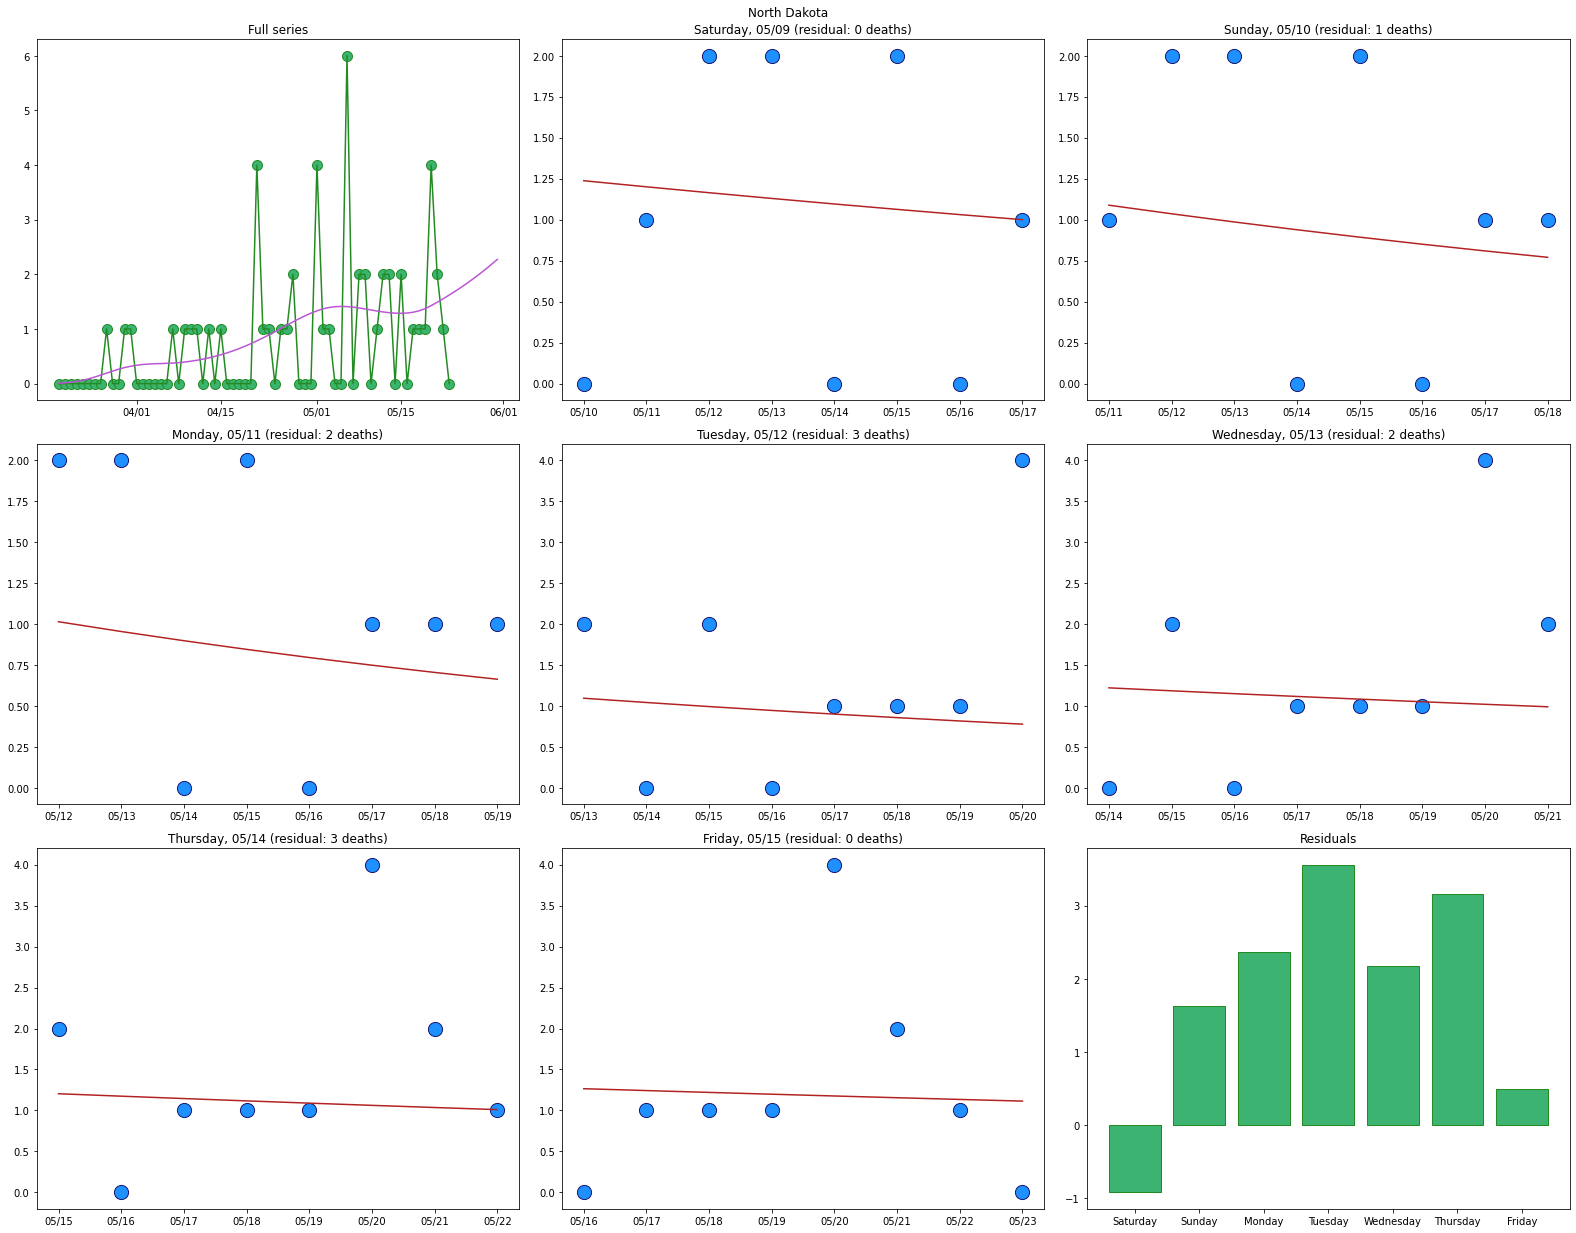

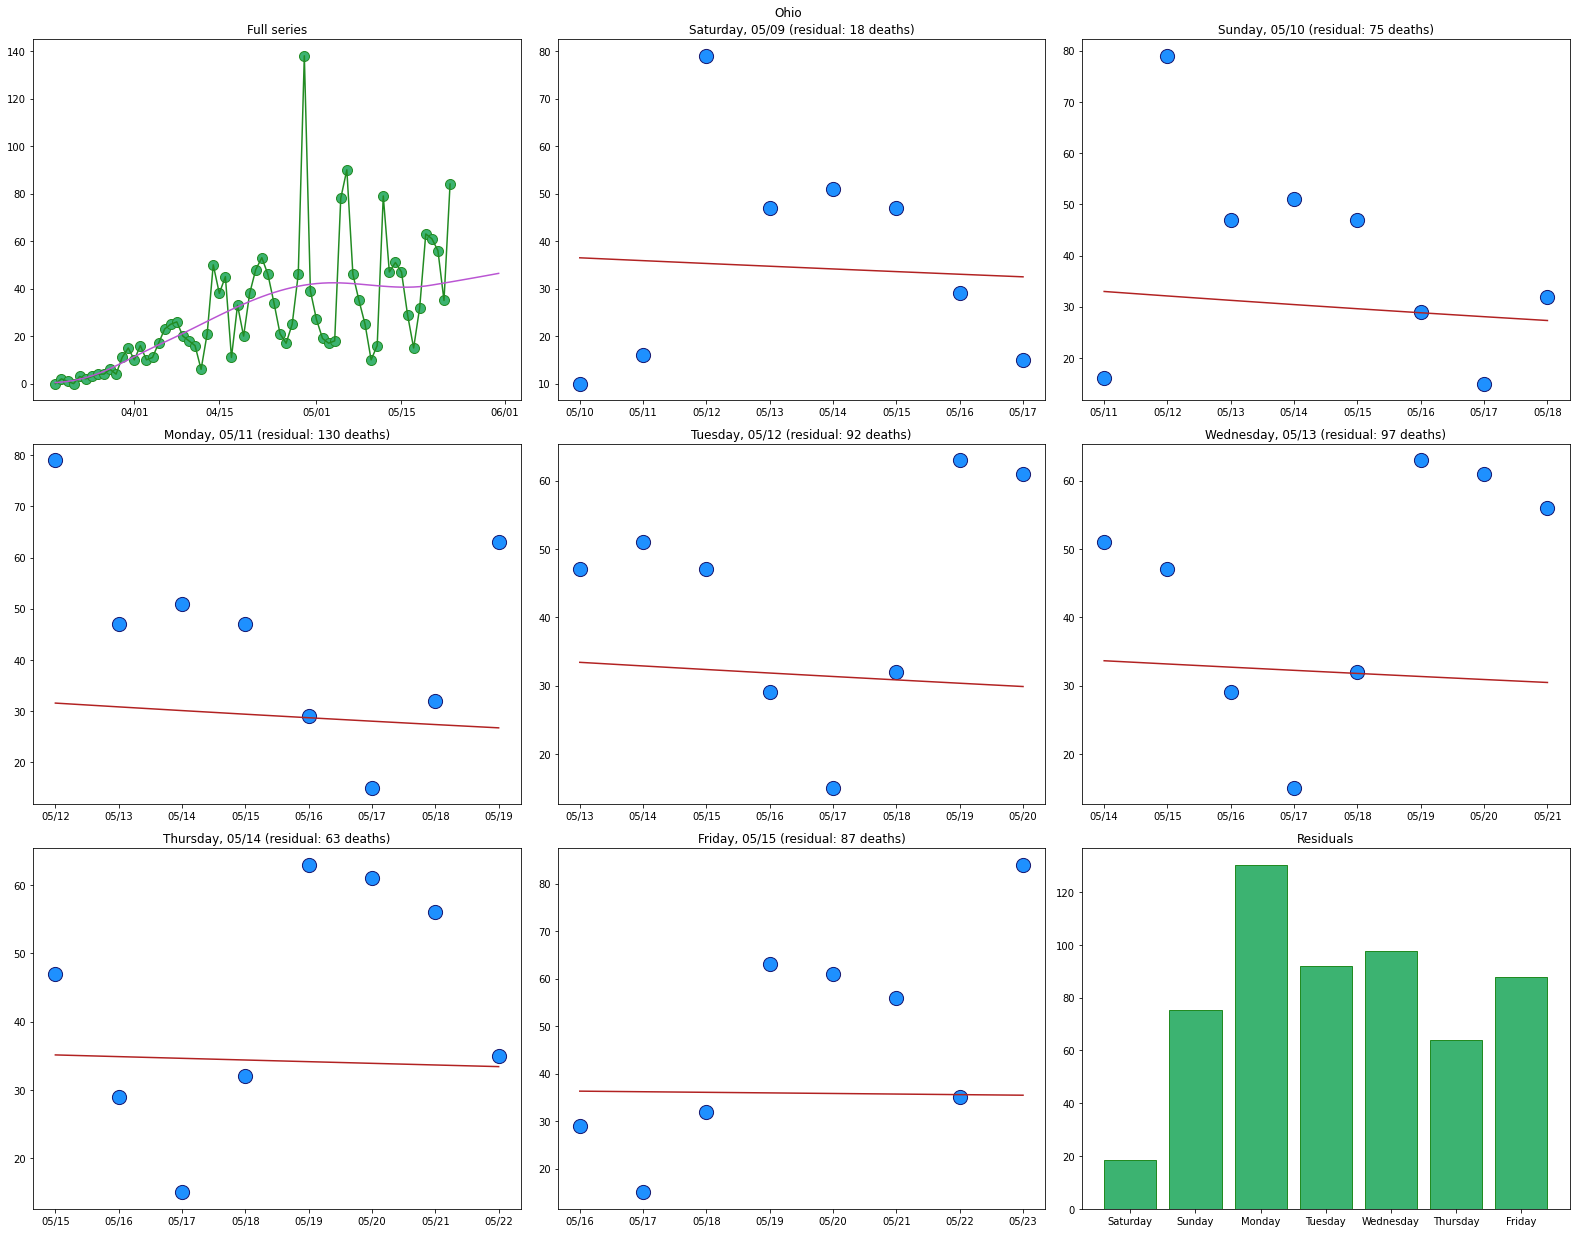

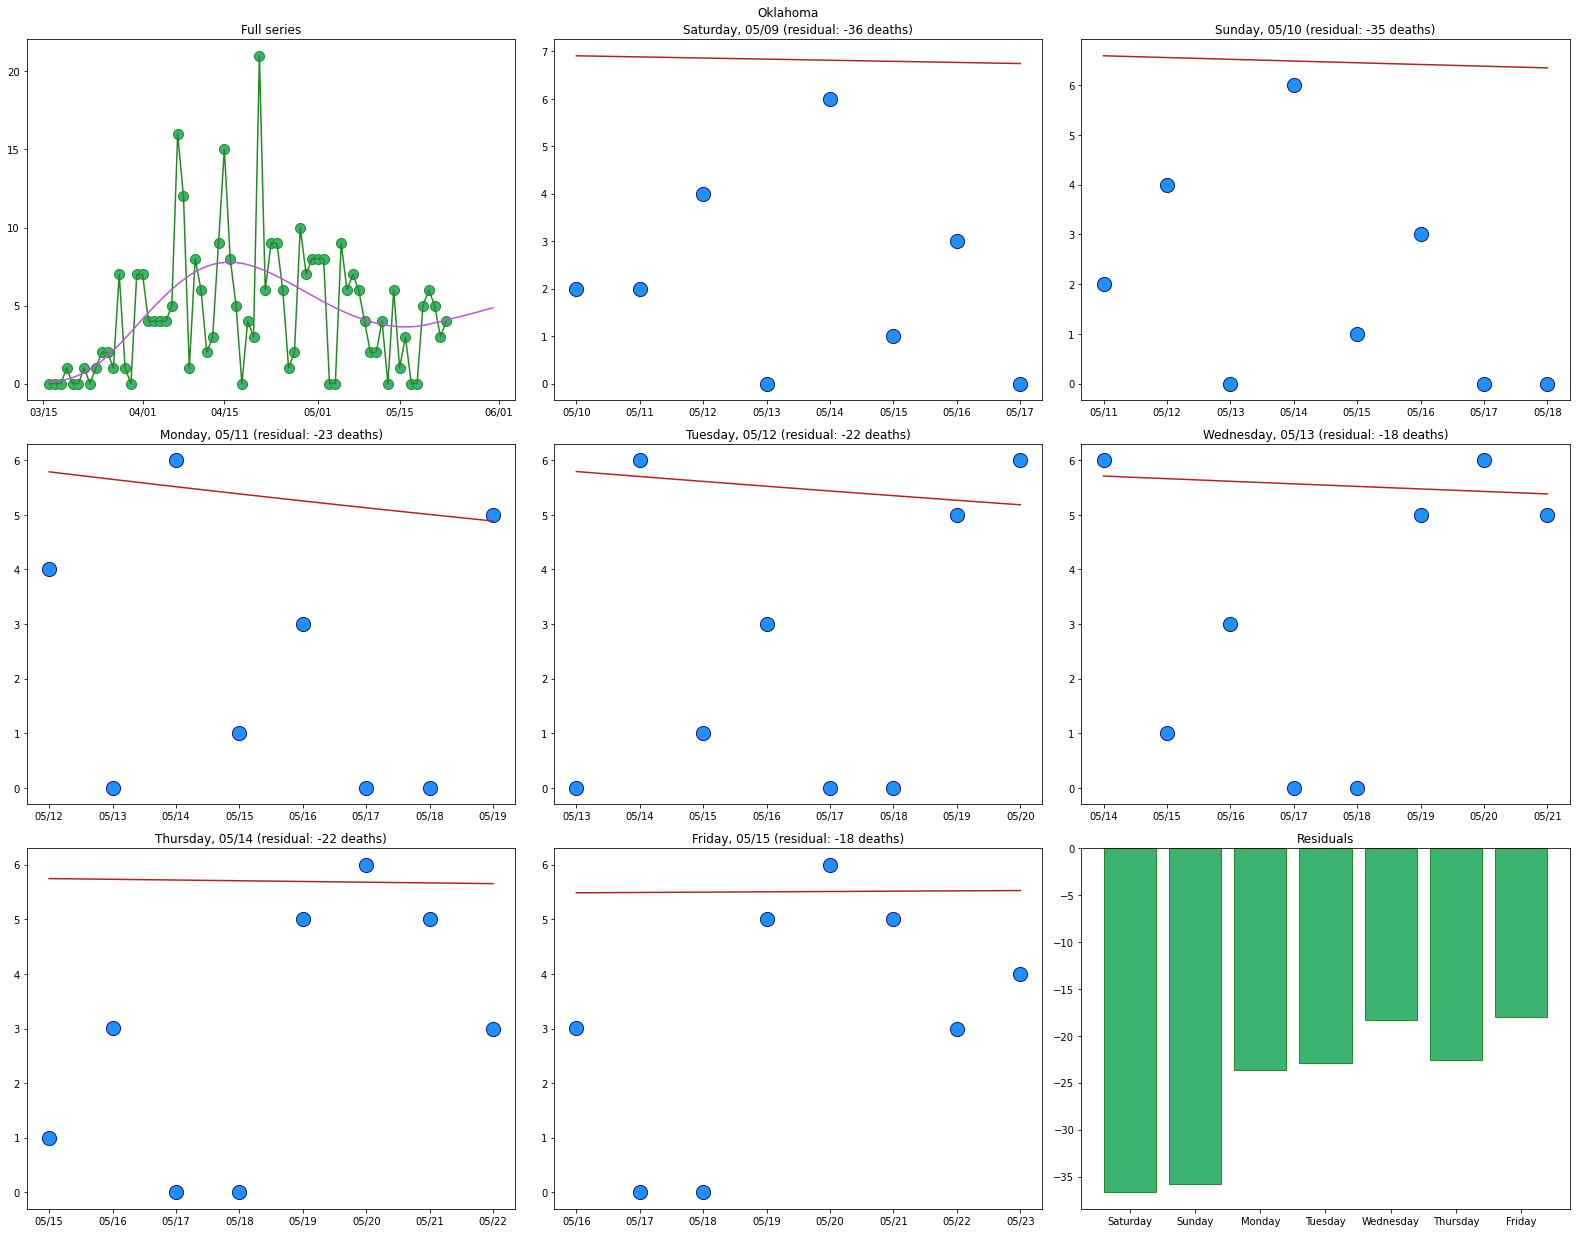

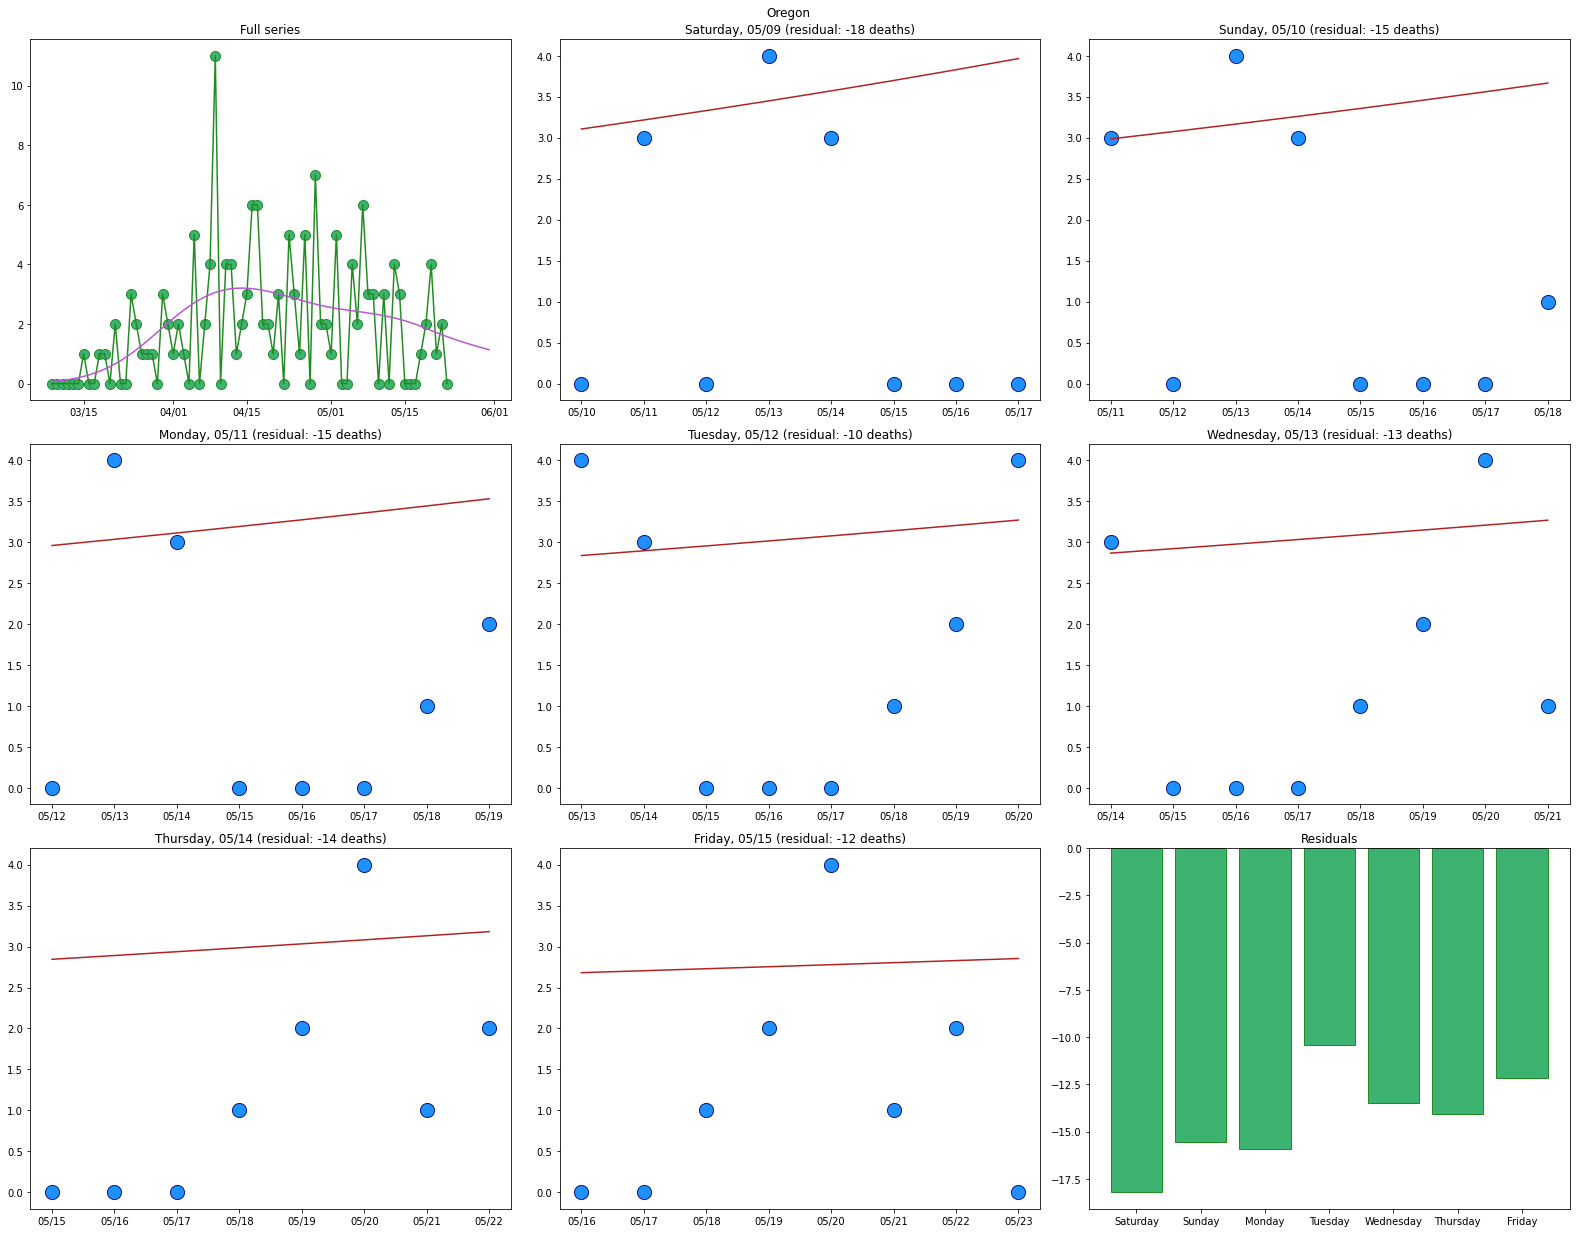

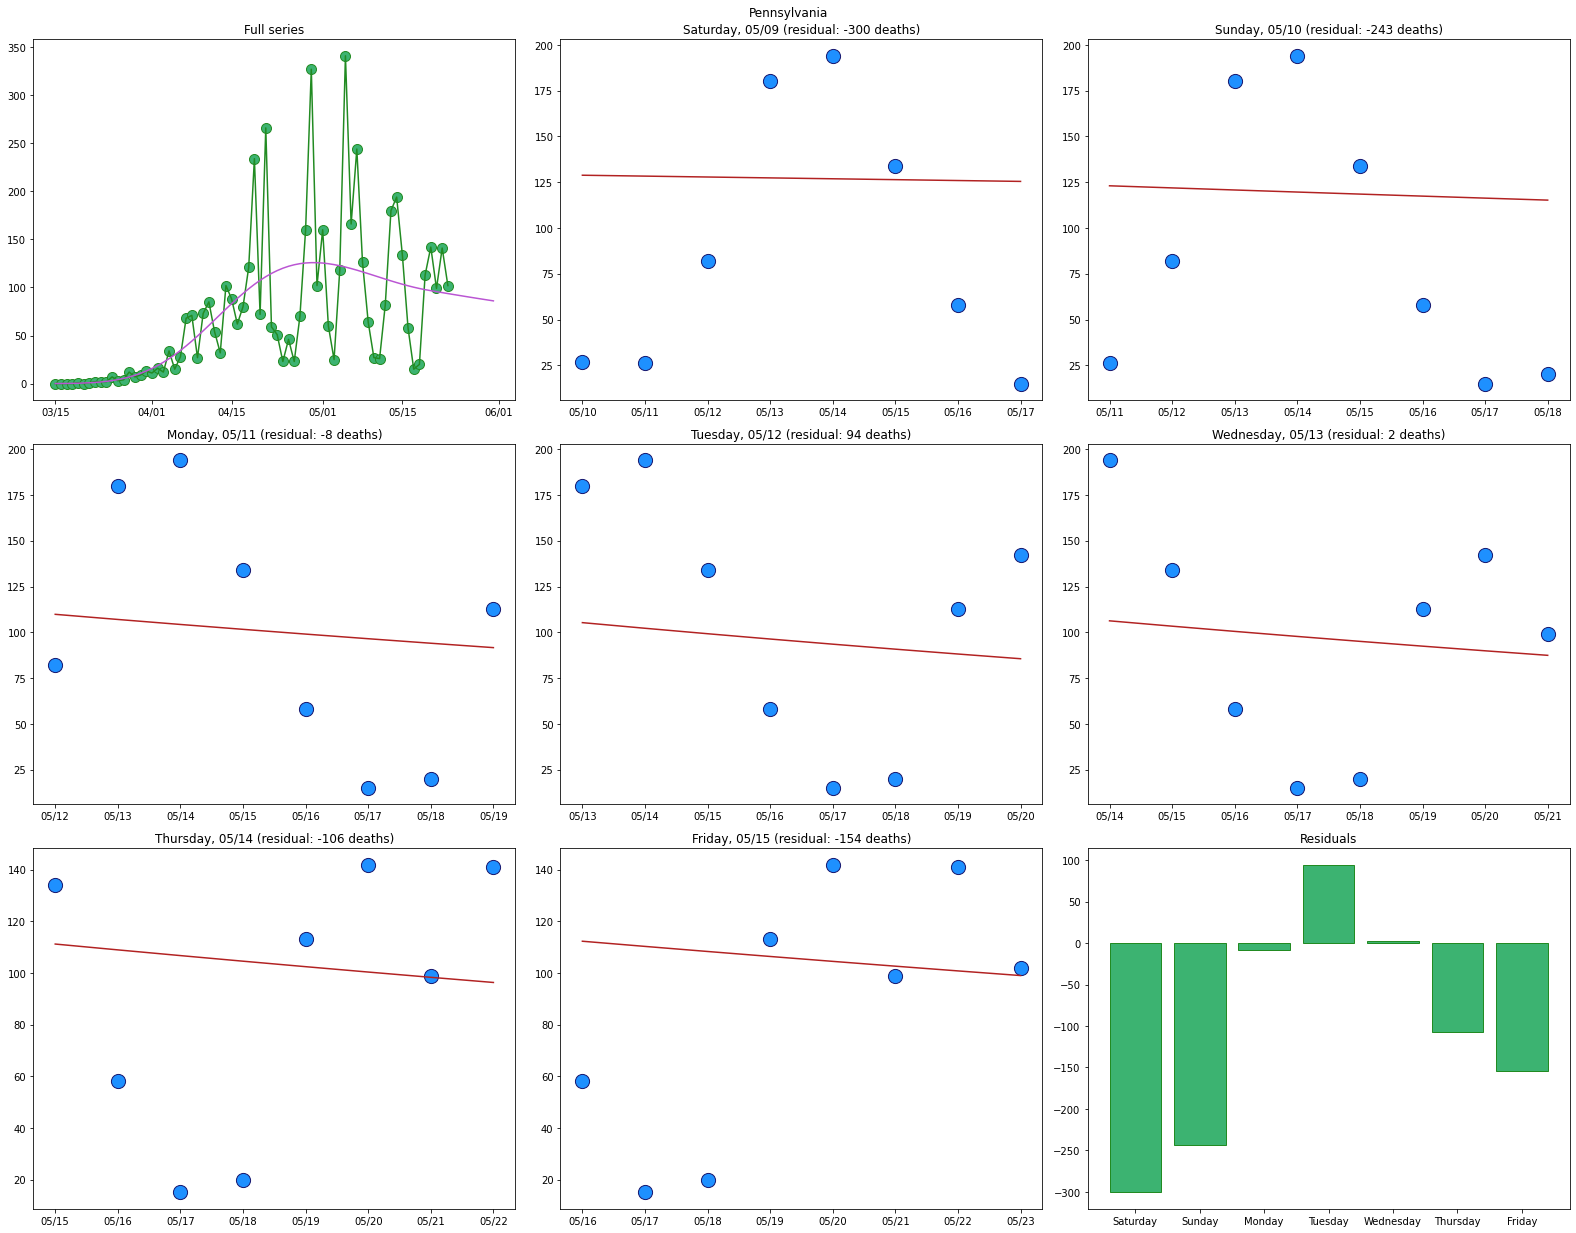

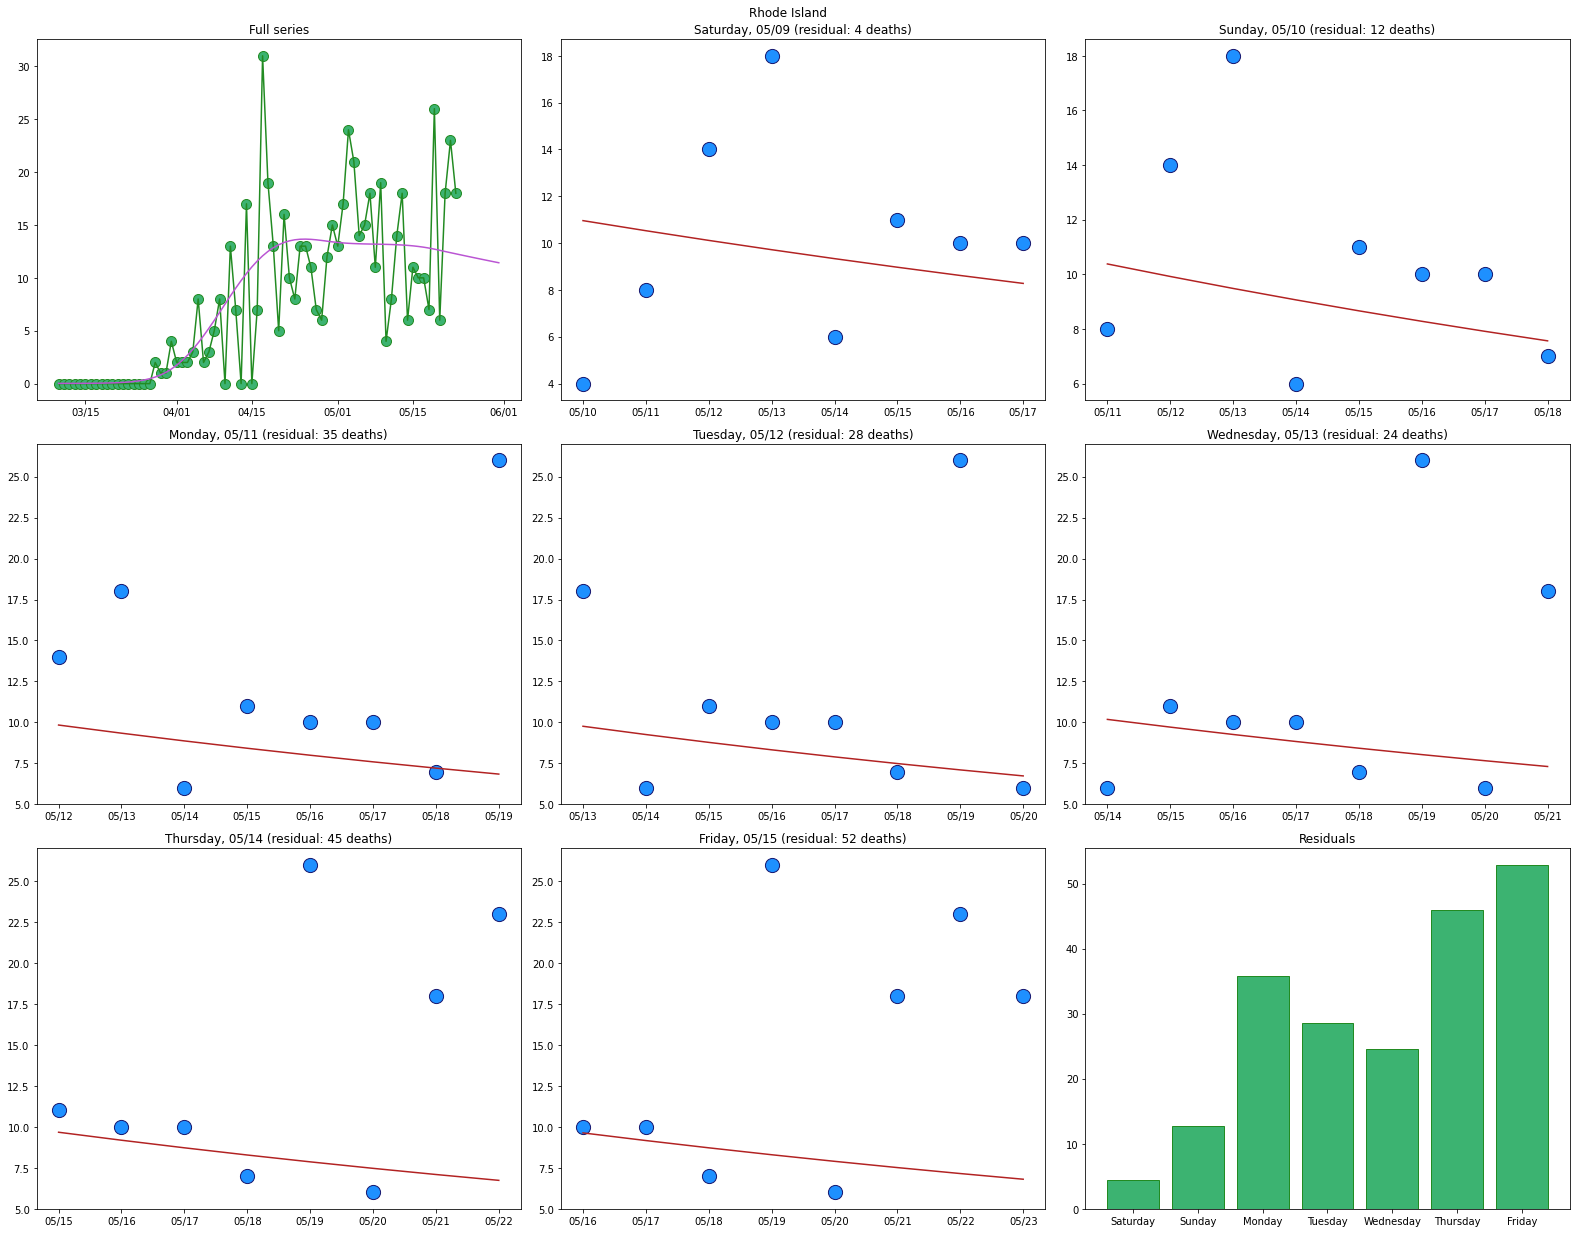

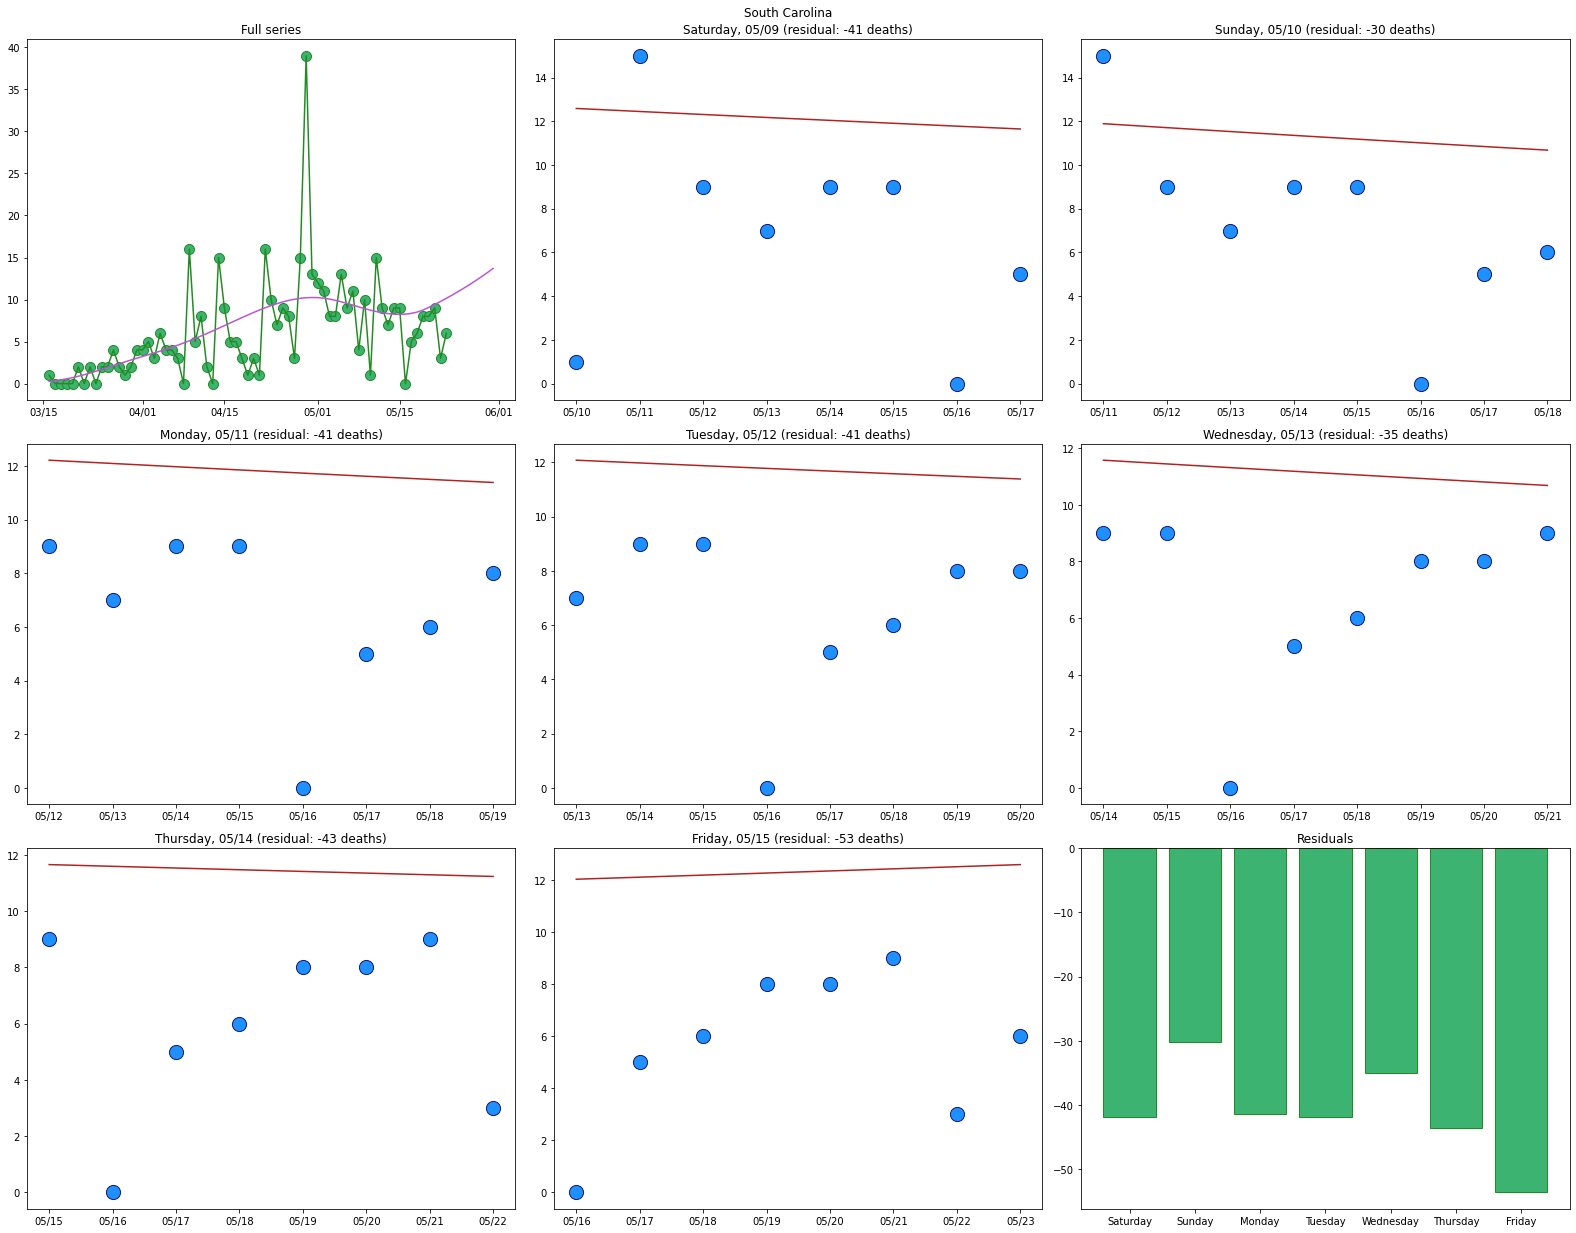

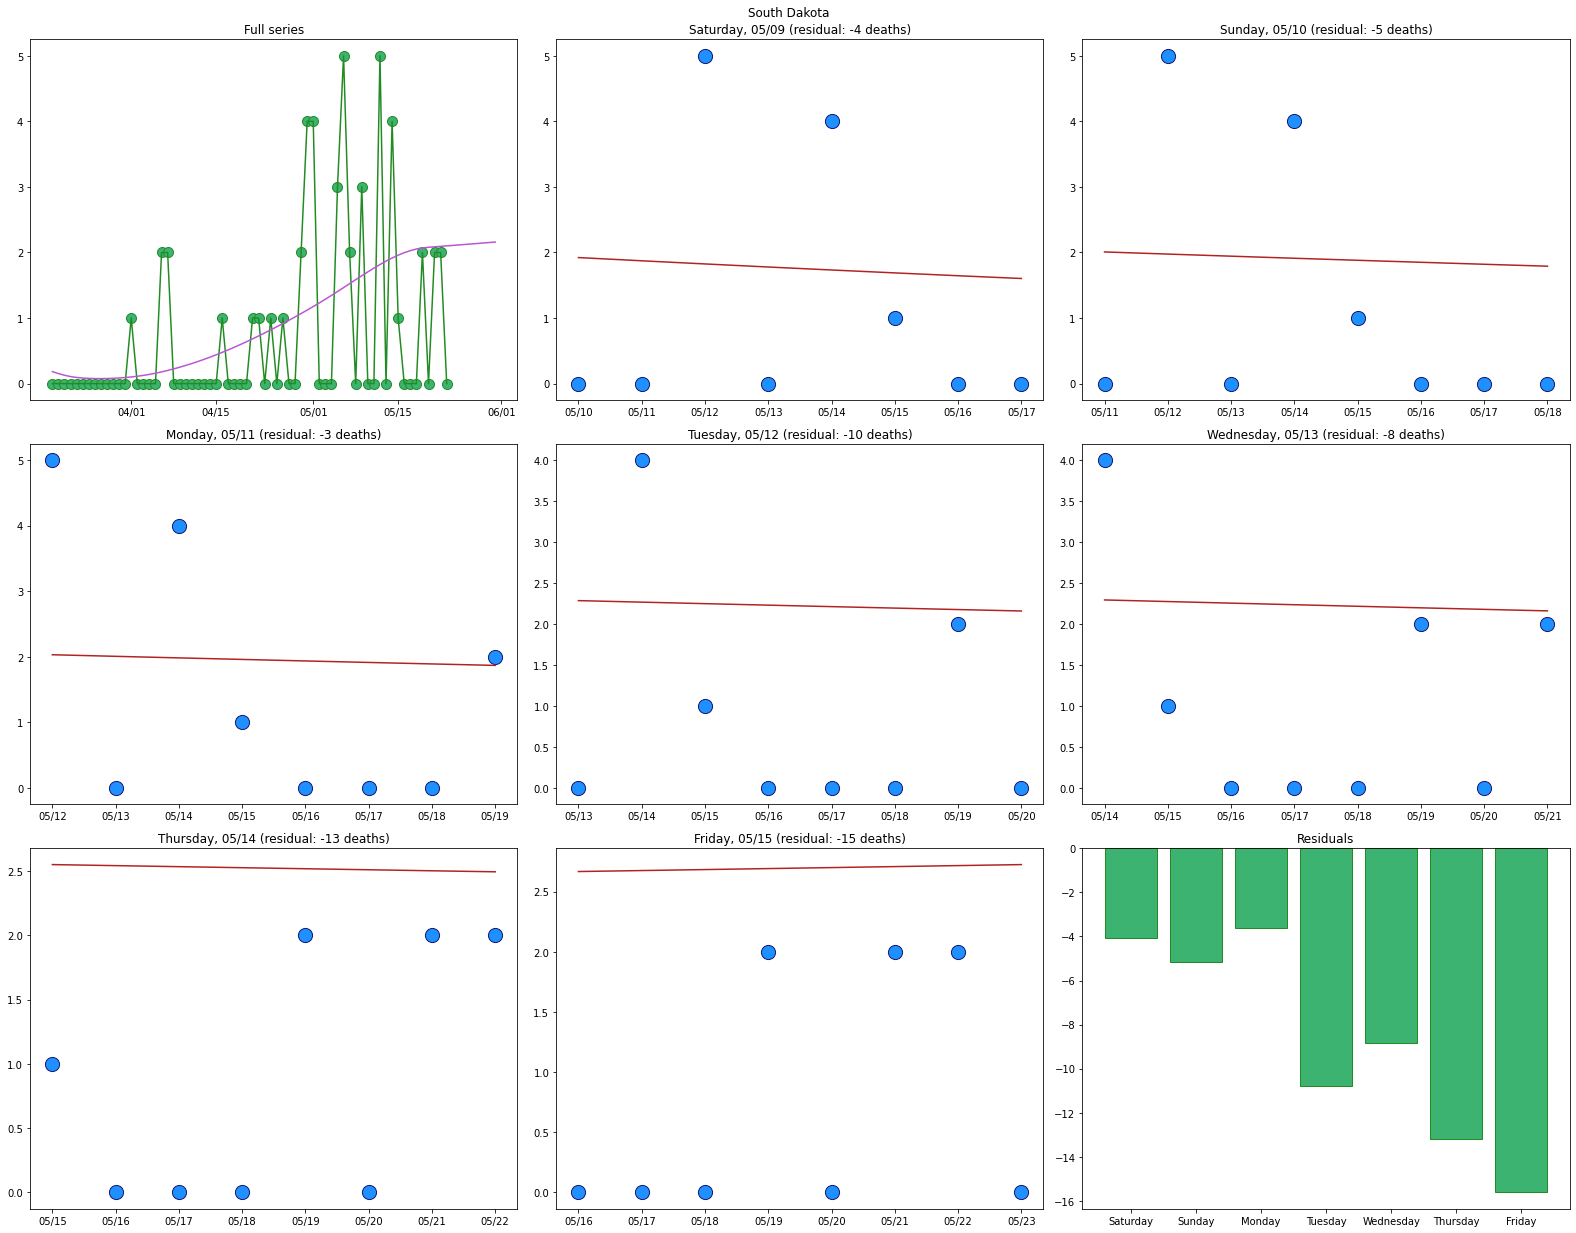

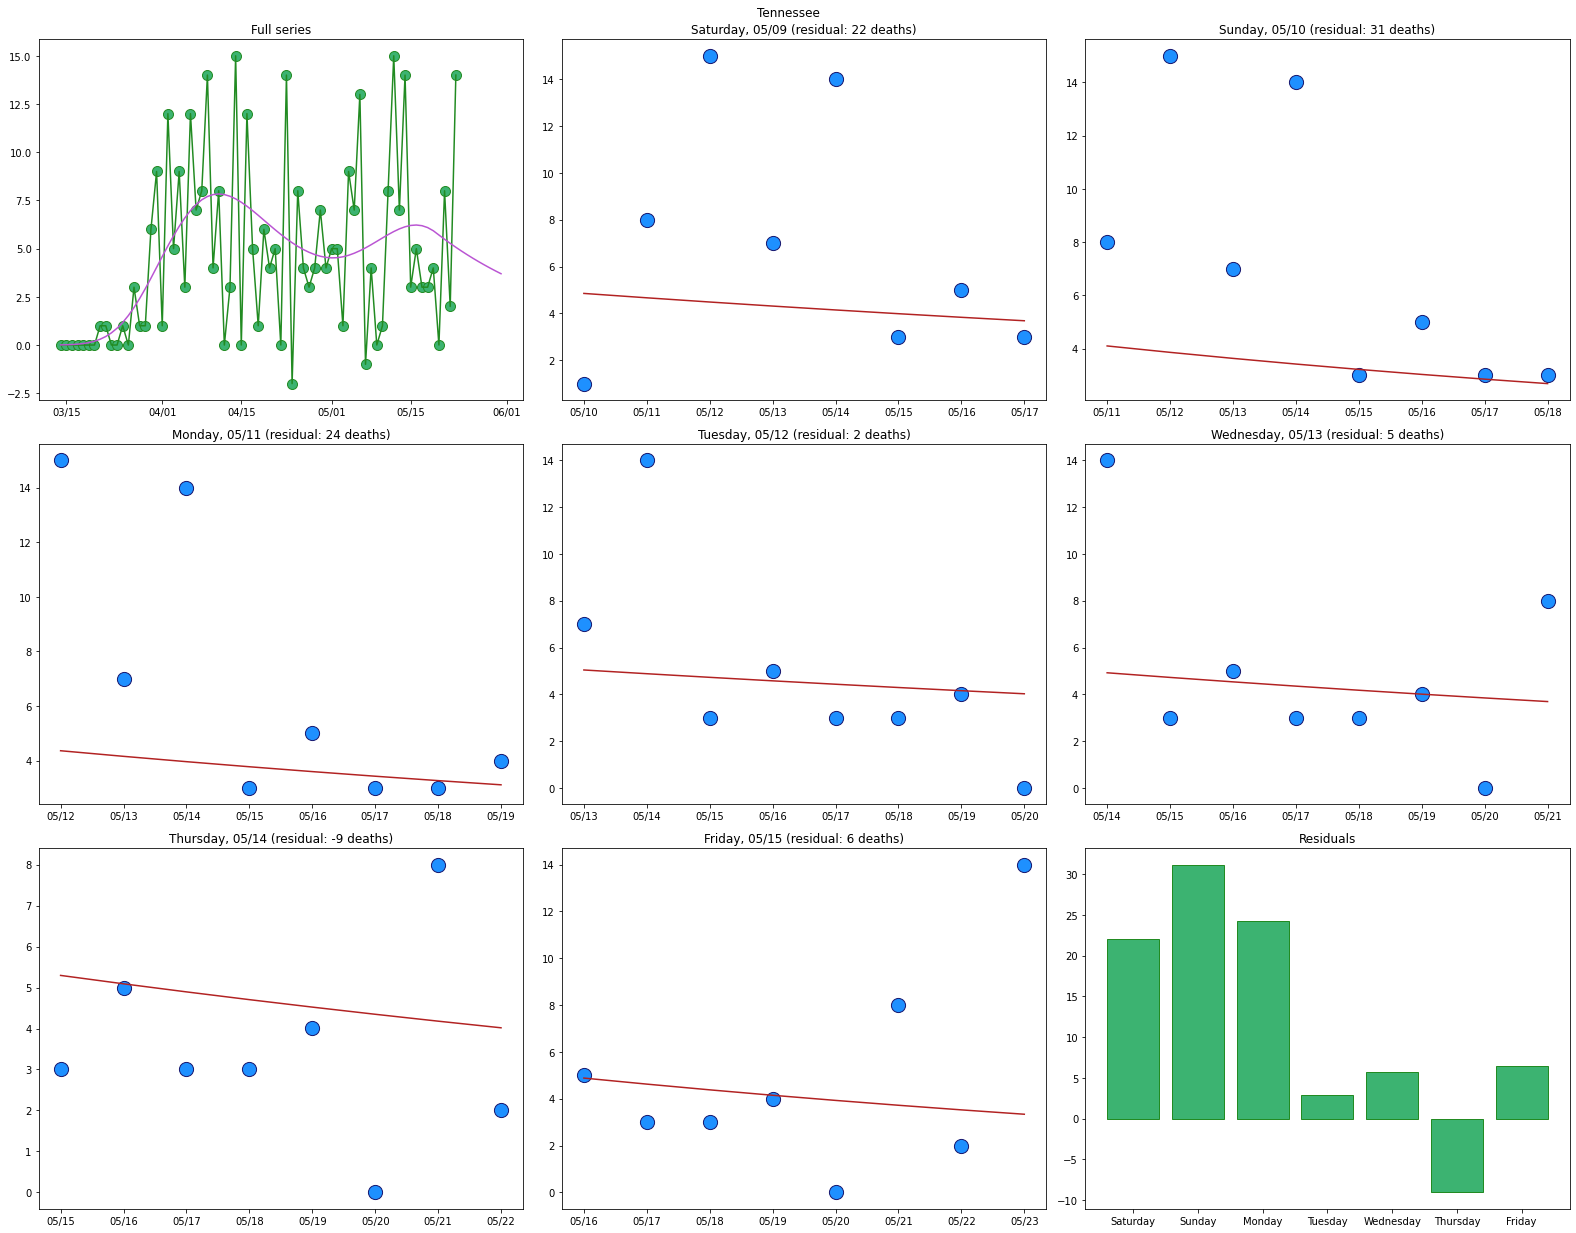

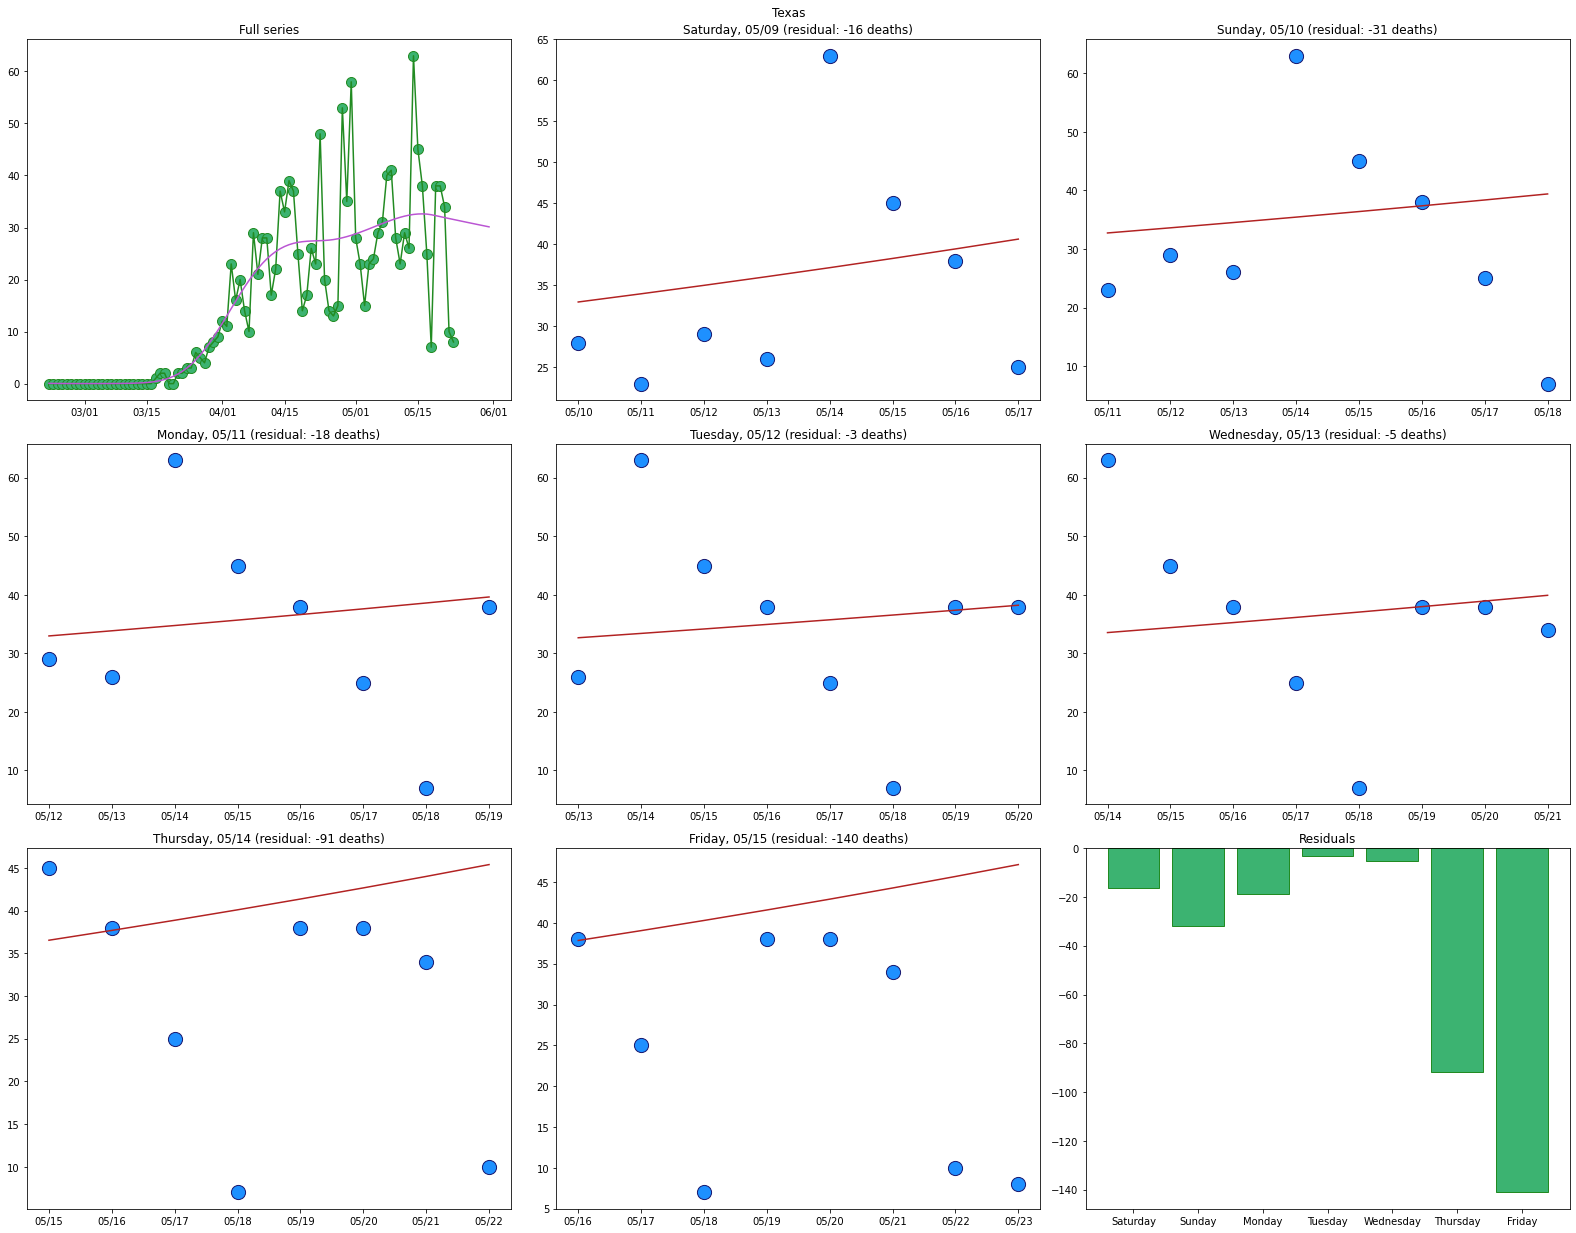

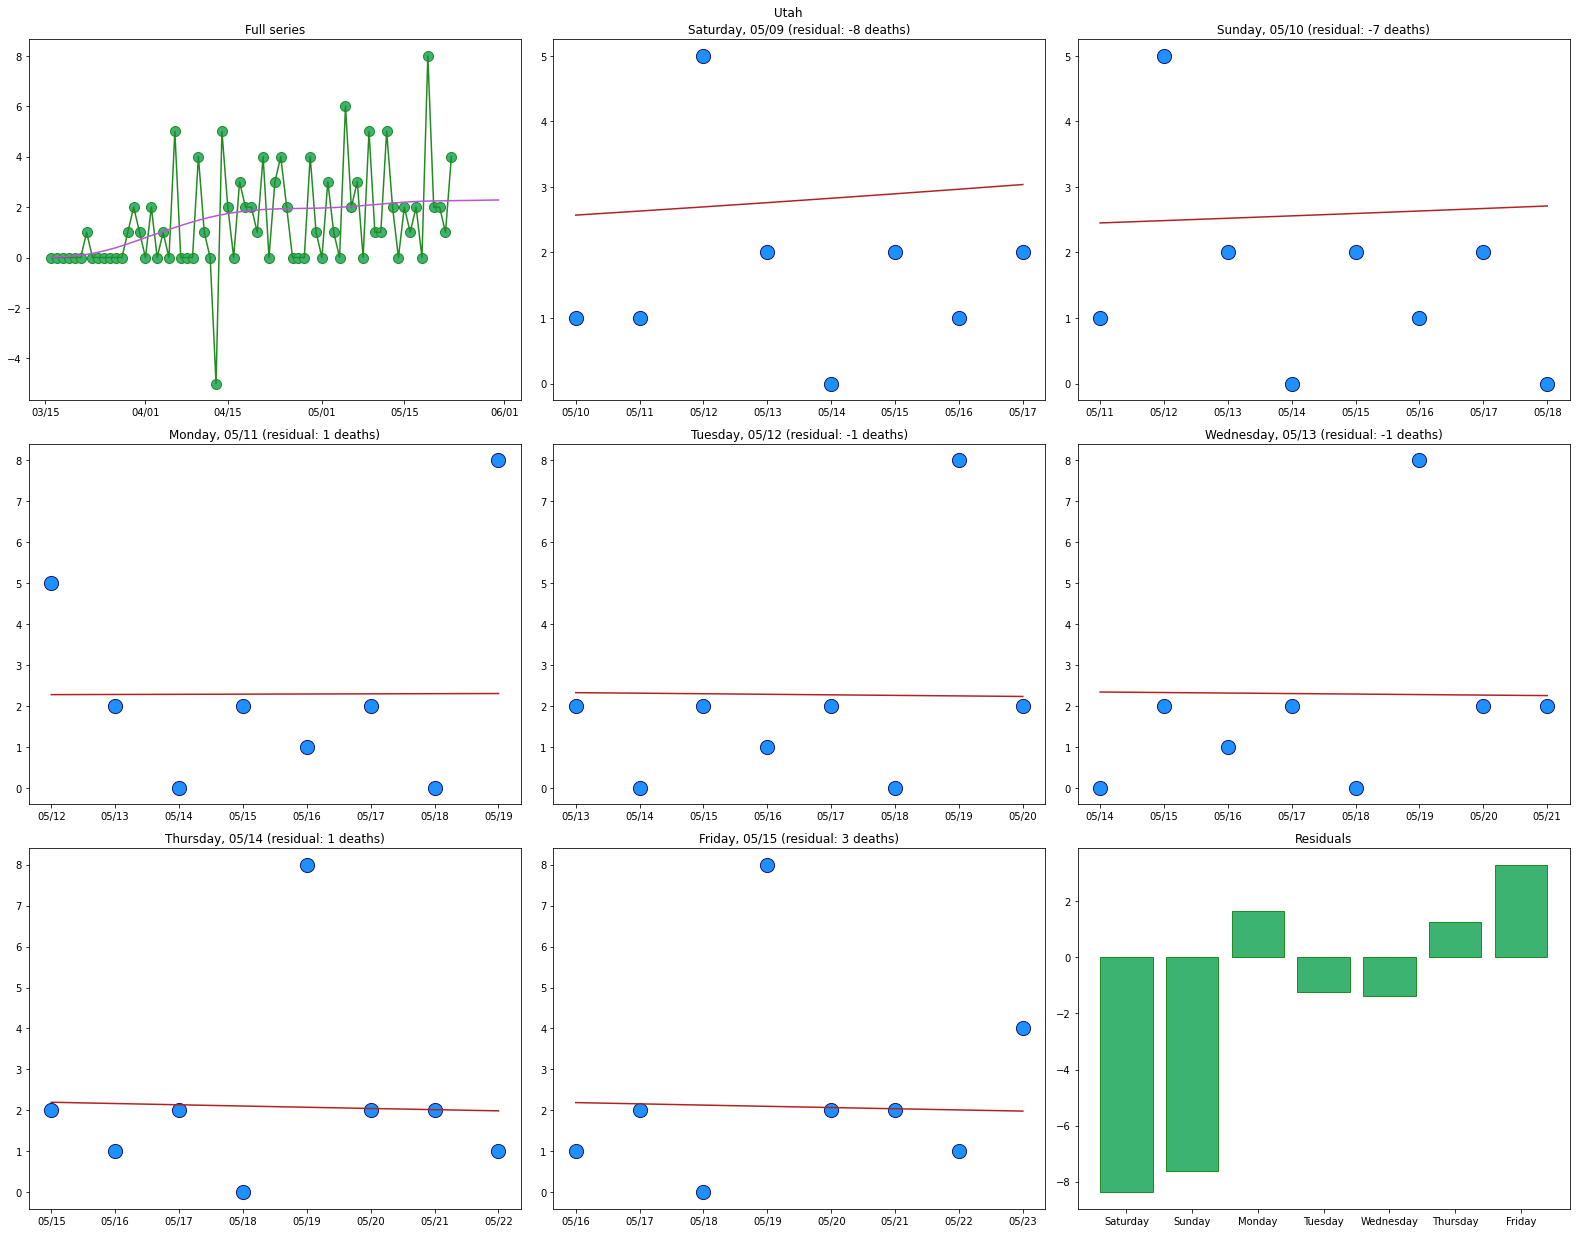

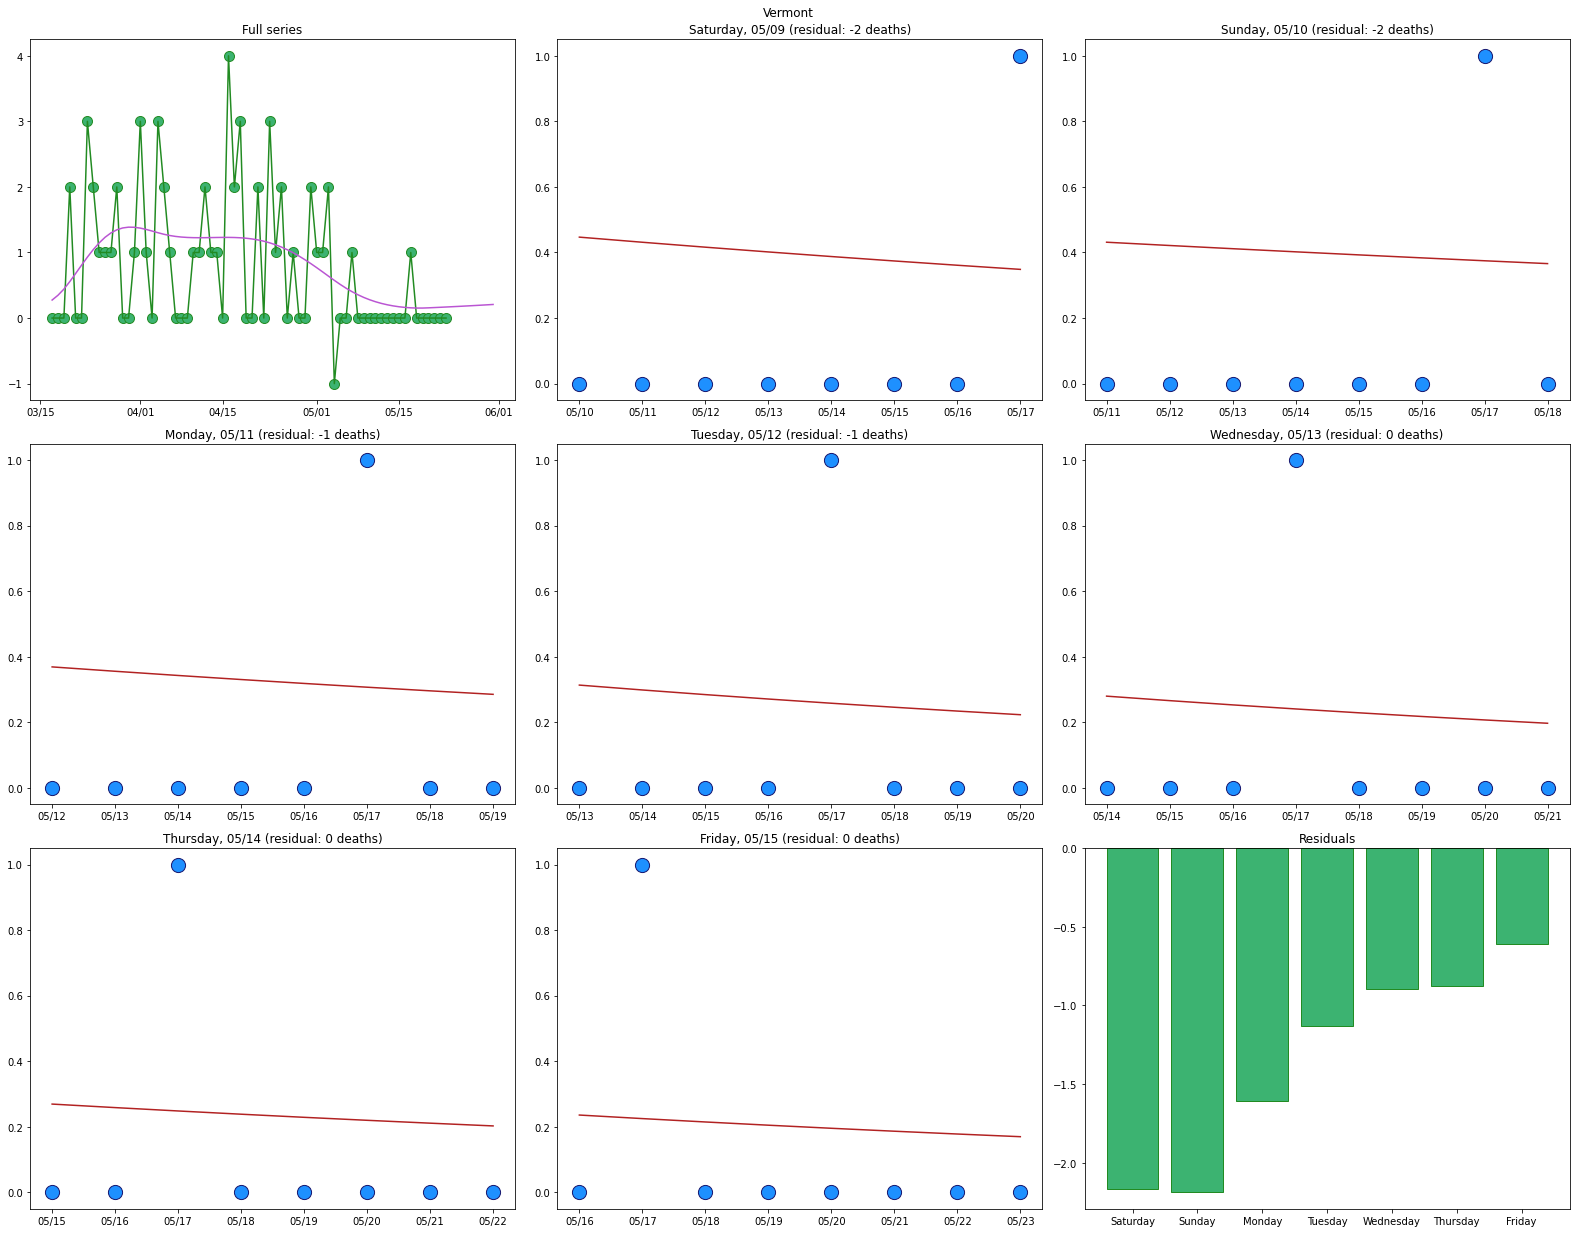

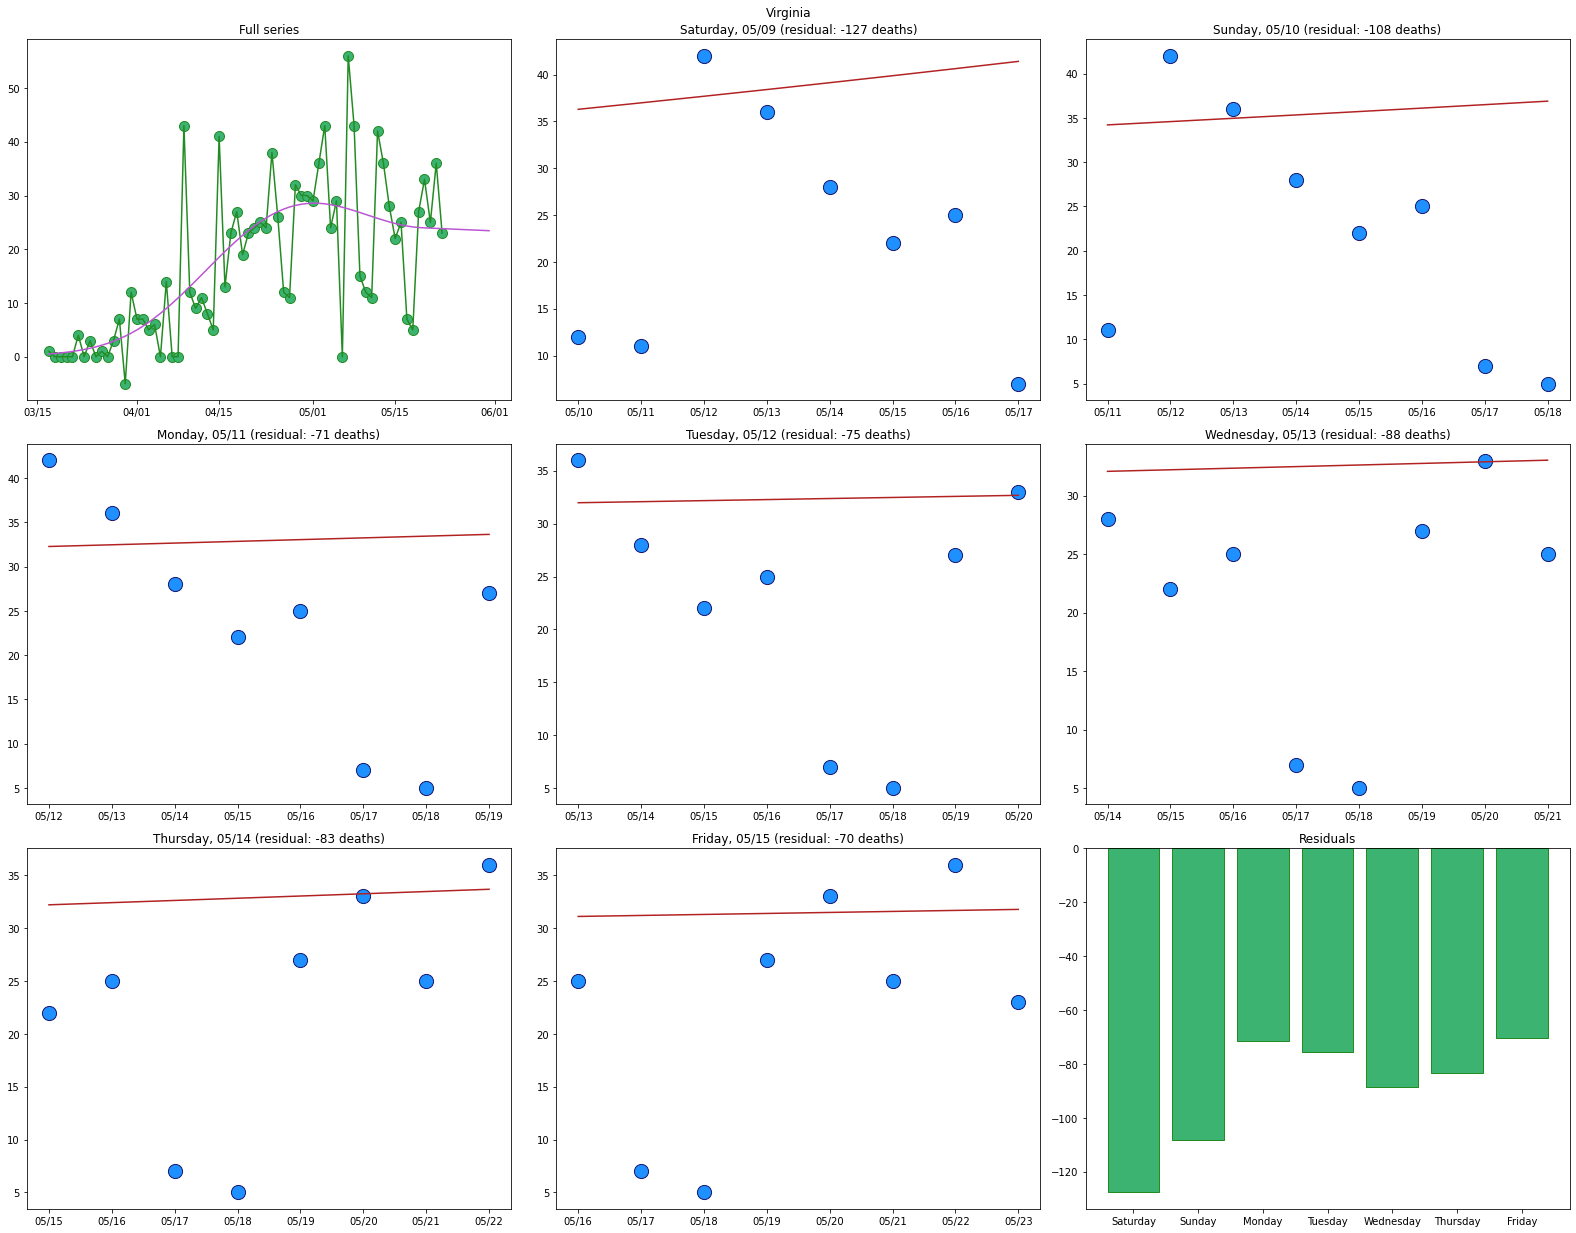

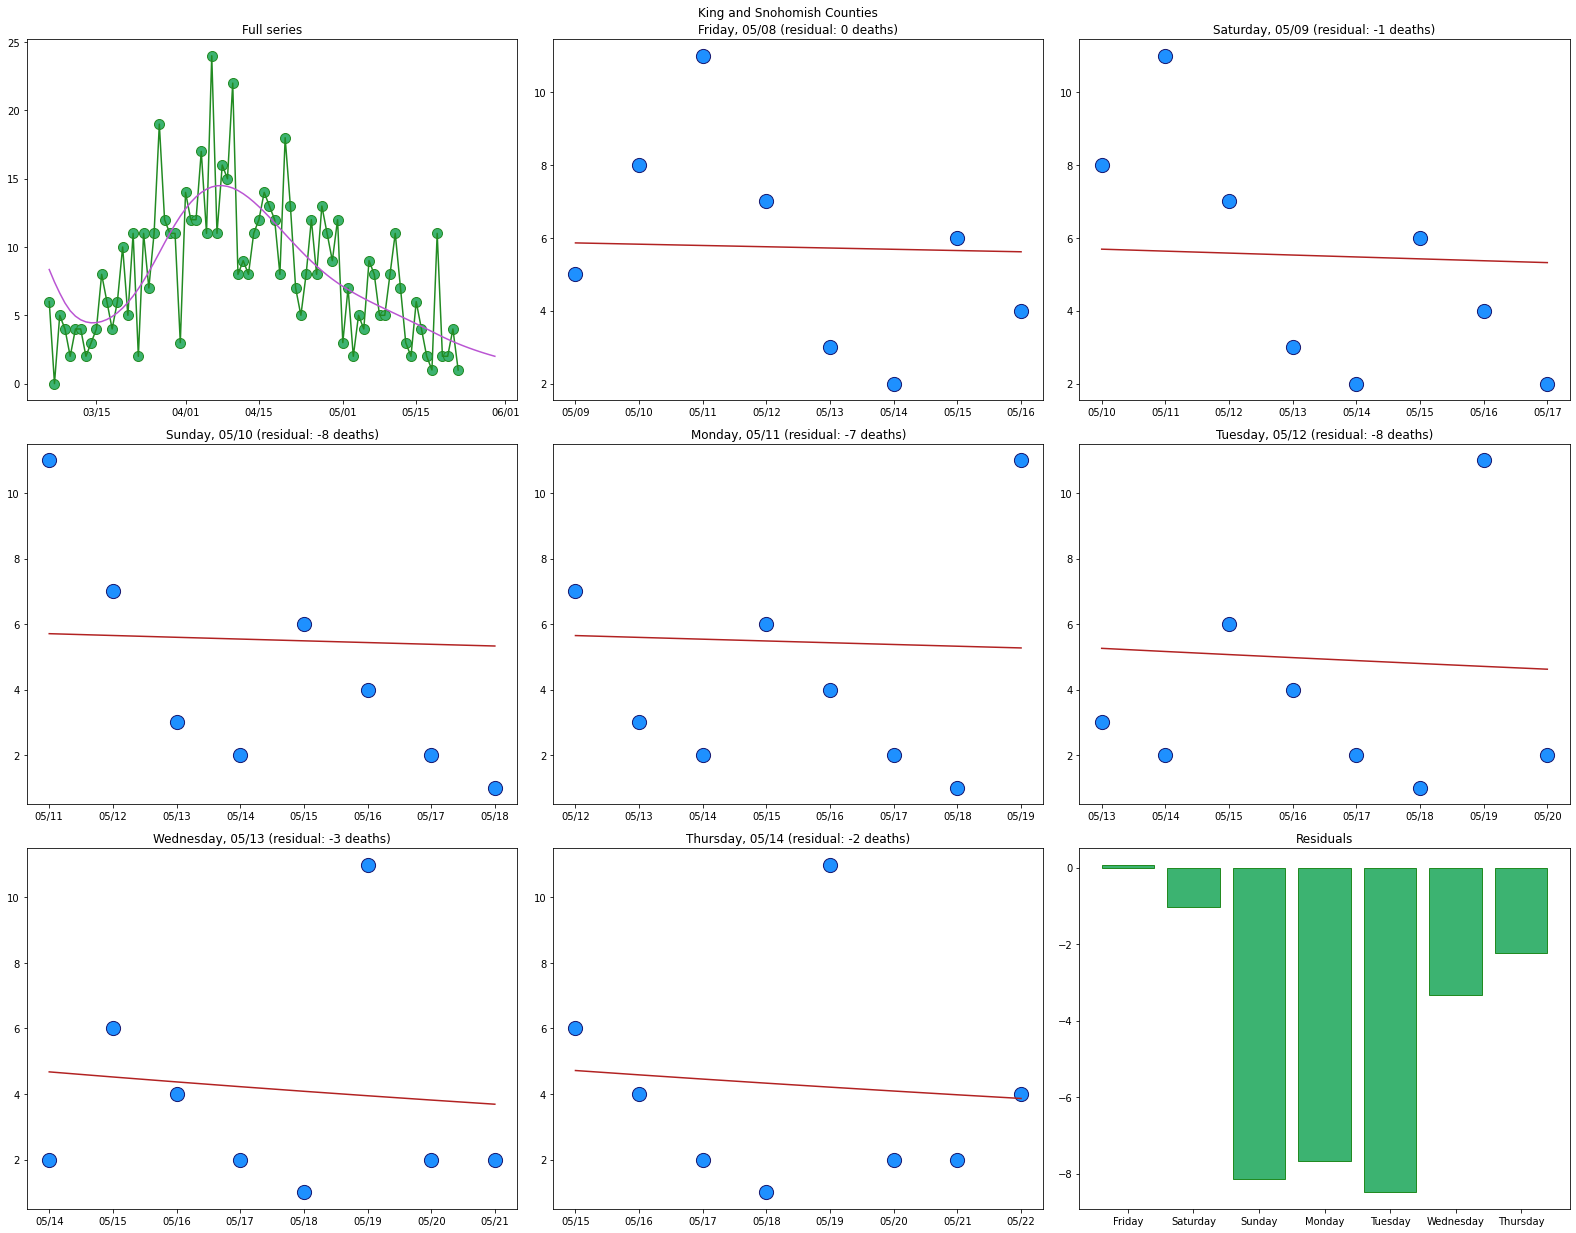

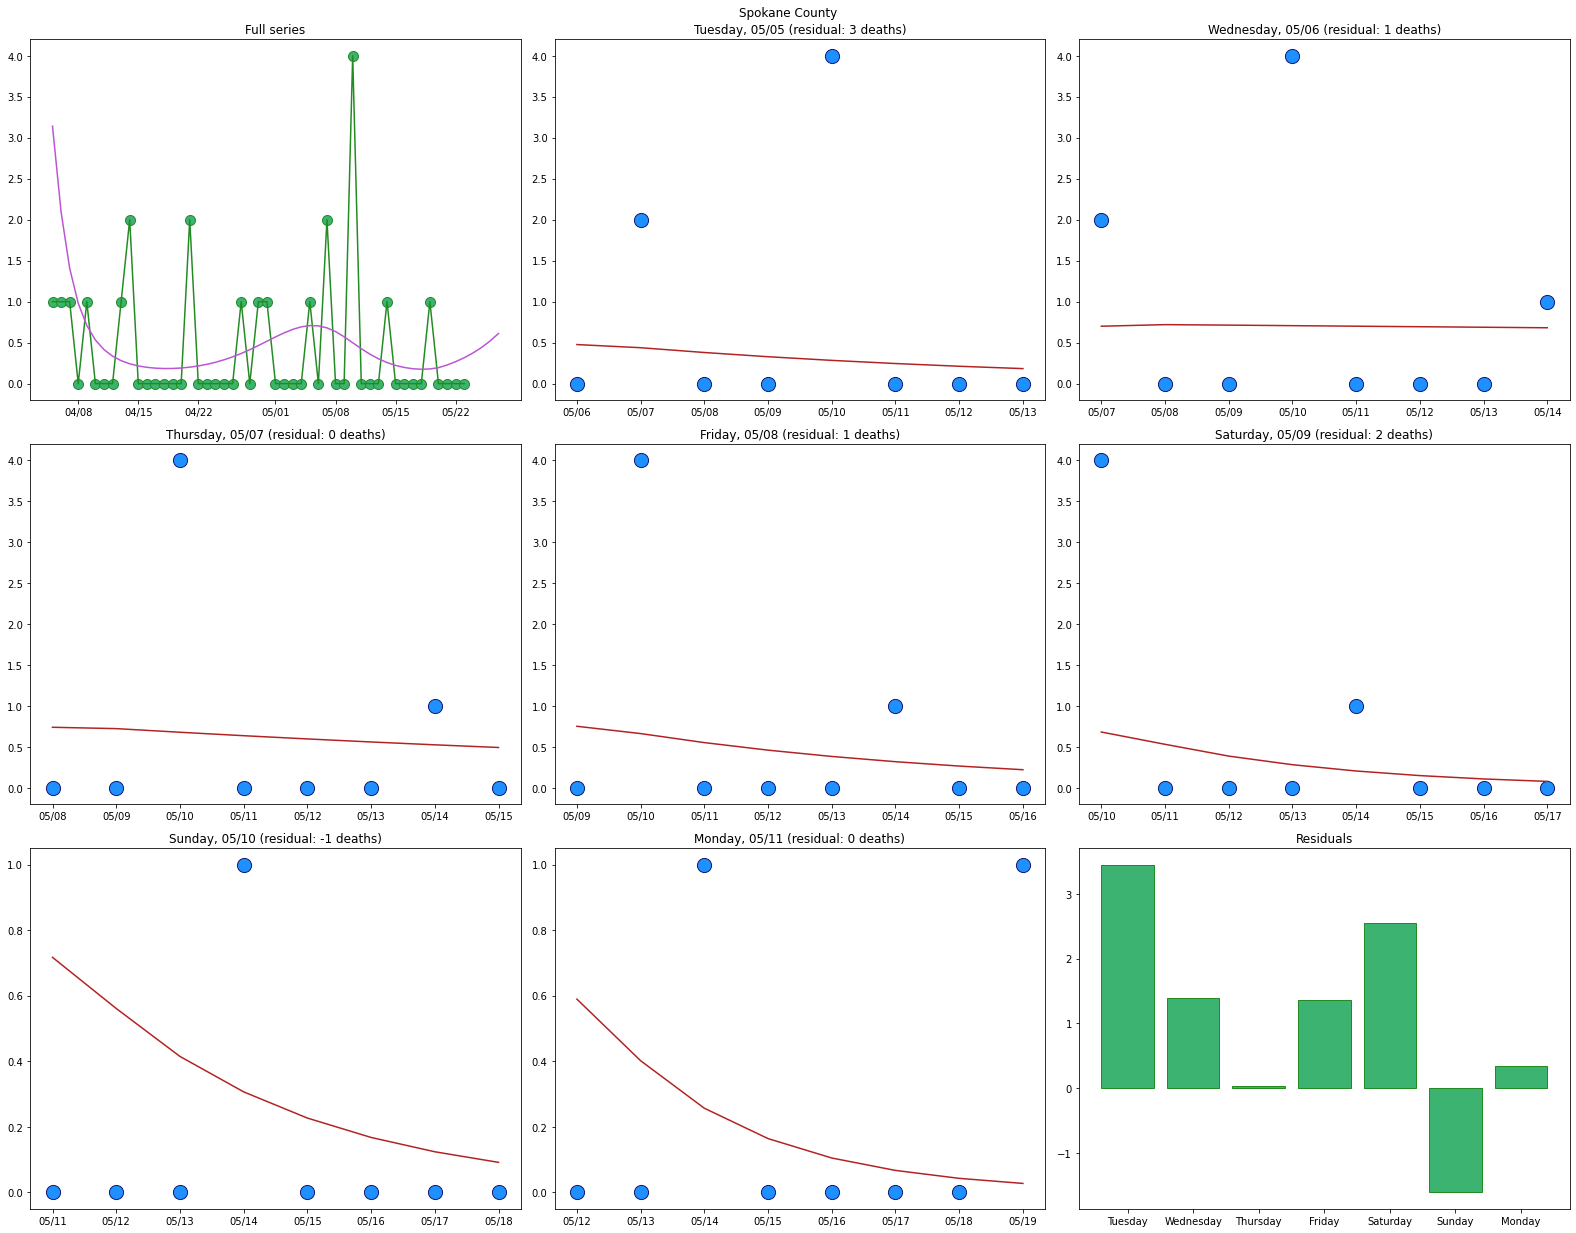

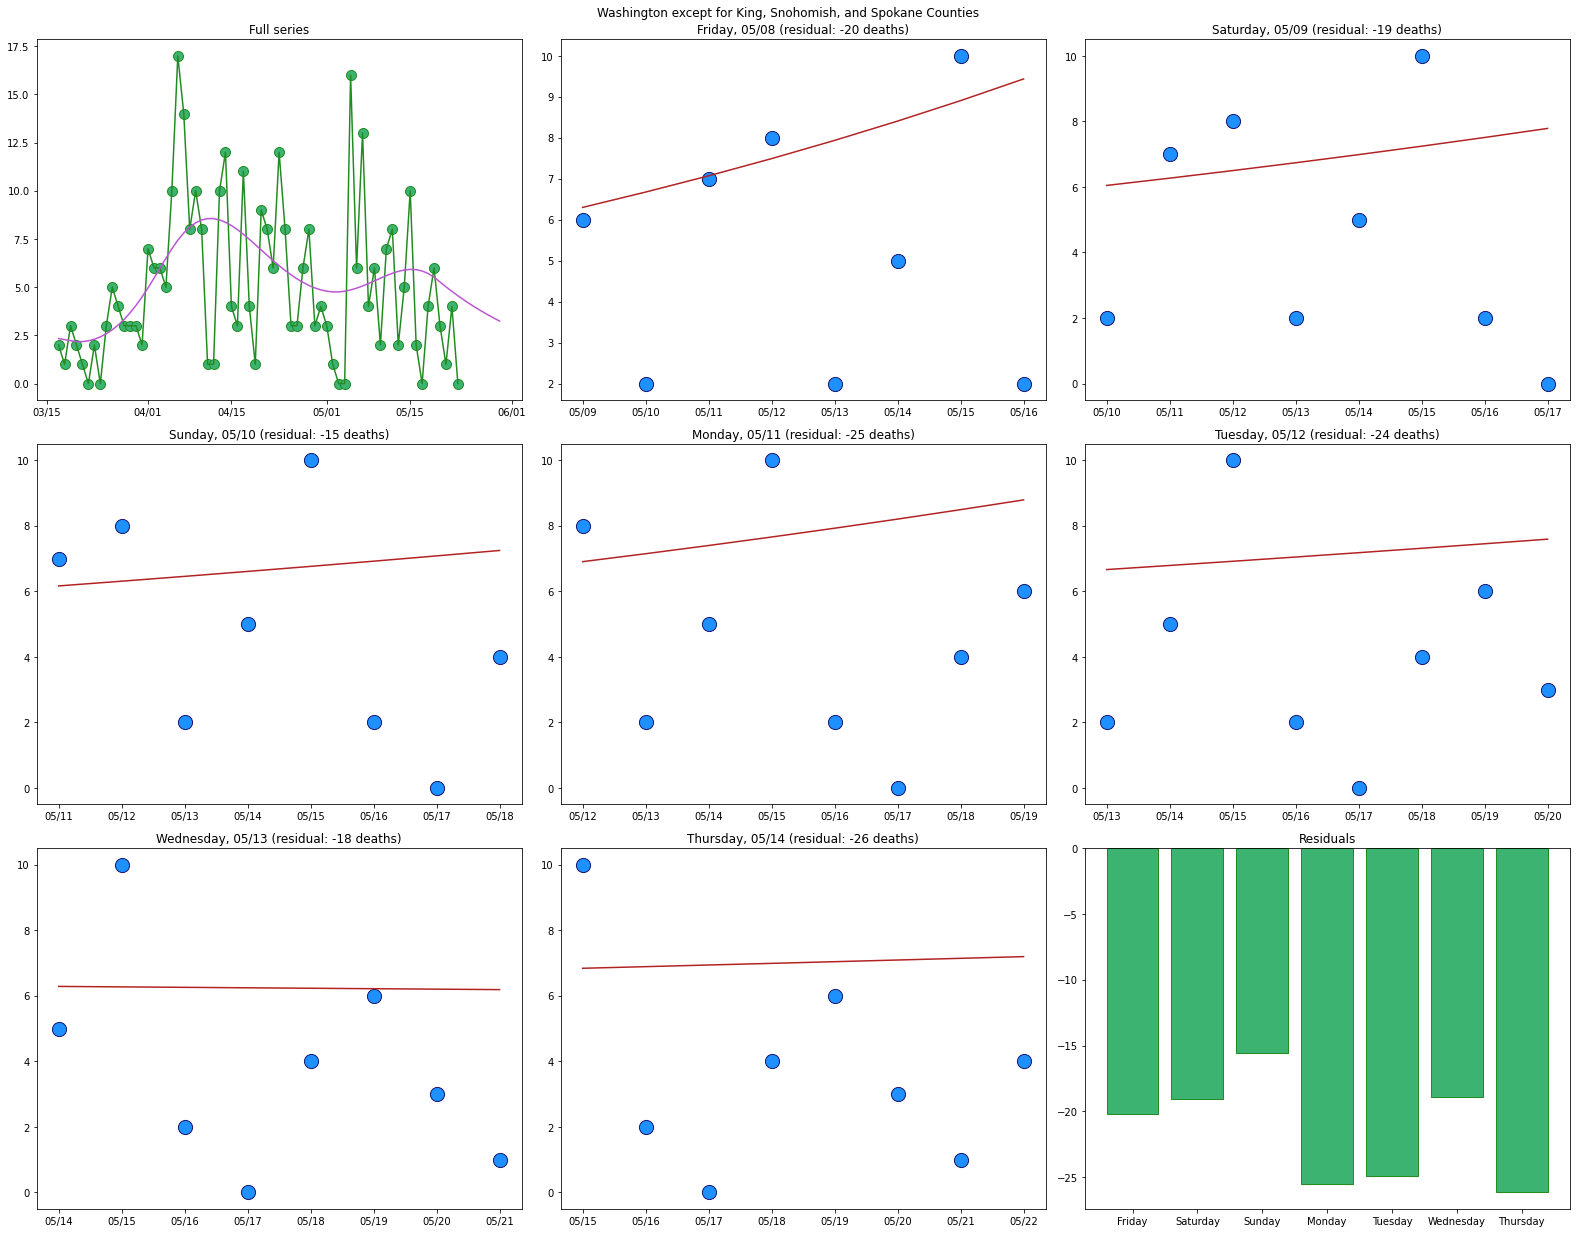

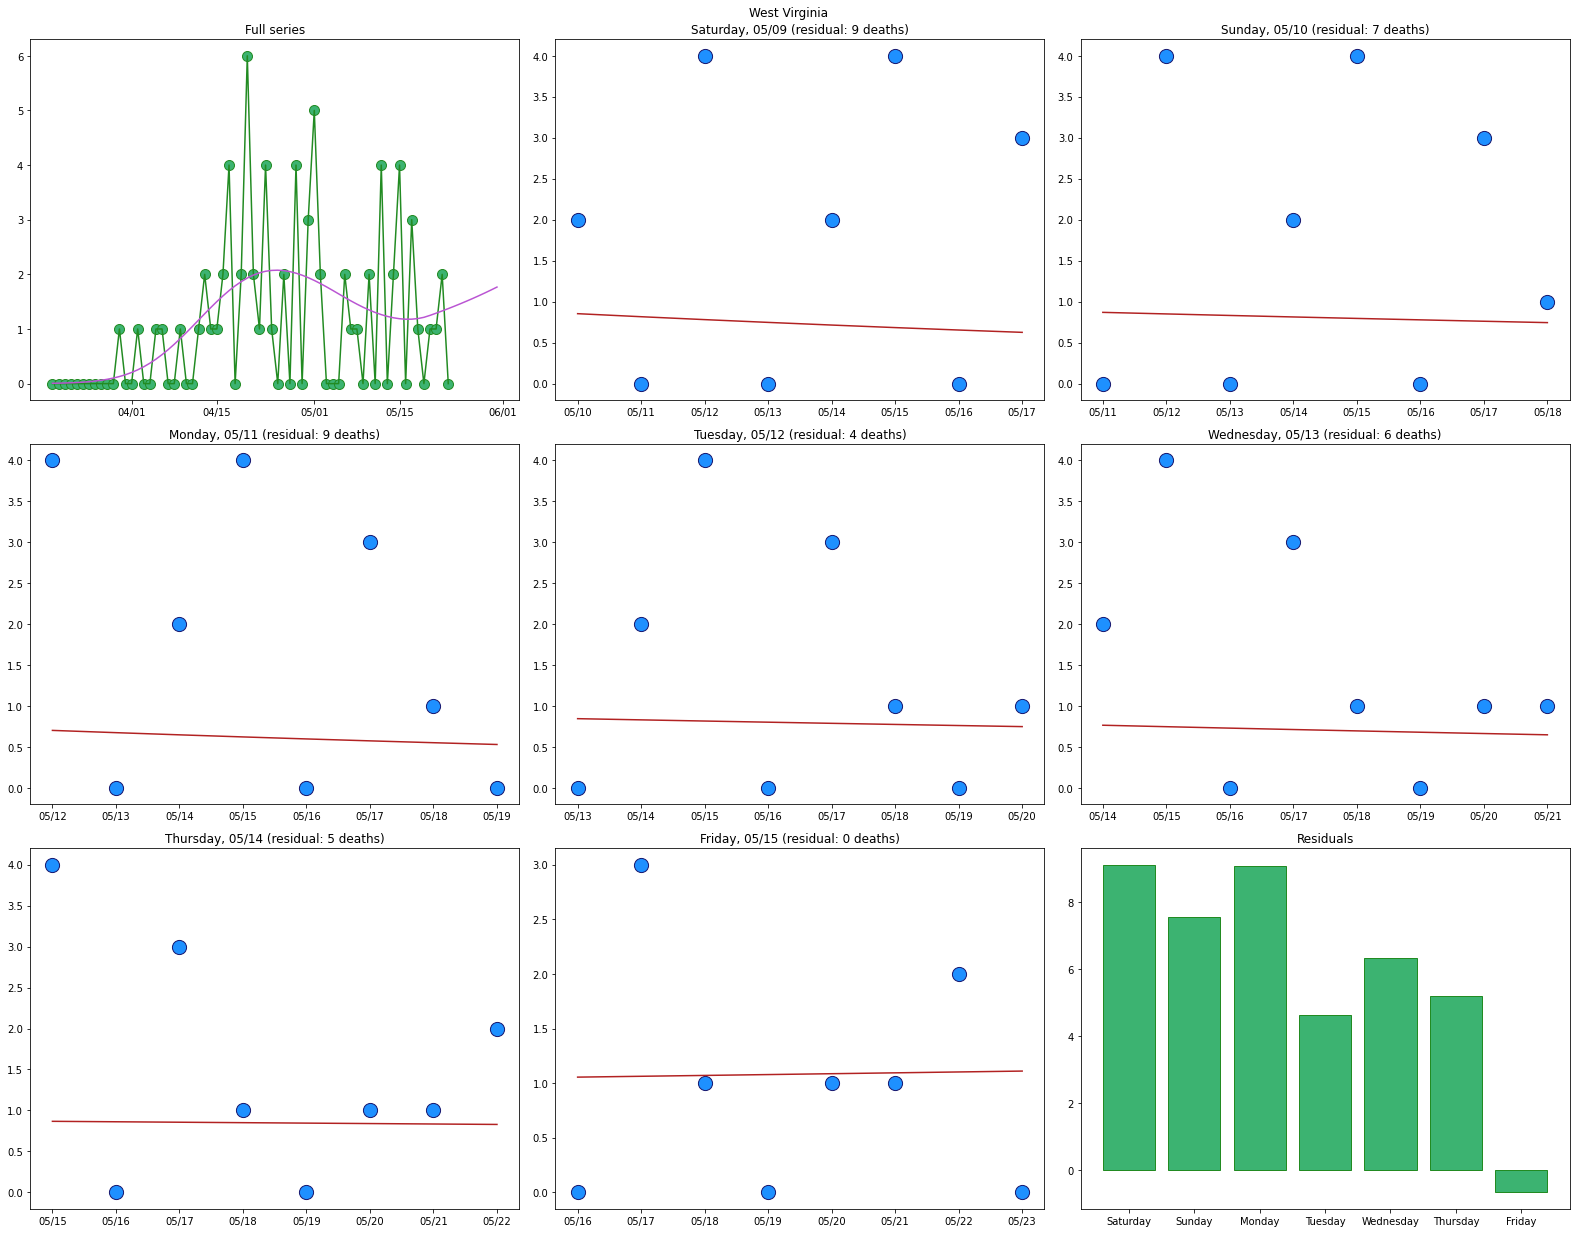

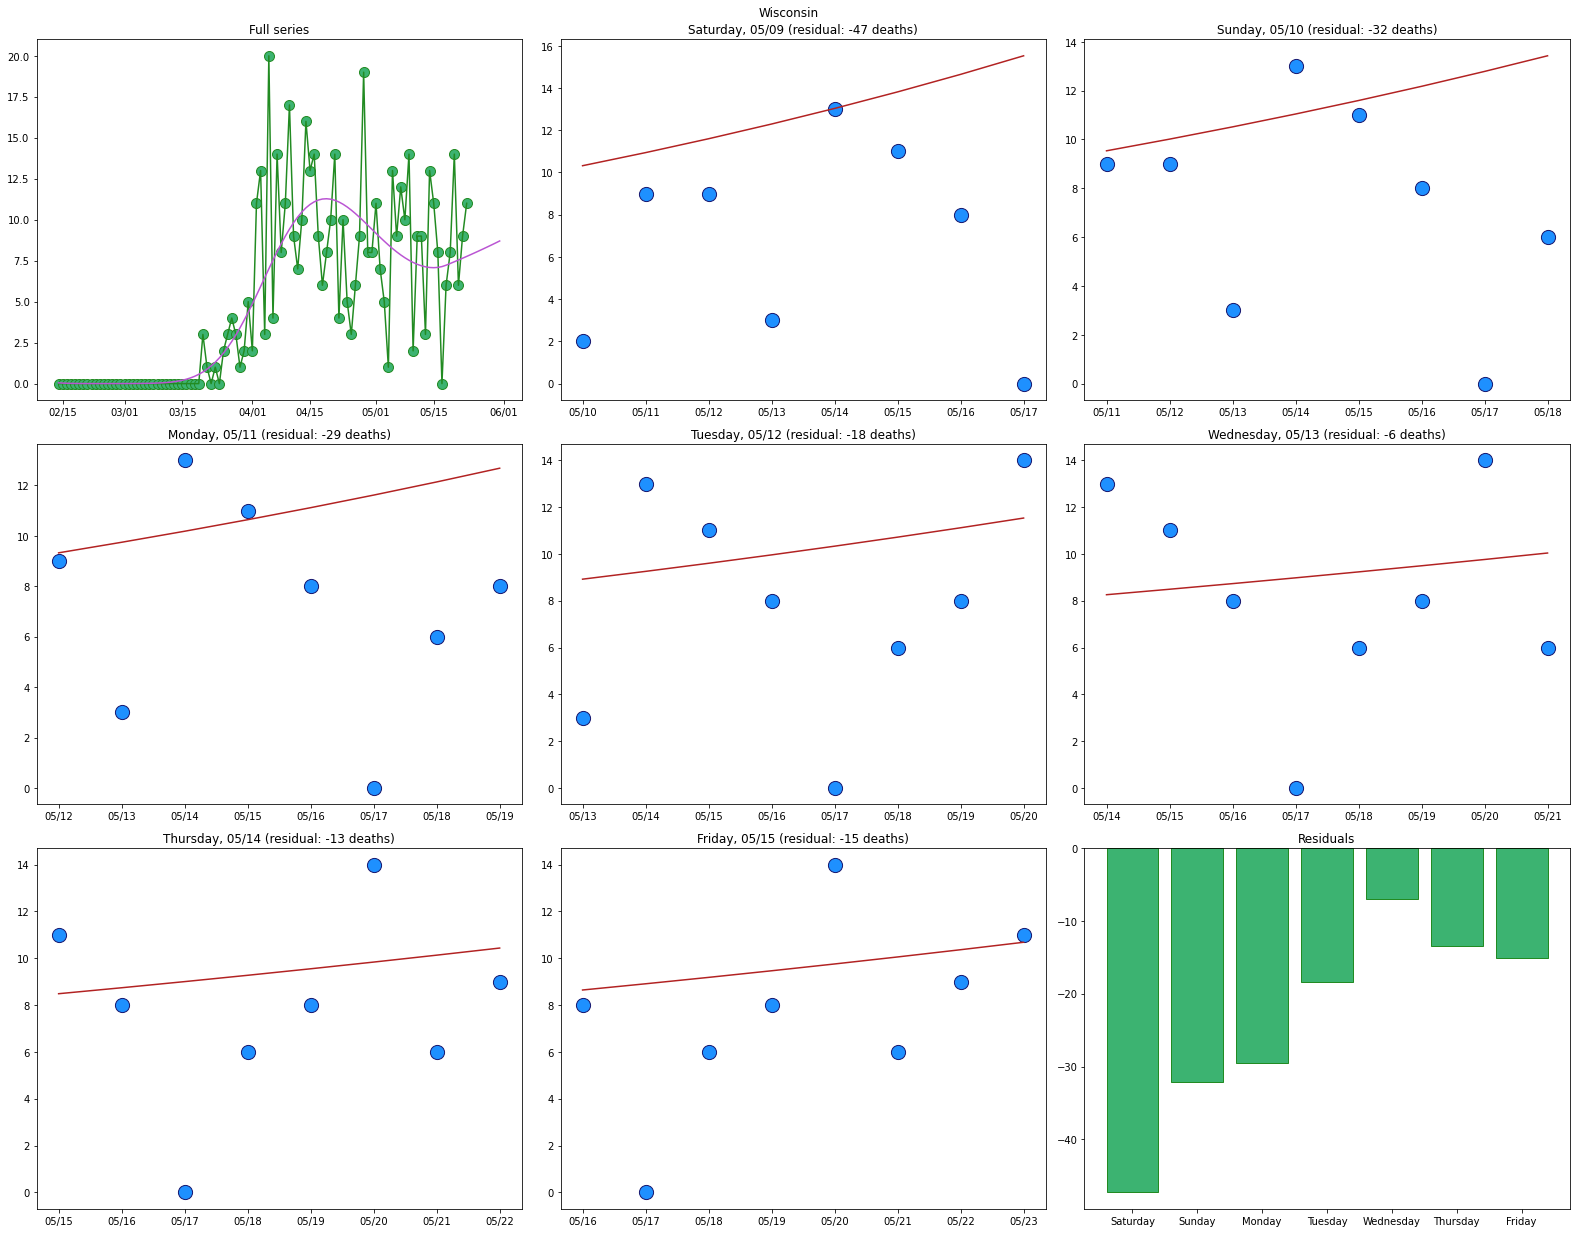

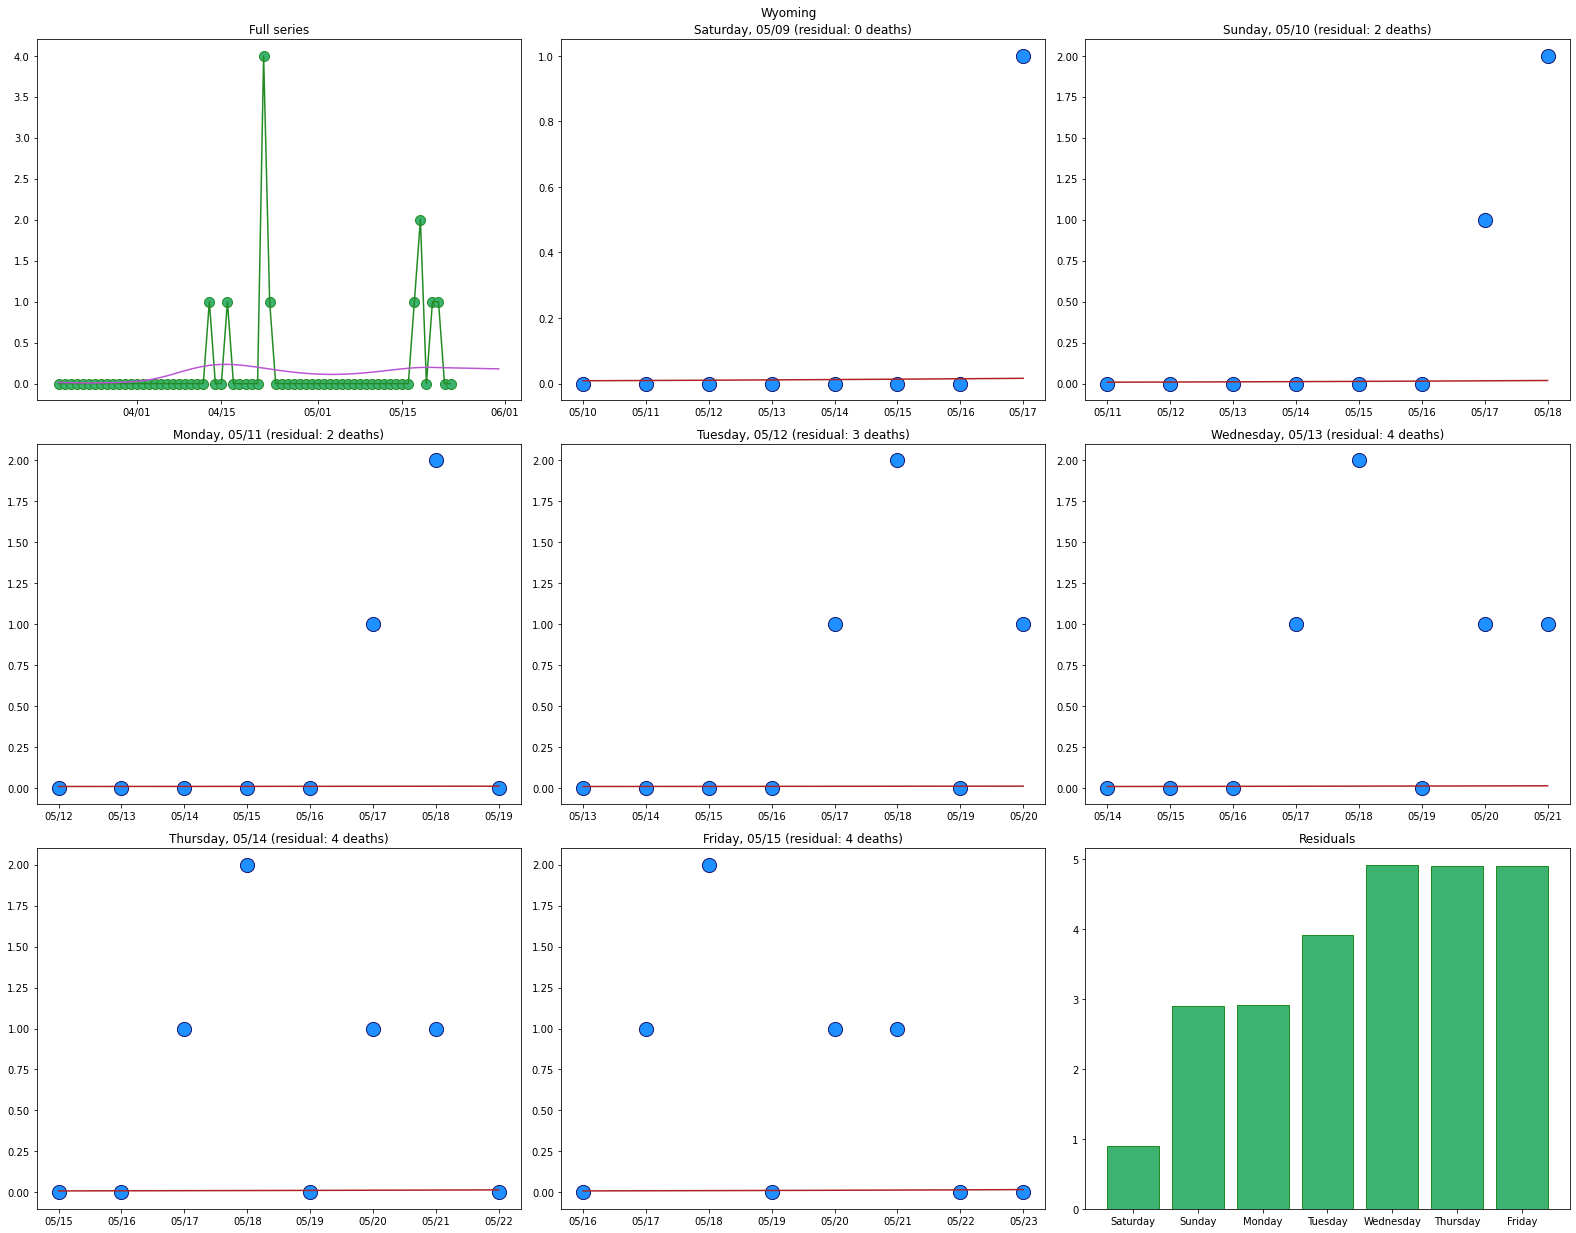

In [80]:
for location_id in df['location_id'].unique():
    fig, ax = plt.subplots(3, 3, figsize=(22, 17))
    md_format = mdates.DateFormatter('%m/%d')

    plot_df = df.loc[df['location_id'] == location_id].reset_index(drop=True)

    ax[0, 0].scatter(plot_df['date'][1:],
                     plot_df['Observed deaths'][1:], 
                     c='mediumseagreen', edgecolors='forestgreen', s=100)
    ax[0, 0].plot(plot_df['date'][1:],
                  plot_df['Observed deaths'][1:], 
                  color='forestgreen')
    ax[0, 0].plot(plot_df['date'][1:],
                  plot_df['Overall predicted deaths'][1:], 
                  color='mediumorchid')
    ax[0, 0].set_title('Full series')
    ax[0, 0].xaxis.set_major_formatter(md_format)

    errors = {}
    for i in range(7):
        loc=int((i+1)/3), (i+1)%3

        day_plot_df = plot_df.merge(est_dfs[6-i])

        error = day_plot_df['Observed deaths'].sum() - day_plot_df['Predicted deaths'].sum()
        pred_day = day_plot_df['date'].min() - pd.Timedelta(days=1)
        title = pred_day.strftime('%A, %m/%d')
        title += f' (residual: {int(error)} deaths)'
        errors.update({pred_day.strftime('%A'):error})

        ax[loc].scatter(day_plot_df['date'],
                        day_plot_df['Observed deaths'], 
                        c='dodgerblue', edgecolors='midnightblue', s=200)
        ax[loc].plot(day_plot_df['date'],
                     day_plot_df['Predicted deaths'], color='firebrick')
        ax[loc].set_title(title)
        ax[loc].xaxis.set_major_formatter(md_format)

    ax[2,2].bar(errors.keys(), errors.values(), 
                color='mediumseagreen', edgecolor='forestgreen')
    ax[2, 2].set_title('Residuals')


    fig.suptitle(plot_df['location_name'][0], y=1.005)
    fig.tight_layout()

    plt.show()